### Basic neural activity analysis with single camera tracking
#### analyze the firing rate PC1,2,3
#### making the demo videos
#### analyze the spike triggered pull and gaze ditribution

In [ ]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import scipy.io
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from dPCA import dPCA
import string
import warnings
import pickle
import json

from scipy.ndimage import gaussian_filter1d

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests


### function - get body part location for each pair of cameras

In [ ]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [ ]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [ ]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [ ]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [ ]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [ ]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [ ]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [ ]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo
from ana_functions.tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo

### function - interval between all behavioral events

In [ ]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [ ]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation
from ana_functions.plot_spike_triggered_singlecam_bhvevent import plot_spike_triggered_singlecam_bhvevent
from ana_functions.plot_bhv_events_aligned_FR import plot_bhv_events_aligned_FR
from ana_functions.plot_strategy_aligned_FR import plot_strategy_aligned_FR

### function - PCA projection

In [ ]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video
from ana_functions.confidence_ellipse import confidence_ellipse

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [ ]:
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag_withNeuron import graph_to_matrix
from ana_functions.train_DBN_multiLag_withNeuron import get_weighted_dags
from ana_functions.train_DBN_multiLag_withNeuron import get_significant_edges
from ana_functions.train_DBN_multiLag_withNeuron import threshold_edges
from ana_functions.train_DBN_multiLag_withNeuron import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [ ]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 1

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used


# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                        
                                    '20250129_Dodson_MC',
                                    '20250130_Dodson_SR',
                                    '20250131_Dodson_MC',
                                
            
                                    '20250210_Dodson_SR_withKoala',
                                    '20250211_Dodson_MC_withKoala',
                                    '20250212_Dodson_SR_withKoala',
                                    '20250214_Dodson_MC_withKoala',
                                    '20250217_Dodson_SR_withKoala',
                                    '20250218_Dodson_MC_withKoala',
                                    '20250219_Dodson_SR_withKoala',
                                    '20250220_Dodson_MC_withKoala',
                                    '20250224_Dodson_KoalaAL_withKoala',
                                    '20250226_Dodson_MC_withKoala',
                                    '20250227_Dodson_KoalaAL_withKoala',
                                    '20250228_Dodson_DodsonAL_withKoala',
                                    '20250304_Dodson_DodsonAL_withKoala',
                                    '20250305_Dodson_MC_withKoala',
                                    '20250306_Dodson_KoalaAL_withKoala',
                                    '20250307_Dodson_DodsonAL_withKoala',
                                    '20250310_Dodson_MC_withKoala',
                                    '20250312_Dodson_NV_withKoala',
                                    '20250313_Dodson_NV_withKoala',
                                    '20250314_Dodson_NV_withKoala',
            
                                    '20250401_Dodson_MC_withKanga',
                                    '20250402_Dodson_MC_withKanga',
                                    '20250403_Dodson_MC_withKanga',
                                    '20250404_Dodson_SR_withKanga',
                                    '20250407_Dodson_SR_withKanga',
                                    '20250408_Dodson_SR_withKanga',
                                    '20250409_Dodson_MC_withKanga',
            
                                    '20250415_Dodson_MC_withKanga',
                                    # '20250416_Dodson_SR_withKanga', # has to remove from the later analysis, recording has problems
                                    '20250417_Dodson_MC_withKanga',
                                    '20250418_Dodson_SR_withKanga',
                                    '20250421_Dodson_SR_withKanga',
                                    '20250422_Dodson_MC_withKanga',
                                    '20250422_Dodson_SR_withKanga',
            
                                    '20250423_Dodson_MC_withKanga',
                                    '20250423_Dodson_SR_withKanga', 
                                    '20250424_Dodson_NV_withKanga',
                                    '20250424_Dodson_MC_withKanga',
                                    '20250424_Dodson_SR_withKanga',            
                                    '20250425_Dodson_NV_withKanga',
                                    '20250425_Dodson_SR_withKanga',
                                    '20250428_Dodson_NV_withKanga',
                                    '20250428_Dodson_MC_withKanga',
                                    '20250428_Dodson_SR_withKanga',  
                                    '20250429_Dodson_NV_withKanga',
                                    '20250429_Dodson_MC_withKanga',
                                    '20250429_Dodson_SR_withKanga',  
                                    '20250430_Dodson_NV_withKanga',
                                    '20250430_Dodson_MC_withKanga',
                                    '20250430_Dodson_SR_withKanga',  
            
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            
                            'MC_withGingerNew',
                            'SR_withGingerNew',
                            'MC_withGingerNew',
            
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',

                            'MC_withKanga',
                            'MC_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
            
                            'MC_withKanga',
                            # 'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
            
                            'MC_withKanga',
                            'SR_withKanga', 
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',            
                            'NV_withKanga',
                            'SR_withKanga',
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
            
                        '20250129',
                        '20250130',
                        '20250131',
            
                        '20250210',
                        '20250211',
                        '20250212',
                        '20250214',
                        '20250217',
                        '20250218',
                        '20250219',
                        '20250220',
                        '20250224',
                        '20250226',
                        '20250227',
                        '20250228',
                        '20250304',
                        '20250305',
                        '20250306',
                        '20250307',
                        '20250310',
                        '20250312',
                        '20250313',
                        '20250314',
            
                        '20250401',
                        '20250402',
                        '20250403',
                        '20250404',
                        '20250407',
                        '20250408',
                        '20250409',
            
                        '20250415',
                        # '20250416',
                        '20250417',
                        '20250418',
                        '20250421',
                        '20250422',
                        '20250422_SR',
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
            
                            '20250129',
                            '20250130',
                            '20250131',
                            
                            '20250210',
                            '20250211',
                            '20250212',
                            '20250214',
                            '20250217',
                            '20250218',          
                            '20250219',
                            '20250220',
                            '20250224',
                            '20250226',
                            '20250227',
                            '20250228',
                            '20250304',
                            '20250305',
                            '20250306',
                            '20250307',
                            '20250310',
                            '20250312',
                            '20250313',
                            '20250314',
            
                            '20250401',
                            '20250402',
                            '20250403',
                            '20250404',
                            '20250407',
                            '20250408',
                            '20250409',
            
                            '20250415',
                            # '20250416',
                            '20250417',
                            '20250418',
                            '20250421',
                            '20250422',
                            '20250422_SR',
            
                            '20250423',
                            '20250423_SR', 
                            '20250424',
                            '20250424_MC',
                            '20250424_SR',            
                            '20250425',
                            '20250425_SR',
                            '20250428_NV',
                            '20250428_MC',
                            '20250428_SR',  
                            '20250429_NV',
                            '20250429_MC',
                            '20250429_SR',  
                            '20250430_NV',
                            '20250430_MC',
                            '20250430_SR',  
            
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
            
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                73.5,
                                0.00,
                                76.1,
                                81.5,
                                0.00,
            
                                363,
                                # 0.00,
                                79.0,
                                162.6,
                                231.9,
                                109,
                                0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
            
                              ] # in second
        
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = [ 'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0', #'Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             
                              ]
        animal1_fixedorders = ['dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',# 'dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson',
                              ]
        recordedanimals = animal1_fixedorders 
        animal2_fixedorders = ['ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger',
                               'ginger','ginger','ginger','ginger','ginger','ginger','gingerNew','gingerNew','gingerNew',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', # 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                              ]

        animal1_filenames = ["Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",# "Dodson",
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson',
                            ]
        animal2_filenames = ["Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", # "Kanga",
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     '20231101_Dodson_withGinger_SR',
                                     '20231107_Dodson_withGinger_SR',
                                     '20231122_Dodson_withGinger_SR',
                                     '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            'SR',
                            'SR',
                            'SR',
                            'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      "20231101_SR",
                      "20231107_SR",
                      "20231122_SR",
                      "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         2, 
                         2, 
                         4, 
                         4,
                       ]
    
        trig_channelnames = ['Dev1/ai0']*np.shape(dates_list)[0]
        animal1_fixedorder = ['dodson']*np.shape(dates_list)[0]
        recordedanimals = animal1_fixedorders
        animal2_fixedorder = ['ginger']*np.shape(dates_list)[0]

        animal1_filename = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filename = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
            
                                     '20250415_Kanga_MC_withDodson',
                                     '20250416_Kanga_SR_withDodson',
                                     '20250417_Kanga_MC_withDodson',
                                     '20250418_Kanga_SR_withDodson',
                                     '20250421_Kanga_SR_withDodson',
                                     '20250422_Kanga_MC_withDodson',
                                     '20250422_Kanga_SR_withDodson',
            
                                    '20250423_Kanga_MC_withDodson',
                                    '20250423_Kanga_SR_withDodson', 
                                    '20250424_Kanga_NV_withDodson',
                                    '20250424_Kanga_MC_withDodson',
                                    '20250424_Kanga_SR_withDodson',            
                                    '20250425_Kanga_NV_withDodson',
                                    '20250425_Kanga_SR_withDodson',
                                    '20250428_Kanga_NV_withDodson',
                                    '20250428_Kanga_MC_withDodson',
                                    '20250428_Kanga_SR_withDodson',  
                                    '20250429_Kanga_NV_withDodson',
                                    '20250429_Kanga_MC_withDodson',
                                    '20250429_Kanga_SR_withDodson',  
                                    '20250430_Kanga_NV_withDodson',
                                    '20250430_Kanga_MC_withDodson',
                                    '20250430_Kanga_SR_withDodson',  
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
            
                      "20250415",
                      "20250416",
                      "20250417",
                      "20250418",
                      "20250421",
                      "20250422",
                      "20250422_SR",
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
            
                             'MC_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
            
                             'MC_withDodson',
                            'SR_withDodson', 
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',            
                            'NV_withDodson',
                            'SR_withDodson',
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
            
                                 363,
                                 0.00,
                                 79.0,
                                 162.6,
                                 231.9,
                                 109,
                                 0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
                              ] # in second
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = ['Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                             'Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              ]
        
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger','koala','koala','koala','vermelho','vermelho',
                               'vermelho','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                              ]
        recordedanimals = animal2_fixedorders

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                              "Kanga","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Koala","Koala","Koala","Vermelho","Vermelho",
                             "Vermelho","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]
        recordedanimals = animal2_fixedorders
        
        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 1: # kanga example
    neural_record_conditions = ['20240606_Kanga_MC']
    dates_list = ["20240606"]
    videodates_list = dates_list
    task_conditions = ['MC']
    session_start_times = [89] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dannon']
    animal2_fixedorders = ['kanga']
    recordedanimals = animal2_fixedorders
    animal1_filenames = ["Dannon"]
    animal2_filenames = ["Kanga"]
if 0: # dodson example 
    neural_record_conditions = ['20250415_Dodson_MC_withKanga']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withKanga']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dodson']
    recordedanimals = animal1_fixedorders
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]

ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'

considerlevertube = 1
considertubeonly = 0

# location of levers and tubes for camera 2
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
# # location of the estimiated middle of the box
lever_locs_camI = {'dodson':np.array([1325,615]),'scorch':np.array([560,615])}
# # location of the estimated lever
# lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # old
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])

spike_trig_events_all_dates = dict.fromkeys(dates_list, [])

bhvevents_aligned_FR_all_dates = dict.fromkeys(dates_list, [])
bhvevents_aligned_FR_allevents_all_dates = dict.fromkeys(dates_list, [])

strategy_aligned_FR_all_dates = dict.fromkeys(dates_list, [])
strategy_aligned_FR_allevents_all_dates = dict.fromkeys(dates_list, [])

# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

analyze all dates
load social gaze with camera-2 only of 20240606
load spike data for 20240606_Kanga_MC
load LFP data for 20240606_Kanga_MC
print the example frame from the demo videos
printing frame  4471 / 4471


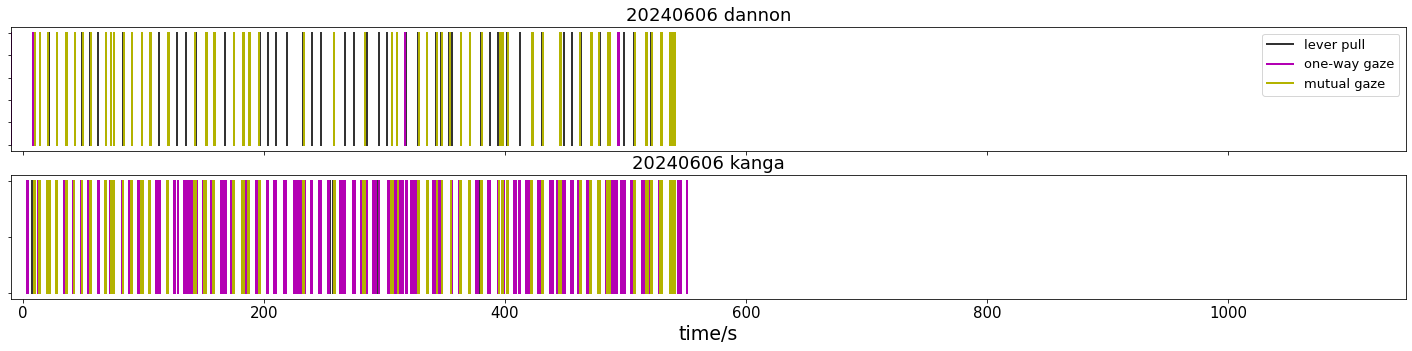

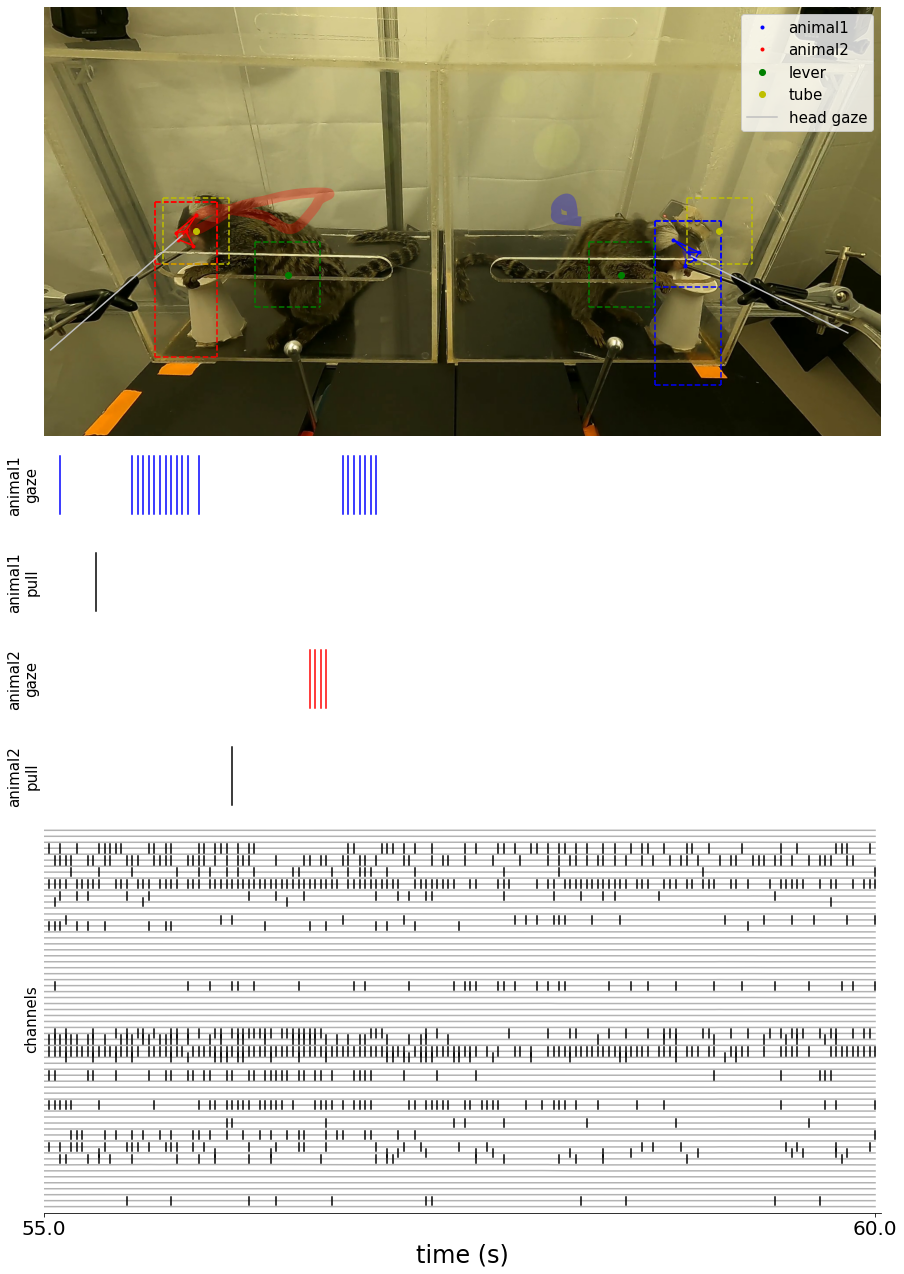

In [46]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/spike_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        spike_trig_events_all_dates = pickle.load(f) 
        
    with open(data_saved_subfolder+'/bhvevents_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvevents_aligned_FR_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/bhvevents_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvevents_aligned_FR_allevents_all_dates = pickle.load(f) 
        
    with open(data_saved_subfolder+'/strategy_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        strategy_aligned_FR_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/strategy_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        strategy_aligned_FR_allevents_all_dates = pickle.load(f) 
        
    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
    
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]
        
        trig_channelname = trig_channelnames[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        recordedanimal = recordedanimals[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        # 
        try: 
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
            
        # define successful pulls and failed pulls
        if 0: # old definition; not in use
            trialnum_succ = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']>0])
            bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trialnum_succ)]
            #
            time_point_pull1_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==1]
            time_point_pull2_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==2]
            time_point_pull1_succ = np.round(time_point_pull1_succ,1)
            time_point_pull2_succ = np.round(time_point_pull2_succ,1)
            #
            trialnum_fail = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']==0])
            bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trialnum_fail)]
            #
            time_point_pull1_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==1]
            time_point_pull2_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==2]
            time_point_pull1_fail = np.round(time_point_pull1_fail,1)
            time_point_pull2_fail = np.round(time_point_pull2_fail,1)
        else:
            # a new definition of successful and failed pulls
            # separate successful and failed pulls
            # step 1 all pull and juice
            time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
            time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
            time_point_juice1 = bhv_data["time_points"][bhv_data["behavior_events"]==3]
            time_point_juice2 = bhv_data["time_points"][bhv_data["behavior_events"]==4]
            # step 2:
            # pull 1
            # Find the last pull before each juice
            successful_pull1 = [time_point_pull1[time_point_pull1 < juice].max() for juice in time_point_juice1]
            # Convert to Pandas Series
            successful_pull1 = pd.Series(successful_pull1, index=time_point_juice1.index)
            # Find failed pulls (pulls that are not successful)
            failed_pull1 = time_point_pull1[~time_point_pull1.isin(successful_pull1)]
            # pull 2
            # Find the last pull before each juice
            successful_pull2 = [time_point_pull2[time_point_pull2 < juice].max() for juice in time_point_juice2]
            # Convert to Pandas Series
            successful_pull2 = pd.Series(successful_pull2, index=time_point_juice2.index)
            # Find failed pulls (pulls that are not successful)
            failed_pull2 = time_point_pull2[~time_point_pull2.isin(successful_pull2)]
            #
            # step 3:
            time_point_pull1_succ = np.round(successful_pull1,1)
            time_point_pull2_succ = np.round(successful_pull2,1)
            time_point_pull1_fail = np.round(failed_pull1,1)
            time_point_pull2_fail = np.round(failed_pull2,1)
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
            
        # new total session time (instead of 600s) - total time of the video recording
        totalsess_time = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30) 
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, totalsess_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, totalsess_time, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

     
        
        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 1:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        
        
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        try:
            neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        except: # for the multi-animal recording setup
            neural_start_time_niboard_offset = next(
                entry['timepoints'][0]['elapsed_time']
                for entry in ni_data['trigger_ts']
                if entry['channel_name'] == f"{trig_channelname}")
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)
            
        # # load spike sorting results
        if 1:
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
            
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
            #
           
            
            # calculate the firing rate
            # FR_kernel = 0.20 # in the unit of second
            FR_kernel = 1/30 # in the unit of second # 1/30 same resolution as the video recording
            # FR_kernel is sent to to be this if want to explore it's relationship with continuous trackng data
            
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30)  # to match the total time of the video recording
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
                                                                                          spike_clusters_data, spike_time_data)
            # _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
            #                                                                              spike_channels_data, spike_time_data)
            # behavioral events aligned firing rate for each unit
            if 0: 
                print('plot event aligned firing rate')
                #
                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filename+"_"+animal2_filename+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                aligntwins = 4 # 5 second
                gaze_thresold = 0.2 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
                #
                bhvevents_aligned_FR_average_all,bhvevents_aligned_FR_allevents_all = plot_bhv_events_aligned_FR(date_tgt,savefig,save_path, animal1, animal2,time_point_pull1,time_point_pull2,time_point_pulls_succfail,
                                           oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,
                                           aligntwins,fps,FR_timepoint_allch,FR_zscore_allch,clusters_info_data)
                
                bhvevents_aligned_FR_all_dates[date_tgt] = bhvevents_aligned_FR_average_all
                bhvevents_aligned_FR_allevents_all_dates[date_tgt] = bhvevents_aligned_FR_allevents_all
                
            
            # the three strategy aligned firing rate for each unit
            if 0: 
                print('plot strategy aligned firing rate')
                #
                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filename+"_"+animal2_filename+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                stg_twins = 1.5 # 3s, the behavioral event interval used to define strategy, consistent with DBN 3s time lags
                aligntwins = 4 # 5 second
                gaze_thresold = 0.2 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
                #
                strategy_aligned_FR_average_all,strategy_aligned_FR_allevents_all = plot_strategy_aligned_FR(date_tgt,savefig,save_path, animal1, animal2,time_point_pull1,time_point_pull2,time_point_pulls_succfail,
                                           oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,
                                           aligntwins,stg_twins,fps,FR_timepoint_allch,FR_zscore_allch,clusters_info_data)
                
                strategy_aligned_FR_all_dates[date_tgt] = strategy_aligned_FR_average_all
                strategy_aligned_FR_allevents_all_dates[date_tgt] = strategy_aligned_FR_allevents_all
                
            
            #
            # Run PCA analysis
            FR_zscore_allch_np_merged = np.array(pd.DataFrame(FR_zscore_allch).T)
            FR_zscore_allch_np_merged = FR_zscore_allch_np_merged[~np.isnan(np.sum(FR_zscore_allch_np_merged,axis=1)),:]
            # # run PCA on the entire session
            pca = PCA(n_components=3)
            FR_zscore_allch_PCs = pca.fit_transform(FR_zscore_allch_np_merged.T)
            #
            # # run PCA around the -PCAtwins to PCAtwins for each behavioral events
            PCAtwins = 4 # 5 second
            gaze_thresold = 0.5 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
            savefigs = 0 
            if 0:
                PCA_around_bhv_events(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                              oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                              savefigs,data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
            if 0:
                if (np.isin(animal1, ['dodson'])) | (np.isin(animal2, ['kanga'])):
                    PCA_around_bhv_events_video(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                                      oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                                      data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
                elif (np.isin(animal2, ['dodson'])) | (np.isin(animal1, ['kanga'])):
                    time_point_pulls_succfail_rev = time_point_pulls_succfail.copy()
                    time_point_pulls_succfail_rev['pull1_succ'] = time_point_pulls_succfail['pull2_succ']
                    time_point_pulls_succfail_rev['pull1_fail'] = time_point_pulls_succfail['pull2_fail']
                    time_point_pulls_succfail_rev['pull2_succ'] = time_point_pulls_succfail['pull1_succ']
                    time_point_pulls_succfail_rev['pull2_fail'] = time_point_pulls_succfail['pull1_fail']
                    PCA_around_bhv_events_video(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull2,time_point_pull1,time_point_pulls_succfail_rev, 
                                      oneway_gaze2,oneway_gaze1,mutual_gaze2,mutual_gaze1,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                                      data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
            
            
            
            # do the spike triggered average of different bhv variables, for the single camera tracking, look at the pulling and social gaze actions
            # the goal is to get a sense for glm
            if 0: 
                print('plot spike triggered bhv variables')

                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filename+"_"+animal2_filename+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                do_shuffle = 0
                #
                min_length = np.shape(look_at_other_or_not_merge['dodson'])[0] # frame numbers of the video recording
                #
                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                
                gaze_thresold = 0.2
                
                stg_twins = 3 # 3s, the behavioral event interval used to define strategy, consistent with DBN 3s time lags
                #
                spike_trig_average_all =  plot_spike_triggered_singlecam_bhvevent(date_tgt,savefig,save_path, animal1, animal2, session_start_time,min_length, trig_twins,
                                                                              stg_twins, time_point_pull1, time_point_pull2, time_point_pulls_succfail,
                                                                              oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,animalnames_videotrack,
                                                                              spike_clusters_data, spike_time_data,spike_channels_data,do_shuffle)

                spike_trig_events_all_dates[date_tgt] = spike_trig_average_all

            
        # load filtered lfp
        if 1:
            print('load LFP data for '+neural_record_condition)
            lfp_filt_filename = neural_data_folder+neural_record_condition+'/lfp_filt_subsample.txt' # already downsample to 30Hz
            lfp_filt_data_df = genfromtxt(lfp_filt_filename, delimiter=',')
            # aligned to the session start
            lfp_filt_sess_aligned=lfp_filt_data_df[:,int(-neural_start_time_session_start_offset*30):]
            # normalize the activity to 0 - 1
            lfp_filt_sess_aligned = (lfp_filt_sess_aligned-np.min(lfp_filt_sess_aligned))/(np.max(lfp_filt_sess_aligned)-np.min(lfp_filt_sess_aligned))

        
        # plot the tracking demo video
        if 0: 
            print('make the demo videos')
            if 0:
                # all the bhv traces in the same panel
                tracking_video_singlecam_wholebody_withNeuron_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                  lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                  animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                  animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                  video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                  spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
            if 1:
                # all the bhv traces are in separate panels
                tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                 lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                 animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                 animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                 video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                 spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
        
        # plot the example frame from the tracking demo video
        if 1: 
            print('print the example frame from the demo videos')
            if 1:
                example_frame = 60*30+1
                start_frame = 55*30
                # all the bhv traces are in separate panels
                tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                 lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                 animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                 animal1_filename,animal2_filename,session_start_time,fps,start_frame,example_frame,cameraID,
                                                 video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                 spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
                savefig = 1
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filename+"_"+animal2_filename+"/"+date_tgt+"/"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                if savefig:
                    plt.savefig(save_path+'singlecam_wholebody_tracking_withNeuron_sepbhv_demo_oneframe.pdf')
        

    # save data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/spike_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(spike_trig_events_all_dates, f)  
    
        with open(data_saved_subfolder+'/bhvevents_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_aligned_FR_all_dates, f) 
        with open(data_saved_subfolder+'/bhvevents_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_aligned_FR_allevents_all_dates, f) 
            
        with open(data_saved_subfolder+'/strategy_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(strategy_aligned_FR_all_dates, f) 
        with open(data_saved_subfolder+'/strategy_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(strategy_aligned_FR_allevents_all_dates, f) 
    
    
    # only save a subset 
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
    
        with open(data_saved_subfolder+'/strategy_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(strategy_aligned_FR_all_dates, f) 
        with open(data_saved_subfolder+'/strategy_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(strategy_aligned_FR_allevents_all_dates, f) 
    
    

In [ ]:
sss

### plot 
#### plot the PCs

In [ ]:
if 0:
    fig, axs = plt.subplots(12,1)
    fig.set_figheight(20*1)
    fig.set_figwidth(5*3)

    x_lims = [0,totalsess_time_forFR]
    PC1min = np.min(FR_zscore_allch_PCs[:,0])
    PC1max = np.max(FR_zscore_allch_PCs[:,0])
    PC2min = np.min(FR_zscore_allch_PCs[:,1])
    PC2max = np.max(FR_zscore_allch_PCs[:,1])
    PC3min = np.min(FR_zscore_allch_PCs[:,2])
    PC3max = np.max(FR_zscore_allch_PCs[:,2])

    for iplotype in np.arange(0,4,1):

        if iplotype == 0:
            eventplot  = np.array(time_point_pull1)
            eventplotname = 'animal1_pull'
        elif iplotype == 1:
            eventplot  = np.array(time_point_pull2)
            eventplotname = 'animal2_pull'
        elif iplotype == 2:
            eventplot  = np.hstack([oneway_gaze1,mutual_gaze1])
            eventplotname = 'animal1_gaze'
        elif iplotype == 3:
            eventplot  = np.hstack([oneway_gaze2,mutual_gaze2])
            eventplotname = 'animal2_gaze'

        # plot 1
        nevents = np.shape(eventplot)[0]
        for ievent in np.arange(0,nevents,1):
            axs[0+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC1min,PC1max],'k-')
        axs[0+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[0+3*iplotype].set_ylim(PC1min,PC1max)
        #
        axs[0+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,0])
        axs[0+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[0+3*iplotype].set_ylabel('PC1\n'+eventplotname)

        # plot 2
        nevents = np.shape(eventplot)[0]
        for ievent in np.arange(0,nevents,1):
            axs[1+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC2min,PC2max],'k-')
        axs[1+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[1+3*iplotype].set_ylim(PC2min,PC2max)
        #
        axs[1+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,1])
        axs[1+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[1+3*iplotype].set_ylabel('PC2\n'+eventplotname)

        # plot 3
        nevents = np.shape(eventplot)[0]
        for ievent in np.arange(0,nevents,1):
            axs[2+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC3min,PC3max],'k-')
        axs[2+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[2+3*iplotype].set_ylim(PC3min,PC3max)
        #
        axs[2+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,2])
        axs[2+3*iplotype].set_xlim(x_lims[0],x_lims[1])
        axs[2+3*iplotype].set_ylabel('PC3\n'+eventplotname)


#### analyze the bhv aligned firing rate across all dates
#### plot the tsne or PCA clusters

In [ ]:
if 0:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    doPCA = 1
    doTSNE = 0

    bhvevents_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(bhvevents_aligned_FR_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type].keys())

            for iclusterID in clusterIDs:

                ichannelID = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                bhvevents_aligned_FR_all_dates_df = bhvevents_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    if 0:
        # normalize FR_average for each unit
        nspikeunits = np.shape(bhvevents_aligned_FR_all_dates_df)[0]
        for ispikeunit in np.arange(0,nspikeunits,1):
            stevent = bhvevents_aligned_FR_all_dates_df['FR_average'][ispikeunit]
            stevent_norm = (stevent-np.nanmin(stevent))/(np.nanmax(stevent)-np.nanmin(stevent))
            bhvevents_aligned_FR_all_dates_df['FR_average'][ispikeunit] = stevent_norm            

    # only focus on the certain act animal and certain bhv_name
    # act_animals_all = ['kanga']
    # bhv_names_all = ['leverpull_prob']
    act_animals_all = np.unique(bhvevents_aligned_FR_all_dates_df['act_animal'])
    bhv_names_all = np.unique(bhvevents_aligned_FR_all_dates_df['bhv_name'])
    #
    nact_animals = np.shape(act_animals_all)[0]
    nbhv_names = np.shape(bhv_names_all)[0]

    # set for plot
    # plot all units
    fig1, axs1 = plt.subplots(nact_animals,nbhv_names)
    fig1.set_figheight(6*nact_animals)
    fig1.set_figwidth(6*nbhv_names)

    # plot all units but separate different days
    fig2, axs2 = plt.subplots(nact_animals,nbhv_names)
    fig2.set_figheight(6*nact_animals)
    fig2.set_figwidth(6*nbhv_names)

    # plot all units but seprate different channels
    fig3, axs3 = plt.subplots(nact_animals,nbhv_names)
    fig3.set_figheight(4*nact_animals)
    fig3.set_figwidth(4*nbhv_names)

    # plot all units but separate different conditions
    fig4, axs4 = plt.subplots(nact_animals,nbhv_names)
    fig4.set_figheight(6*nact_animals)
    fig4.set_figwidth(6*nbhv_names)

    # spike triggered average for different task conditions
    # # to be save, prepare for five conditions
    fig6, axs6 = plt.subplots(nact_animals*5,nbhv_names)
    fig6.set_figheight(6*nact_animals*5)
    fig6.set_figwidth(6*nbhv_names)
    # fig6, axs6 = plt.subplots(nact_animals,nbhv_names)
    # fig6.set_figheight(6*nact_animals)
    # fig6.set_figwidth(6*nbhv_names)

    # plot all units but separate different k-mean cluster
    fig5, axs5 = plt.subplots(nact_animals,nbhv_names)
    fig5.set_figheight(6*nact_animals)
    fig5.set_figwidth(6*nbhv_names)

    # spike triggered average for different k-mean cluster
    # to be save, prepare for 14 clusters
    fig7, axs7 = plt.subplots(nact_animals*14,nbhv_names)
    fig7.set_figheight(6*nact_animals*14)
    fig7.set_figwidth(6*nbhv_names)

    # stacked bar plot to show the cluster distribution of each conditions
    fig8, axs8 = plt.subplots(nact_animals,nbhv_names)
    fig8.set_figheight(6*nact_animals)
    fig8.set_figwidth(6*nbhv_names)

    #
    for ianimal in np.arange(0,nact_animals,1):

        act_animal = act_animals_all[ianimal]

        for ibhvname in np.arange(0,nbhv_names,1):

            bhv_name = bhv_names_all[ibhvname]

            ind = (bhvevents_aligned_FR_all_dates_df['act_animal']==act_animal)&(bhvevents_aligned_FR_all_dates_df['bhv_name']==bhv_name)

            bhvevents_aligned_FR_tgt = np.vstack(list(bhvevents_aligned_FR_all_dates_df[ind]['FR_average']))

            ind_nan = np.isnan(np.sum(bhvevents_aligned_FR_tgt,axis=1)) # exist because of failed pull in SR
            bhvevents_aligned_FR_tgt = bhvevents_aligned_FR_tgt[~ind_nan,:]

            # k means clustering
            # run clustering on the 15 or 2 dimension PC space (for doPCA), or the whole dataset or 2 dimension (for doTSNE)
            pca = PCA(n_components=10)
            bhvevents_aligned_FR_pca = pca.fit_transform(bhvevents_aligned_FR_tgt)
            tsne = TSNE(n_components=2, random_state=0)
            bhvevents_aligned_FR_tsne = tsne.fit_transform(bhvevents_aligned_FR_tgt)
            #
            range_n_clusters = np.arange(2,8,1)
            silhouette_avg_all = np.ones(np.shape(range_n_clusters))*np.nan
            nkmeancls = np.shape(range_n_clusters)[0]
            #
            for ikmeancl in np.arange(0,nkmeancls,1):
                n_clusters = range_n_clusters[ikmeancl]
                #
                clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                # cluster_labels = clusterer.fit_predict(bhvevents_aligned_FR_tgt)
                if doPCA:
                    cluster_labels = clusterer.fit_predict(bhvevents_aligned_FR_pca)
                if doTSNE:
                    cluster_labels = clusterer.fit_predict(bhvevents_aligned_FR_tgt)
                    # cluster_labels = clusterer.fit_predict(bhvevents_aligned_FR_tsne)
                #
                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                # silhouette_avg = silhouette_score(bhvevents_aligned_FR_tgt, cluster_labels)
                if doPCA:
                    silhouette_avg = silhouette_score(bhvevents_aligned_FR_pca, cluster_labels)
                if doTSNE:
                    silhouette_avg = silhouette_score(bhvevents_aligned_FR_tgt, cluster_labels)
                    # silhouette_avg = silhouette_score(bhvevents_aligned_FR_tsne, cluster_labels)
                #
                silhouette_avg_all[ikmeancl] = silhouette_avg
            #
            best_k_num = range_n_clusters[silhouette_avg_all==np.nanmax(silhouette_avg_all)][0]
            #
            clusterer = KMeans(n_clusters=best_k_num, random_state=0)
            # kmean_cluster_labels = clusterer.fit_predict(bhvevents_aligned_FR_tgt)
            if doPCA:
                kmean_cluster_labels = clusterer.fit_predict(bhvevents_aligned_FR_pca)
            if doTSNE:
                kmean_cluster_labels = clusterer.fit_predict(bhvevents_aligned_FR_tgt)
                # kmean_cluster_labels = clusterer.fit_predict(bhvevents_aligned_FR_tsne)


            # run PCA and TSNE     
            pca = PCA(n_components=2)
            tsne = TSNE(n_components=2, random_state=0)
            #
            bhvevents_aligned_FR_pca = pca.fit_transform(bhvevents_aligned_FR_tgt)
            bhvevents_aligned_FR_tsne = tsne.fit_transform(bhvevents_aligned_FR_tgt)

            # plot all units
            # plot the tsne
            if doTSNE:
                axs1[ianimal,ibhvname].plot(bhvevents_aligned_FR_tsne[:,0],bhvevents_aligned_FR_tsne[:,1],'.')
            # plot the pca
            if doPCA:
                axs1[ianimal,ibhvname].plot(bhvevents_aligned_FR_pca[:,0],bhvevents_aligned_FR_pca[:,1],'.')

            axs1[ianimal,ibhvname].set_xticklabels([])
            axs1[ianimal,ibhvname].set_yticklabels([])
            axs1[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)


            # plot all units, but seprate different dates
            dates_forplot = np.unique(bhvevents_aligned_FR_all_dates_df[ind]['dates'])
            for idate_forplot in dates_forplot:
                ind_idate = list(bhvevents_aligned_FR_all_dates_df[ind]['dates']==idate_forplot)
                ind_idate = list(np.array(ind_idate)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs2[ianimal,ibhvname].plot(bhvevents_aligned_FR_tsne[ind_idate,0],bhvevents_aligned_FR_tsne[ind_idate,1],
                                            '.',label=idate_forplot)
                # plot the pca
                if doPCA:
                    axs2[ianimal,ibhvname].plot(bhvevents_aligned_FR_pca[ind_idate,0],bhvevents_aligned_FR_pca[ind_idate,1],
                                            '.',label=idate_forplot)
                #
            axs2[ianimal,ibhvname].set_xticklabels([])
            axs2[ianimal,ibhvname].set_yticklabels([])
            axs2[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs2[ianimal,ibhvname].legend()


            # plot all units, but seprate different channels
            chs_forplot = np.unique(bhvevents_aligned_FR_all_dates_df[ind]['channelID'])
            for ich_forplot in chs_forplot:
                ind_ich = list(bhvevents_aligned_FR_all_dates_df[ind]['channelID']==ich_forplot)
                ind_ich = list(np.array(ind_ich)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs3[ianimal,ibhvname].plot(bhvevents_aligned_FR_tsne[ind_ich,0],bhvevents_aligned_FR_tsne[ind_ich,1],
                                            '.',label=str(ich_forplot))
                # plot the pca
                if doPCA:
                    axs3[ianimal,ibhvname].plot(bhvevents_aligned_FR_pca[ind_ich,0],bhvevents_aligned_FR_pca[ind_ich,1],
                                            '.',label=str(ich_forplot))
                #
            axs3[ianimal,ibhvname].set_xticklabels([])
            axs3[ianimal,ibhvname].set_yticklabels([])
            axs3[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs3[ianimal,ibhvname].legend()


            # plot all units, but seprate different task conditions
            cons_forplot = np.unique(bhvevents_aligned_FR_all_dates_df[ind]['condition'])
            for icon_forplot in cons_forplot:
                ind_icon = list(bhvevents_aligned_FR_all_dates_df[ind]['condition']==icon_forplot)
                ind_icon = list(np.array(ind_icon)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs4[ianimal,ibhvname].plot(bhvevents_aligned_FR_tsne[ind_icon,0],bhvevents_aligned_FR_tsne[ind_icon,1],
                                            '.',label=icon_forplot)
                # plot the pca
                if doPCA:
                    axs4[ianimal,ibhvname].plot(bhvevents_aligned_FR_pca[ind_icon,0],bhvevents_aligned_FR_pca[ind_icon,1],
                                            '.',label=icon_forplot)
                #
            axs4[ianimal,ibhvname].set_xticklabels([])
            axs4[ianimal,ibhvname].set_yticklabels([])
            axs4[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs4[ianimal,ibhvname].legend()

            # plot the mean spike trigger average trace across neurons in each condition
            trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
            xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)
            #
            cons_forplot = np.unique(bhvevents_aligned_FR_all_dates_df[ind]['condition'])
            icon_ind = 0
            for icon_forplot in cons_forplot:
                ind_icon = list(bhvevents_aligned_FR_all_dates_df[ind]['condition']==icon_forplot)
                ind_icon = list(np.array(ind_icon)[~ind_nan])
                #
                mean_trig_trace_icon = np.nanmean(bhvevents_aligned_FR_tgt[ind_icon,:],axis=0)
                std_trig_trace_icon = np.nanstd(bhvevents_aligned_FR_tgt[ind_icon,:],axis=0)
                sem_trig_trace_icon = np.nanstd(bhvevents_aligned_FR_tgt[ind_icon,:],axis=0)/np.sqrt(np.shape(bhvevents_aligned_FR_tgt[ind_icon,:])[0])
                itv95_trig_trace_icon = 1.96*sem_trig_trace_icon
                #
                if 1:
                # plot each trace in a seperate traces
                    axs6[ianimal*5+icon_ind,ibhvname].errorbar(xxx_forplot,mean_trig_trace_icon,yerr=itv95_trig_trace_icon,
                                                               color='#E0E0E0',ecolor='#EEEEEE',label=icon_forplot)
                    axs6[ianimal*5+icon_ind,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_icon-itv95_trig_trace_icon),
                                                                  np.nanmax(mean_trig_trace_icon+itv95_trig_trace_icon)],'--k')
                    axs6[ianimal*5+icon_ind,ibhvname].set_xlabel('time (s)')
                    axs6[ianimal*5+icon_ind,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                    axs6[ianimal*5+icon_ind,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                    axs6[ianimal*5+icon_ind,ibhvname].set_title(act_animal+'; '+bhv_name)
                    axs6[ianimal*5+icon_ind,ibhvname].legend()
                if 0:
                    axs6[ianimal,ibhvname].errorbar(xxx_forplot,mean_trig_trace_icon,yerr=itv95_trig_trace_icon,
                                                    label=icon_forplot)
                    # axs6[ianimal,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_icon-itv95_trig_trace_icon),
                    #                                               np.nanmax(mean_trig_trace_icon+itv95_trig_trace_icon)],'--k')
                    axs6[ianimal,ibhvname].plot([0,0],[0,0.1],'--k') 
                    axs6[ianimal,ibhvname].set_xlabel('time (s)')
                    axs6[ianimal,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                    axs6[ianimal,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                    axs6[ianimal,ibhvname].set_title(act_animal+'; '+bhv_name)
                    axs6[ianimal,ibhvname].legend()
                #
                icon_ind = icon_ind + 1


            # plot all units, but seprate different k-mean clusters
            kms_forplot = np.unique(kmean_cluster_labels)
            for ikm_forplot in kms_forplot:
                ind_ikm = list(kmean_cluster_labels==ikm_forplot)
                #
                # plot the tsne
                if doTSNE:
                    axs5[ianimal,ibhvname].plot(bhvevents_aligned_FR_tsne[ind_ikm,0],bhvevents_aligned_FR_tsne[ind_ikm,1],
                                            '.',label=str(ikm_forplot))
                # plot the pca
                if doPCA:
                    axs5[ianimal,ibhvname].plot(bhvevents_aligned_FR_pca[ind_ikm,0],bhvevents_aligned_FR_pca[ind_ikm,1],
                                            '.',label=str(ikm_forplot))
                #
            axs5[ianimal,ibhvname].set_xticklabels([])
            axs5[ianimal,ibhvname].set_yticklabels([])
            axs5[ianimal,ibhvname].set_title(act_animal+'; '+bhv_name)
            axs5[ianimal,ibhvname].legend()

            # plot the mean spike trigger average trace across neurons in each cluster
            trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
            xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)
            #
            kms_forplot = np.unique(kmean_cluster_labels)
            for ikm_forplot in kms_forplot:
                ind_ikm = list(kmean_cluster_labels==ikm_forplot)
                #
                mean_trig_trace_ikm = np.nanmean(bhvevents_aligned_FR_tgt[ind_ikm,:],axis=0)
                std_trig_trace_ikm = np.nanstd(bhvevents_aligned_FR_tgt[ind_ikm,:],axis=0)
                sem_trig_trace_ikm = np.nanstd(bhvevents_aligned_FR_tgt[ind_ikm,:],axis=0)/np.sqrt(np.shape(bhvevents_aligned_FR_tgt[ind_ikm,:])[0])
                itv95_trig_trace_ikm = 1.96*sem_trig_trace_ikm
                #
                axs7[ianimal*14+ikm_forplot,ibhvname].errorbar(xxx_forplot,mean_trig_trace_ikm,yerr=itv95_trig_trace_ikm,
                                                              color='#E0E0E0',ecolor='#EEEEEE',label='cluster#'+str(ikm_forplot))
                axs7[ianimal*14+ikm_forplot,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_ikm-itv95_trig_trace_ikm),
                                                                 np.nanmax(mean_trig_trace_ikm+itv95_trig_trace_ikm)],'--k')
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xlabel('time (s)')
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                axs7[ianimal*14+ikm_forplot,ibhvname].set_title(act_animal+'; '+bhv_name)
                axs7[ianimal*14+ikm_forplot,ibhvname].legend()


            # stacked bar plot to show the cluster distribution of each conditions
            df = pd.DataFrame({'cond':np.array(bhvevents_aligned_FR_all_dates_df[ind]['condition'])[~ind_nan],
                               'cluID':kmean_cluster_labels})
            (df.groupby('cond')['cluID'].value_counts(normalize=True)
               .unstack('cluID').plot.bar(stacked=True, ax=axs8[ianimal,ibhvname]))
            axs8[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)




    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/bhvAlignedFRAver_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        if doTSNE:
            fig1.savefig(figsavefolder+'bhv_aligned_FR_tsne_clusters_all_dates'+savefile_sufix+'.pdf')
            fig2.savefig(figsavefolder+'bhv_aligned_FR_tsne_clusters_all_dates_separated_dates'+savefile_sufix+'.pdf')
            fig3.savefig(figsavefolder+'bhv_aligned_FR_tsne_clusters_all_dates_separated_channels'+savefile_sufix+'.pdf')
            fig4.savefig(figsavefolder+'bhv_aligned_FR_tsne_clusters_all_dates_separated_conditions'+savefile_sufix+'.pdf')
            fig5.savefig(figsavefolder+'bhv_aligned_FR_tsne_clusters_all_dates_separated_kmeanclusters'+savefile_sufix+'.pdf')
            fig6.savefig(figsavefolder+'bhv_aligned_FR_tsne_clusters_all_dates_sttraces_for_conditions'+savefile_sufix+'.pdf')        
            fig7.savefig(figsavefolder+'bhv_aligned_FR_tsne_clusters_all_dates_sttraces_for_kmeanclusters'+savefile_sufix+'.pdf')
            fig8.savefig(figsavefolder+'bhv_aligned_FR_tsne_clusters_kmeanclusters_propotion_each_condition'+savefile_sufix+'.pdf')

        if doPCA:
            fig1.savefig(figsavefolder+'bhv_aligned_FR_pca_clusters_all_dates'+savefile_sufix+'.pdf')
            fig2.savefig(figsavefolder+'bhv_aligned_FR_pca_clusters_all_dates_separated_dates'+savefile_sufix+'.pdf')
            fig3.savefig(figsavefolder+'bhv_aligned_FR_pca_clusters_all_dates_separated_channels'+savefile_sufix+'.pdf')
            fig4.savefig(figsavefolder+'bhv_aligned_FR_pca_clusters_all_dates_separated_conditions'+savefile_sufix+'.pdf')
            fig5.savefig(figsavefolder+'bhv_aligned_FR_pca_clusters_all_dates_separated_kmeanclusters'+savefile_sufix+'.pdf')
            fig6.savefig(figsavefolder+'bhv_aligned_FR_pca_clusters_all_dates_sttraces_for_conditions'+savefile_sufix+'.pdf')                           
            fig7.savefig(figsavefolder+'bhv_aligned_FR_pca_clusters_all_dates_sttraces_for_kmeanclusters'+savefile_sufix+'.pdf')
            fig8.savefig(figsavefolder+'bhv_aligned_FR_pca_clusters_kmeanclusters_propotion_each_condition'+savefile_sufix+'.pdf')



#### analyze the spike triggered behavioral variables across all dates
#### plot the tsne or PCA clusters

In [ ]:
if 0:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    doPCA = 1
    doTSNE = 0

    spike_trig_events_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','st_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        act_animals = list(spike_trig_events_all_dates[date_tgt].keys())

        for iact_animal in act_animals:

            bhv_types = list(spike_trig_events_all_dates[date_tgt][iact_animal].keys())

            for ibhv_type in bhv_types:

                clusterIDs = list(spike_trig_events_all_dates[date_tgt][iact_animal][ibhv_type].keys())

                for iclusterID in clusterIDs:

                    ichannelID = spike_trig_events_all_dates[date_tgt][iact_animal][ibhv_type][iclusterID]['ch']
                    ist_average = spike_trig_events_all_dates[date_tgt][iact_animal][ibhv_type][iclusterID]['st_average']

                    spike_trig_events_all_dates_df = spike_trig_events_all_dates_df.append({'dates': date_tgt, 
                                                                                            'condition':task_condition,
                                                                                            'act_animal': iact_animal, 
                                                                                            'bhv_name': ibhv_type,
                                                                                            'clusterID':iclusterID,
                                                                                            'channelID':ichannelID,
                                                                                            'st_average':ist_average,
                                                                                           }, ignore_index=True)
    if 0:
        # normalize st_average for each unit
        nspikeunits = np.shape(spike_trig_events_all_dates_df)[0]
        for ispikeunit in np.arange(0,nspikeunits,1):
            stevent = spike_trig_events_all_dates_df['st_average'][ispikeunit]
            stevent_norm = (stevent-np.nanmin(stevent))/(np.nanmax(stevent)-np.nanmin(stevent))
            spike_trig_events_all_dates_df['st_average'][ispikeunit] = stevent_norm            

    # only focus on the certain act animal and certain bhv_name
    # act_animals_all = ['kanga']
    # bhv_names_all = ['leverpull_prob']
    act_animals_all = np.unique(spike_trig_events_all_dates_df['act_animal'])
    bhv_names_all = np.unique(spike_trig_events_all_dates_df['bhv_name'])
    #
    nact_animals = np.shape(act_animals_all)[0]
    nbhv_names = np.shape(bhv_names_all)[0]

    # set for plot
    # plot all units
    fig1, axs1 = plt.subplots(nact_animals,nbhv_names)
    fig1.set_figheight(6*nact_animals)
    fig1.set_figwidth(6*nbhv_names)

    # plot all units but separate different days
    fig2, axs2 = plt.subplots(nact_animals,nbhv_names)
    fig2.set_figheight(6*nact_animals)
    fig2.set_figwidth(6*nbhv_names)

    # plot all units but seprate different channels
    fig3, axs3 = plt.subplots(nact_animals,nbhv_names)
    fig3.set_figheight(4*nact_animals)
    fig3.set_figwidth(4*nbhv_names)

    # plot all units but separate different conditions
    fig4, axs4 = plt.subplots(nact_animals,nbhv_names)
    fig4.set_figheight(6*nact_animals)
    fig4.set_figwidth(6*nbhv_names)

    # spike triggered average for different task conditions
    # # to be save, prepare for five conditions
    fig6, axs6 = plt.subplots(nact_animals*5,nbhv_names)
    fig6.set_figheight(6*nact_animals*5)
    fig6.set_figwidth(6*nbhv_names)
    # fig6, axs6 = plt.subplots(nact_animals,nbhv_names)
    # fig6.set_figheight(6*nact_animals)
    # fig6.set_figwidth(6*nbhv_names)

    # plot all units but separate different k-mean cluster
    fig5, axs5 = plt.subplots(nact_animals,nbhv_names)
    fig5.set_figheight(6*nact_animals)
    fig5.set_figwidth(6*nbhv_names)

    # spike triggered average for different k-mean cluster
    # to be save, prepare for 14 clusters
    fig7, axs7 = plt.subplots(nact_animals*14,nbhv_names)
    fig7.set_figheight(6*nact_animals*14)
    fig7.set_figwidth(6*nbhv_names)

    # stacked bar plot to show the cluster distribution of each conditions
    fig8, axs8 = plt.subplots(nact_animals,nbhv_names)
    fig8.set_figheight(6*nact_animals)
    fig8.set_figwidth(6*nbhv_names)

    #
    for ianimal in np.arange(0,nact_animals,1):

        act_animal = act_animals_all[ianimal]

        for ibhvname in np.arange(0,nbhv_names,1):

            bhv_name = bhv_names_all[ibhvname]

            ind = (spike_trig_events_all_dates_df['act_animal']==act_animal)&(spike_trig_events_all_dates_df['bhv_name']==bhv_name)

            spike_trig_events_tgt = np.vstack(list(spike_trig_events_all_dates_df[ind]['st_average']))

            ind_nan = np.isnan(np.sum(spike_trig_events_tgt,axis=1)) # exist because of failed pull in SR
            spike_trig_events_tgt = spike_trig_events_tgt[~ind_nan,:]

            # k means clustering
            # run clustering on the 15 or 2 dimension PC space (for doPCA), or the whole dataset or 2 dimension (for doTSNE)
            pca = PCA(n_components=10)
            spike_trig_events_pca = pca.fit_transform(spike_trig_events_tgt)
            tsne = TSNE(n_components=2, random_state=0)
            spike_trig_events_tsne = tsne.fit_transform(spike_trig_events_tgt)
            #
            range_n_clusters = np.arange(2,8,1)
            silhouette_avg_all = np.ones(np.shape(range_n_clusters))*np.nan
            nkmeancls = np.shape(range_n_clusters)[0]
            #
            for ikmeancl in np.arange(0,nkmeancls,1):
                n_clusters = range_n_clusters[ikmeancl]
                #
                clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                # cluster_labels = clusterer.fit_predict(spike_trig_events_tgt)
                if doPCA:
                    cluster_labels = clusterer.fit_predict(spike_trig_events_pca)
                if doTSNE:
                    cluster_labels = clusterer.fit_predict(spike_trig_events_tgt)
                    # cluster_labels = clusterer.fit_predict(spike_trig_events_tsne)
                #
                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                # silhouette_avg = silhouette_score(spike_trig_events_tgt, cluster_labels)
                if doPCA:
                    silhouette_avg = silhouette_score(spike_trig_events_pca, cluster_labels)
                if doTSNE:
                    silhouette_avg = silhouette_score(spike_trig_events_tgt, cluster_labels)
                    # silhouette_avg = silhouette_score(spike_trig_events_tsne, cluster_labels)
                #
                silhouette_avg_all[ikmeancl] = silhouette_avg
            #
            best_k_num = range_n_clusters[silhouette_avg_all==np.nanmax(silhouette_avg_all)][0]
            #
            clusterer = KMeans(n_clusters=best_k_num, random_state=0)
            # kmean_cluster_labels = clusterer.fit_predict(spike_trig_events_tgt)
            if doPCA:
                kmean_cluster_labels = clusterer.fit_predict(spike_trig_events_pca)
            if doTSNE:
                kmean_cluster_labels = clusterer.fit_predict(spike_trig_events_tgt)
                # kmean_cluster_labels = clusterer.fit_predict(spike_trig_events_tsne)


            # run PCA and TSNE     
            pca = PCA(n_components=2)
            tsne = TSNE(n_components=2, random_state=0)
            #
            spike_trig_events_pca = pca.fit_transform(spike_trig_events_tgt)
            spike_trig_events_tsne = tsne.fit_transform(spike_trig_events_tgt)

            # plot all units
            # plot the tsne
            if doTSNE:
                axs1[ianimal,ibhvname].plot(spike_trig_events_tsne[:,0],spike_trig_events_tsne[:,1],'.')
            # plot the pca
            if doPCA:
                axs1[ianimal,ibhvname].plot(spike_trig_events_pca[:,0],spike_trig_events_pca[:,1],'.')

            axs1[ianimal,ibhvname].set_xticklabels([])
            axs1[ianimal,ibhvname].set_yticklabels([])
            axs1[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)


            # plot all units, but seprate different dates
            dates_forplot = np.unique(spike_trig_events_all_dates_df[ind]['dates'])
            for idate_forplot in dates_forplot:
                ind_idate = list(spike_trig_events_all_dates_df[ind]['dates']==idate_forplot)
                ind_idate = list(np.array(ind_idate)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs2[ianimal,ibhvname].plot(spike_trig_events_tsne[ind_idate,0],spike_trig_events_tsne[ind_idate,1],
                                            '.',label=idate_forplot)
                # plot the pca
                if doPCA:
                    axs2[ianimal,ibhvname].plot(spike_trig_events_pca[ind_idate,0],spike_trig_events_pca[ind_idate,1],
                                            '.',label=idate_forplot)
                #
            axs2[ianimal,ibhvname].set_xticklabels([])
            axs2[ianimal,ibhvname].set_yticklabels([])
            axs2[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs2[ianimal,ibhvname].legend()


            # plot all units, but seprate different channels
            chs_forplot = np.unique(spike_trig_events_all_dates_df[ind]['channelID'])
            for ich_forplot in chs_forplot:
                ind_ich = list(spike_trig_events_all_dates_df[ind]['channelID']==ich_forplot)
                ind_ich = list(np.array(ind_ich)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs3[ianimal,ibhvname].plot(spike_trig_events_tsne[ind_ich,0],spike_trig_events_tsne[ind_ich,1],
                                            '.',label=str(ich_forplot))
                # plot the pca
                if doPCA:
                    axs3[ianimal,ibhvname].plot(spike_trig_events_pca[ind_ich,0],spike_trig_events_pca[ind_ich,1],
                                            '.',label=str(ich_forplot))
                #
            axs3[ianimal,ibhvname].set_xticklabels([])
            axs3[ianimal,ibhvname].set_yticklabels([])
            axs3[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs3[ianimal,ibhvname].legend()


            # plot all units, but seprate different task conditions
            cons_forplot = np.unique(spike_trig_events_all_dates_df[ind]['condition'])
            for icon_forplot in cons_forplot:
                ind_icon = list(spike_trig_events_all_dates_df[ind]['condition']==icon_forplot)
                ind_icon = list(np.array(ind_icon)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs4[ianimal,ibhvname].plot(spike_trig_events_tsne[ind_icon,0],spike_trig_events_tsne[ind_icon,1],
                                            '.',label=icon_forplot)
                # plot the pca
                if doPCA:
                    axs4[ianimal,ibhvname].plot(spike_trig_events_pca[ind_icon,0],spike_trig_events_pca[ind_icon,1],
                                            '.',label=icon_forplot)
                #
            axs4[ianimal,ibhvname].set_xticklabels([])
            axs4[ianimal,ibhvname].set_yticklabels([])
            axs4[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs4[ianimal,ibhvname].legend()

            # plot the mean spike trigger average trace across neurons in each condition
            trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
            xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)
            #
            cons_forplot = np.unique(spike_trig_events_all_dates_df[ind]['condition'])
            icon_ind = 0
            for icon_forplot in cons_forplot:
                ind_icon = list(spike_trig_events_all_dates_df[ind]['condition']==icon_forplot)
                ind_icon = list(np.array(ind_icon)[~ind_nan])
                #
                mean_trig_trace_icon = np.nanmean(spike_trig_events_tgt[ind_icon,:],axis=0)
                std_trig_trace_icon = np.nanstd(spike_trig_events_tgt[ind_icon,:],axis=0)
                sem_trig_trace_icon = np.nanstd(spike_trig_events_tgt[ind_icon,:],axis=0)/np.sqrt(np.shape(spike_trig_events_tgt[ind_icon,:])[0])
                itv95_trig_trace_icon = 1.96*sem_trig_trace_icon
                #
                if 1:
                # plot each trace in a seperate traces
                    axs6[ianimal*5+icon_ind,ibhvname].errorbar(xxx_forplot,mean_trig_trace_icon,yerr=itv95_trig_trace_icon,
                                                               color='#E0E0E0',ecolor='#EEEEEE',label=icon_forplot)
                    axs6[ianimal*5+icon_ind,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_icon-itv95_trig_trace_icon),
                                                                  np.nanmax(mean_trig_trace_icon+itv95_trig_trace_icon)],'--k')
                    axs6[ianimal*5+icon_ind,ibhvname].set_xlabel('time (s)')
                    axs6[ianimal*5+icon_ind,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                    axs6[ianimal*5+icon_ind,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                    axs6[ianimal*5+icon_ind,ibhvname].set_title(act_animal+'; '+bhv_name)
                    axs6[ianimal*5+icon_ind,ibhvname].legend()
                if 0:
                    axs6[ianimal,ibhvname].errorbar(xxx_forplot,mean_trig_trace_icon,yerr=itv95_trig_trace_icon,
                                                    label=icon_forplot)
                    # axs6[ianimal,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_icon-itv95_trig_trace_icon),
                    #                                               np.nanmax(mean_trig_trace_icon+itv95_trig_trace_icon)],'--k')
                    axs6[ianimal,ibhvname].plot([0,0],[0,0.1],'--k') 
                    axs6[ianimal,ibhvname].set_xlabel('time (s)')
                    axs6[ianimal,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                    axs6[ianimal,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                    axs6[ianimal,ibhvname].set_title(act_animal+'; '+bhv_name)
                    axs6[ianimal,ibhvname].legend()
                #
                icon_ind = icon_ind + 1


            # plot all units, but seprate different k-mean clusters
            kms_forplot = np.unique(kmean_cluster_labels)
            for ikm_forplot in kms_forplot:
                ind_ikm = list(kmean_cluster_labels==ikm_forplot)
                #
                # plot the tsne
                if doTSNE:
                    axs5[ianimal,ibhvname].plot(spike_trig_events_tsne[ind_ikm,0],spike_trig_events_tsne[ind_ikm,1],
                                            '.',label=str(ikm_forplot))
                # plot the pca
                if doPCA:
                    axs5[ianimal,ibhvname].plot(spike_trig_events_pca[ind_ikm,0],spike_trig_events_pca[ind_ikm,1],
                                            '.',label=str(ikm_forplot))
                #
            axs5[ianimal,ibhvname].set_xticklabels([])
            axs5[ianimal,ibhvname].set_yticklabels([])
            axs5[ianimal,ibhvname].set_title(act_animal+'; '+bhv_name)
            axs5[ianimal,ibhvname].legend()

            # plot the mean spike trigger average trace across neurons in each cluster
            trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
            xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)
            #
            kms_forplot = np.unique(kmean_cluster_labels)
            for ikm_forplot in kms_forplot:
                ind_ikm = list(kmean_cluster_labels==ikm_forplot)
                #
                mean_trig_trace_ikm = np.nanmean(spike_trig_events_tgt[ind_ikm,:],axis=0)
                std_trig_trace_ikm = np.nanstd(spike_trig_events_tgt[ind_ikm,:],axis=0)
                sem_trig_trace_ikm = np.nanstd(spike_trig_events_tgt[ind_ikm,:],axis=0)/np.sqrt(np.shape(spike_trig_events_tgt[ind_ikm,:])[0])
                itv95_trig_trace_ikm = 1.96*sem_trig_trace_ikm
                #
                axs7[ianimal*14+ikm_forplot,ibhvname].errorbar(xxx_forplot,mean_trig_trace_ikm,yerr=itv95_trig_trace_ikm,
                                                              color='#E0E0E0',ecolor='#EEEEEE',label='cluster#'+str(ikm_forplot))
                axs7[ianimal*14+ikm_forplot,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_ikm-itv95_trig_trace_ikm),
                                                                 np.nanmax(mean_trig_trace_ikm+itv95_trig_trace_ikm)],'--k')
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xlabel('time (s)')
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                axs7[ianimal*14+ikm_forplot,ibhvname].set_title(act_animal+'; '+bhv_name)
                axs7[ianimal*14+ikm_forplot,ibhvname].legend()


            # stacked bar plot to show the cluster distribution of each conditions
            df = pd.DataFrame({'cond':np.array(spike_trig_events_all_dates_df[ind]['condition'])[~ind_nan],
                               'cluID':kmean_cluster_labels})
            (df.groupby('cond')['cluID'].value_counts(normalize=True)
               .unstack('cluID').plot.bar(stacked=True, ax=axs8[ianimal,ibhvname]))
            axs8[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)




    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/spikeTrigAver_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        if doTSNE:
            fig1.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates'+savefile_sufix+'.pdf')
            fig2.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_separated_dates'+savefile_sufix+'.pdf')
            fig3.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_separated_channels'+savefile_sufix+'.pdf')
            fig4.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_separated_conditions'+savefile_sufix+'.pdf')
            fig5.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_separated_kmeanclusters'+savefile_sufix+'.pdf')
            fig6.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_sttraces_for_conditions'+savefile_sufix+'.pdf')        
            fig7.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_all_dates_sttraces_for_kmeanclusters'+savefile_sufix+'.pdf')
            fig8.savefig(figsavefolder+'spike_triggered_bhv_variables_tsne_clusters_kmeanclusters_propotion_each_condition'+savefile_sufix+'.pdf')

        if doPCA:
            fig1.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates'+savefile_sufix+'.pdf')
            fig2.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_separated_dates'+savefile_sufix+'.pdf')
            fig3.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_separated_channels'+savefile_sufix+'.pdf')
            fig4.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_separated_conditions'+savefile_sufix+'.pdf')
            fig5.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_separated_kmeanclusters'+savefile_sufix+'.pdf')
            fig6.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_sttraces_for_conditions'+savefile_sufix+'.pdf')                           
            fig7.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_all_dates_sttraces_for_kmeanclusters'+savefile_sufix+'.pdf')
            fig8.savefig(figsavefolder+'spike_triggered_bhv_variables_pca_clusters_kmeanclusters_propotion_each_condition'+savefile_sufix+'.pdf')



#### analyze the stretagy aligned firing rate across all dates
#### plot the tsne or PCA clusters

In [ ]:
if 0:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    doPCA = 1
    doTSNE = 0

    strategy_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(strategy_aligned_FR_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(strategy_aligned_FR_all_dates[date_tgt][ibhv_type].keys())

            for iclusterID in clusterIDs:

                ichannelID = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                strategy_aligned_FR_all_dates_df = strategy_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    if 0:
        # normalize FR_average for each unit
        nspikeunits = np.shape(strategy_aligned_FR_all_dates_df)[0]
        for ispikeunit in np.arange(0,nspikeunits,1):
            stevent = strategy_aligned_FR_all_dates_df['FR_average'][ispikeunit]
            stevent_norm = (stevent-np.nanmin(stevent))/(np.nanmax(stevent)-np.nanmin(stevent))
            strategy_aligned_FR_all_dates_df['FR_average'][ispikeunit] = stevent_norm            

    # only focus on the certain act animal and certain bhv_name
    # act_animals_all = ['kanga']
    # bhv_names_all = ['leverpull_prob']
    act_animals_all = np.unique(strategy_aligned_FR_all_dates_df['act_animal'])
    bhv_names_all = np.unique(strategy_aligned_FR_all_dates_df['bhv_name'])
    #
    nact_animals = np.shape(act_animals_all)[0]
    nbhv_names = np.shape(bhv_names_all)[0]

    # set for plot
    # plot all units
    fig1, axs1 = plt.subplots(nact_animals,nbhv_names)
    fig1.set_figheight(6*nact_animals)
    fig1.set_figwidth(6*nbhv_names)

    # plot all units but separate different days
    fig2, axs2 = plt.subplots(nact_animals,nbhv_names)
    fig2.set_figheight(6*nact_animals)
    fig2.set_figwidth(6*nbhv_names)

    # plot all units but seprate different channels
    fig3, axs3 = plt.subplots(nact_animals,nbhv_names)
    fig3.set_figheight(4*nact_animals)
    fig3.set_figwidth(4*nbhv_names)

    # plot all units but separate different conditions
    fig4, axs4 = plt.subplots(nact_animals,nbhv_names)
    fig4.set_figheight(6*nact_animals)
    fig4.set_figwidth(6*nbhv_names)

    # spike triggered average for different task conditions
    # # to be save, prepare for five conditions
    fig6, axs6 = plt.subplots(nact_animals*5,nbhv_names)
    fig6.set_figheight(6*nact_animals*5)
    fig6.set_figwidth(6*nbhv_names)
    # fig6, axs6 = plt.subplots(nact_animals,nbhv_names)
    # fig6.set_figheight(6*nact_animals)
    # fig6.set_figwidth(6*nbhv_names)

    # plot all units but separate different k-mean cluster
    fig5, axs5 = plt.subplots(nact_animals,nbhv_names)
    fig5.set_figheight(6*nact_animals)
    fig5.set_figwidth(6*nbhv_names)

    # spike triggered average for different k-mean cluster
    # to be save, prepare for 14 clusters
    fig7, axs7 = plt.subplots(nact_animals*14,nbhv_names)
    fig7.set_figheight(6*nact_animals*14)
    fig7.set_figwidth(6*nbhv_names)

    # stacked bar plot to show the cluster distribution of each conditions
    fig8, axs8 = plt.subplots(nact_animals,nbhv_names)
    fig8.set_figheight(6*nact_animals)
    fig8.set_figwidth(6*nbhv_names)

    #
    for ianimal in np.arange(0,nact_animals,1):

        act_animal = act_animals_all[ianimal]

        for ibhvname in np.arange(0,nbhv_names,1):

            bhv_name = bhv_names_all[ibhvname]

            ind = (strategy_aligned_FR_all_dates_df['act_animal']==act_animal)&(strategy_aligned_FR_all_dates_df['bhv_name']==bhv_name)

            strategy_aligned_FR_tgt = np.vstack(list(strategy_aligned_FR_all_dates_df[ind]['FR_average']))

            ind_nan = np.isnan(np.sum(strategy_aligned_FR_tgt,axis=1)) # exist because of failed pull in SR
            strategy_aligned_FR_tgt = strategy_aligned_FR_tgt[~ind_nan,:]

            # k means clustering
            # run clustering on the 15 or 2 dimension PC space (for doPCA), or the whole dataset or 2 dimension (for doTSNE)
            pca = PCA(n_components=10)
            strategy_aligned_FR_pca = pca.fit_transform(strategy_aligned_FR_tgt)
            tsne = TSNE(n_components=2, random_state=0)
            strategy_aligned_FR_tsne = tsne.fit_transform(strategy_aligned_FR_tgt)
            #
            range_n_clusters = np.arange(2,15,1)
            silhouette_avg_all = np.ones(np.shape(range_n_clusters))*np.nan
            nkmeancls = np.shape(range_n_clusters)[0]
            #
            for ikmeancl in np.arange(0,nkmeancls,1):
                n_clusters = range_n_clusters[ikmeancl]
                #
                clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                # cluster_labels = clusterer.fit_predict(strategy_aligned_FR_tgt)
                if doPCA:
                    cluster_labels = clusterer.fit_predict(strategy_aligned_FR_pca)
                if doTSNE:
                    cluster_labels = clusterer.fit_predict(strategy_aligned_FR_tgt)
                    # cluster_labels = clusterer.fit_predict(strategy_aligned_FR_tsne)
                #
                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                # silhouette_avg = silhouette_score(strategy_aligned_FR_tgt, cluster_labels)
                if doPCA:
                    silhouette_avg = silhouette_score(strategy_aligned_FR_pca, cluster_labels)
                if doTSNE:
                    silhouette_avg = silhouette_score(strategy_aligned_FR_tgt, cluster_labels)
                    # silhouette_avg = silhouette_score(strategy_aligned_FR_tsne, cluster_labels)
                #
                silhouette_avg_all[ikmeancl] = silhouette_avg
            #
            best_k_num = range_n_clusters[silhouette_avg_all==np.nanmax(silhouette_avg_all)][0]
            #
            clusterer = KMeans(n_clusters=best_k_num, random_state=0)
            # kmean_cluster_labels = clusterer.fit_predict(strategy_aligned_FR_tgt)
            if doPCA:
                kmean_cluster_labels = clusterer.fit_predict(strategy_aligned_FR_pca)
            if doTSNE:
                kmean_cluster_labels = clusterer.fit_predict(strategy_aligned_FR_tgt)
                # kmean_cluster_labels = clusterer.fit_predict(strategy_aligned_FR_tsne)


            # run PCA and TSNE     
            pca = PCA(n_components=2)
            tsne = TSNE(n_components=2, random_state=0)
            #
            strategy_aligned_FR_pca = pca.fit_transform(strategy_aligned_FR_tgt)
            strategy_aligned_FR_tsne = tsne.fit_transform(strategy_aligned_FR_tgt)

            # plot all units
            # plot the tsne
            if doTSNE:
                axs1[ianimal,ibhvname].plot(strategy_aligned_FR_tsne[:,0],strategy_aligned_FR_tsne[:,1],'.')
            # plot the pca
            if doPCA:
                axs1[ianimal,ibhvname].plot(strategy_aligned_FR_pca[:,0],strategy_aligned_FR_pca[:,1],'.')

            axs1[ianimal,ibhvname].set_xticklabels([])
            axs1[ianimal,ibhvname].set_yticklabels([])
            axs1[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)


            # plot all units, but seprate different dates
            dates_forplot = np.unique(strategy_aligned_FR_all_dates_df[ind]['dates'])
            for idate_forplot in dates_forplot:
                ind_idate = list(strategy_aligned_FR_all_dates_df[ind]['dates']==idate_forplot)
                ind_idate = list(np.array(ind_idate)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs2[ianimal,ibhvname].plot(strategy_aligned_FR_tsne[ind_idate,0],strategy_aligned_FR_tsne[ind_idate,1],
                                            '.',label=idate_forplot)
                # plot the pca
                if doPCA:
                    axs2[ianimal,ibhvname].plot(strategy_aligned_FR_pca[ind_idate,0],strategy_aligned_FR_pca[ind_idate,1],
                                            '.',label=idate_forplot)
                #
            axs2[ianimal,ibhvname].set_xticklabels([])
            axs2[ianimal,ibhvname].set_yticklabels([])
            axs2[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs2[ianimal,ibhvname].legend()


            # plot all units, but seprate different channels
            chs_forplot = np.unique(strategy_aligned_FR_all_dates_df[ind]['channelID'])
            for ich_forplot in chs_forplot:
                ind_ich = list(strategy_aligned_FR_all_dates_df[ind]['channelID']==ich_forplot)
                ind_ich = list(np.array(ind_ich)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs3[ianimal,ibhvname].plot(strategy_aligned_FR_tsne[ind_ich,0],strategy_aligned_FR_tsne[ind_ich,1],
                                            '.',label=str(ich_forplot))
                # plot the pca
                if doPCA:
                    axs3[ianimal,ibhvname].plot(strategy_aligned_FR_pca[ind_ich,0],strategy_aligned_FR_pca[ind_ich,1],
                                            '.',label=str(ich_forplot))
                #
            axs3[ianimal,ibhvname].set_xticklabels([])
            axs3[ianimal,ibhvname].set_yticklabels([])
            axs3[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs3[ianimal,ibhvname].legend()


            # plot all units, but seprate different task conditions
            cons_forplot = np.unique(strategy_aligned_FR_all_dates_df[ind]['condition'])
            for icon_forplot in cons_forplot:
                ind_icon = list(strategy_aligned_FR_all_dates_df[ind]['condition']==icon_forplot)
                ind_icon = list(np.array(ind_icon)[~ind_nan])
                #
                # plot the tsne
                if doTSNE:
                    axs4[ianimal,ibhvname].plot(strategy_aligned_FR_tsne[ind_icon,0],strategy_aligned_FR_tsne[ind_icon,1],
                                            '.',label=icon_forplot)
                # plot the pca
                if doPCA:
                    axs4[ianimal,ibhvname].plot(strategy_aligned_FR_pca[ind_icon,0],strategy_aligned_FR_pca[ind_icon,1],
                                            '.',label=icon_forplot)
                #
            axs4[ianimal,ibhvname].set_xticklabels([])
            axs4[ianimal,ibhvname].set_yticklabels([])
            axs4[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)
            axs4[ianimal,ibhvname].legend()

            # plot the mean spike trigger average trace across neurons in each condition
            trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
            xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)
            #
            cons_forplot = np.unique(strategy_aligned_FR_all_dates_df[ind]['condition'])
            icon_ind = 0
            for icon_forplot in cons_forplot:
                ind_icon = list(strategy_aligned_FR_all_dates_df[ind]['condition']==icon_forplot)
                ind_icon = list(np.array(ind_icon)[~ind_nan])
                #
                mean_trig_trace_icon = np.nanmean(strategy_aligned_FR_tgt[ind_icon,:],axis=0)
                std_trig_trace_icon = np.nanstd(strategy_aligned_FR_tgt[ind_icon,:],axis=0)
                sem_trig_trace_icon = np.nanstd(strategy_aligned_FR_tgt[ind_icon,:],axis=0)/np.sqrt(np.shape(strategy_aligned_FR_tgt[ind_icon,:])[0])
                itv95_trig_trace_icon = 1.96*sem_trig_trace_icon
                #
                if 1:
                # plot each trace in a seperate traces
                    axs6[ianimal*5+icon_ind,ibhvname].errorbar(xxx_forplot,mean_trig_trace_icon,yerr=itv95_trig_trace_icon,
                                                               color='#E0E0E0',ecolor='#EEEEEE',label=icon_forplot)
                    axs6[ianimal*5+icon_ind,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_icon-itv95_trig_trace_icon),
                                                                  np.nanmax(mean_trig_trace_icon+itv95_trig_trace_icon)],'--k')
                    axs6[ianimal*5+icon_ind,ibhvname].set_xlabel('time (s)')
                    axs6[ianimal*5+icon_ind,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                    axs6[ianimal*5+icon_ind,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                    axs6[ianimal*5+icon_ind,ibhvname].set_title(act_animal+'; '+bhv_name)
                    axs6[ianimal*5+icon_ind,ibhvname].legend()
                if 0:
                    axs6[ianimal,ibhvname].errorbar(xxx_forplot,mean_trig_trace_icon,yerr=itv95_trig_trace_icon,
                                                    label=icon_forplot)
                    # axs6[ianimal,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_icon-itv95_trig_trace_icon),
                    #                                               np.nanmax(mean_trig_trace_icon+itv95_trig_trace_icon)],'--k')
                    axs6[ianimal,ibhvname].plot([0,0],[0,0.1],'--k') 
                    axs6[ianimal,ibhvname].set_xlabel('time (s)')
                    axs6[ianimal,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                    axs6[ianimal,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                    axs6[ianimal,ibhvname].set_title(act_animal+'; '+bhv_name)
                    axs6[ianimal,ibhvname].legend()
                #
                icon_ind = icon_ind + 1


            # plot all units, but seprate different k-mean clusters
            kms_forplot = np.unique(kmean_cluster_labels)
            for ikm_forplot in kms_forplot:
                ind_ikm = list(kmean_cluster_labels==ikm_forplot)
                #
                # plot the tsne
                if doTSNE:
                    axs5[ianimal,ibhvname].plot(strategy_aligned_FR_tsne[ind_ikm,0],strategy_aligned_FR_tsne[ind_ikm,1],
                                            '.',label=str(ikm_forplot))
                # plot the pca
                if doPCA:
                    axs5[ianimal,ibhvname].plot(strategy_aligned_FR_pca[ind_ikm,0],strategy_aligned_FR_pca[ind_ikm,1],
                                            '.',label=str(ikm_forplot))
                #
            axs5[ianimal,ibhvname].set_xticklabels([])
            axs5[ianimal,ibhvname].set_yticklabels([])
            axs5[ianimal,ibhvname].set_title(act_animal+'; '+bhv_name)
            axs5[ianimal,ibhvname].legend()

            # plot the mean spike trigger average trace across neurons in each cluster
            trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
            xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)
            #
            kms_forplot = np.unique(kmean_cluster_labels)
            for ikm_forplot in kms_forplot:
                ind_ikm = list(kmean_cluster_labels==ikm_forplot)
                #
                mean_trig_trace_ikm = np.nanmean(strategy_aligned_FR_tgt[ind_ikm,:],axis=0)
                std_trig_trace_ikm = np.nanstd(strategy_aligned_FR_tgt[ind_ikm,:],axis=0)
                sem_trig_trace_ikm = np.nanstd(strategy_aligned_FR_tgt[ind_ikm,:],axis=0)/np.sqrt(np.shape(strategy_aligned_FR_tgt[ind_ikm,:])[0])
                itv95_trig_trace_ikm = 1.96*sem_trig_trace_ikm
                #
                axs7[ianimal*14+ikm_forplot,ibhvname].errorbar(xxx_forplot,mean_trig_trace_ikm,yerr=itv95_trig_trace_ikm,
                                                              color='#E0E0E0',ecolor='#EEEEEE',label='cluster#'+str(ikm_forplot))
                axs7[ianimal*14+ikm_forplot,ibhvname].plot([0,0],[np.nanmin(mean_trig_trace_ikm-itv95_trig_trace_ikm),
                                                                 np.nanmax(mean_trig_trace_ikm+itv95_trig_trace_ikm)],'--k')
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xlabel('time (s)')
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
                axs7[ianimal*14+ikm_forplot,ibhvname].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
                axs7[ianimal*14+ikm_forplot,ibhvname].set_title(act_animal+'; '+bhv_name)
                axs7[ianimal*14+ikm_forplot,ibhvname].legend()


            # stacked bar plot to show the cluster distribution of each conditions
            df = pd.DataFrame({'cond':np.array(strategy_aligned_FR_all_dates_df[ind]['condition'])[~ind_nan],
                               'cluID':kmean_cluster_labels})
            (df.groupby('cond')['cluID'].value_counts(normalize=True)
               .unstack('cluID').plot.bar(stacked=True, ax=axs8[ianimal,ibhvname]))
            axs8[ianimal,ibhvname].set_title(act_animal+';'+bhv_name)




    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/bhvAlignedFRAver_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        if doTSNE:
            fig1.savefig(figsavefolder+'stretagy_aligned_FR_tsne_clusters_all_dates'+savefile_sufix+'.pdf')
            fig2.savefig(figsavefolder+'stretagy_aligned_FR_tsne_clusters_all_dates_separated_dates'+savefile_sufix+'.pdf')
            fig3.savefig(figsavefolder+'stretagy_aligned_FR_tsne_clusters_all_dates_separated_channels'+savefile_sufix+'.pdf')
            fig4.savefig(figsavefolder+'stretagy_aligned_FR_tsne_clusters_all_dates_separated_conditions'+savefile_sufix+'.pdf')
            fig5.savefig(figsavefolder+'stretagy_aligned_FR_tsne_clusters_all_dates_separated_kmeanclusters'+savefile_sufix+'.pdf')
            fig6.savefig(figsavefolder+'stretagy_aligned_FR_tsne_clusters_all_dates_sttraces_for_conditions'+savefile_sufix+'.pdf')        
            fig7.savefig(figsavefolder+'stretagy_aligned_FR_tsne_clusters_all_dates_sttraces_for_kmeanclusters'+savefile_sufix+'.pdf')
            fig8.savefig(figsavefolder+'stretagy_aligned_FR_tsne_clusters_kmeanclusters_propotion_each_condition'+savefile_sufix+'.pdf')

        if doPCA:
            fig1.savefig(figsavefolder+'stretagy_aligned_FR_pca_clusters_all_dates'+savefile_sufix+'.pdf')
            fig2.savefig(figsavefolder+'stretagy_aligned_FR_pca_clusters_all_dates_separated_dates'+savefile_sufix+'.pdf')
            fig3.savefig(figsavefolder+'stretagy_aligned_FR_pca_clusters_all_dates_separated_channels'+savefile_sufix+'.pdf')
            fig4.savefig(figsavefolder+'stretagy_aligned_FR_pca_clusters_all_dates_separated_conditions'+savefile_sufix+'.pdf')
            fig5.savefig(figsavefolder+'stretagy_aligned_FR_pca_clusters_all_dates_separated_kmeanclusters'+savefile_sufix+'.pdf')
            fig6.savefig(figsavefolder+'stretagy_aligned_FR_pca_clusters_all_dates_sttraces_for_conditions'+savefile_sufix+'.pdf')                           
            fig7.savefig(figsavefolder+'stretagy_aligned_FR_pca_clusters_all_dates_sttraces_for_kmeanclusters'+savefile_sufix+'.pdf')
            fig8.savefig(figsavefolder+'stretagy_aligned_FR_pca_clusters_kmeanclusters_propotion_each_condition'+savefile_sufix+'.pdf')



#### run PCA on the neuron space, pool sessions from the same condition together
#### for the activity aligned at the different bhv events

In [ ]:
if 0:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    doPCA = 1
    doTSNE = 0

    bhvevents_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_allevents'])
    bhvevents_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

            for iclusterID in clusterIDs:

                ichannelID = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

                bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_allevents':iFR_average,
                                                                                       }, ignore_index=True)

                #
                ichannelID = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                bhvevents_aligned_FR_all_dates_df = bhvevents_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    # act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
    act_animals_to_ana = ['kanga']
    # act_animals_to_ana = ['dodson']
    nanimal_to_ana = np.shape(act_animals_to_ana)[0]
    #
    # bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
    bhv_names_to_ana = ['pull','gaze']
    nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
    bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
    #
    conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
    nconds_to_ana = np.shape(conditions_to_ana)[0]

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        # ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana
        ind_cond = bhvevents_aligned_FR_all_dates_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            # ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana
            ind_animal = bhvevents_aligned_FR_all_dates_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                # ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
                ind_bhv = bhvevents_aligned_FR_all_dates_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                # bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]
                bhvevents_aligned_FR_tgt = bhvevents_aligned_FR_all_dates_df[ind_ana]

                # PCA_dataset = np.hstack(list(bhvevents_aligned_FR_allevents_tgt['FR_allevents']))
                PCA_dataset = np.array(list(bhvevents_aligned_FR_tgt['FR_average']))

                # remove nan raw from the data set
                # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
                # PCA_dataset = PCA_dataset_test[:,~ind_nan]
                ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
                PCA_dataset = PCA_dataset[~ind_nan,:]
                PCA_dataset = np.transpose(PCA_dataset)

                # run PCA
                pca = PCA(n_components=3)
                pca.fit(PCA_dataset)
                PCA_dataset_proj = pca.transform(PCA_dataset)

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot( xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot( xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot( xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6),
                         gaussian_filter1d(PCA_dataset_proj[:,1], 6),
                         gaussian_filter1d(PCA_dataset_proj[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6)[0],
                         gaussian_filter1d(PCA_dataset_proj[:,1], 6)[0],
                         gaussian_filter1d(PCA_dataset_proj[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(PCA_dataset_proj[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(PCA_dataset_proj[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6)[-1],
                         gaussian_filter1d(PCA_dataset_proj[:,1], 6)[-1],
                         gaussian_filter1d(PCA_dataset_proj[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 

    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'bhvevent_aligned_PCspace_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'bhvevent_aligned_PCspace_trajectory_allconditions'+savefile_sufix+'.pdf')


#### run PCA on the neuron space, pool sessions from the same condition together
#### for the activity aligned at the different bhv events
#### use CCA to align across different conditions (use SR as the base line)

In [ ]:
if 0:   
    from sklearn.decomposition import PCA
    from sklearn.cross_decomposition import CCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    doPCA = 1
    doTSNE = 0

    bhvevents_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_allevents'])
    bhvevents_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

            for iclusterID in clusterIDs:

                ichannelID = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

                bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_allevents':iFR_average,
                                                                                       }, ignore_index=True)

                #
                ichannelID = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                bhvevents_aligned_FR_all_dates_df = bhvevents_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    # act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
    act_animals_to_ana = ['kanga']
    # act_animals_to_ana = ['dodson']
    nanimal_to_ana = np.shape(act_animals_to_ana)[0]
    #
    # bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
    bhv_names_to_ana = ['pull','gaze']
    nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
    bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
    #
    conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
    nconds_to_ana = np.shape(conditions_to_ana)[0]

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    # 
    # save the simple PCA data
    FRPCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','PCs'])


    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        # ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana
        ind_cond = bhvevents_aligned_FR_all_dates_df['condition']==cond_ana    

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            # ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            ind_animal = bhvevents_aligned_FR_all_dates_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                # ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
                ind_bhv = bhvevents_aligned_FR_all_dates_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                # bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]
                bhvevents_aligned_FR_tgt = bhvevents_aligned_FR_all_dates_df[ind_ana]

                # PCA_dataset = np.hstack(list(bhvevents_aligned_FR_allevents_tgt['FR_allevents']))
                PCA_dataset = np.array(list(bhvevents_aligned_FR_tgt['FR_average']))

                # remove nan raw from the data set
                # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
                # PCA_dataset = PCA_dataset_test[:,~ind_nan]
                ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
                PCA_dataset = PCA_dataset[~ind_nan,:]
                PCA_dataset = np.transpose(PCA_dataset)

                # run PCA
                pca = PCA(n_components=10)
                pca.fit(PCA_dataset)
                PCA_dataset_proj = pca.transform(PCA_dataset)

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                #
                FRPCA_all_dates_sum_df = FRPCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                        'act_animal':act_animal_ana,
                                                                        'bhv_name': bhvname_ana,
                                                                        'PCs':PCA_dataset_proj,
                                                                       }, ignore_index=True)


    cond_base = 'SR'
    ind_condbase = FRPCA_all_dates_sum_df['condition']==cond_base   

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_base = ind_animal & ind_bhv & ind_condbase
                ind_ana = ind_animal & ind_bhv & ind_cond

                FRPCA_all_dates_base = np.array(FRPCA_all_dates_sum_df[ind_base]['PCs'])[0]
                FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[0]

                # Step 2: Apply CCA
                cca = CCA(n_components=8)  # Match PCA dimensions
                U1, U2 = cca.fit_transform(FRPCA_all_dates_base, FRPCA_all_dates_tgt)

                # Step 3: Select top k aligned dimensions based on correlation
                top_k = 3  # Choose a smaller aligned space
                FRCCA_all_dates_base = U1[:, :top_k]
                FRCCA_all_dates_tgt = U2[:, :top_k]

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 


    savefig = 0
    
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'bhvevent_aligned_PCspace_CCAaligned_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'bhvevent_aligned_PCspace_CCAaligned_trajectory_allconditions'+savefile_sufix+'.pdf')


#### run PCA on the neuron space, pool sessions from the same condition together
#### for the activity aligned at the different bhv events
#### use CCA to align across different conditions (use each condition as the baseline and then average)

In [ ]:
if 0:
    from sklearn.decomposition import PCA
    from sklearn.cross_decomposition import CCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    doPCA = 1
    doTSNE = 0

    bhvevents_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_allevents'])
    bhvevents_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

            for iclusterID in clusterIDs:

                ichannelID = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

                bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_allevents':iFR_average,
                                                                                       }, ignore_index=True)

                #
                ichannelID = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                bhvevents_aligned_FR_all_dates_df = bhvevents_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    # act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
    act_animals_to_ana = ['kanga']
    # act_animals_to_ana = ['dodson']
    nanimal_to_ana = np.shape(act_animals_to_ana)[0]
    #
    # bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
    bhv_names_to_ana = ['pull','gaze']
    nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
    bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
    #
    conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
    nconds_to_ana = np.shape(conditions_to_ana)[0]

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    #
    # figures 
    fig3, axs3 = plt.subplots(nbhvnames_to_ana,nconds_to_ana)
    fig3.set_figheight(6*nbhvnames_to_ana)
    fig3.set_figwidth(6*nconds_to_ana)


    # Step 1 - run PCA separately
    # save the simple PCA data
    FRPCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','PCs','iteration'])


    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        # ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana
        ind_cond = bhvevents_aligned_FR_all_dates_df['condition']==cond_ana    

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            # ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            ind_animal = bhvevents_aligned_FR_all_dates_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                # ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
                ind_bhv = bhvevents_aligned_FR_all_dates_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                # bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]
                bhvevents_aligned_FR_tgt = bhvevents_aligned_FR_all_dates_df[ind_ana]

                # PCA_dataset = np.hstack(list(bhvevents_aligned_FR_allevents_tgt['FR_allevents']))
                PCA_dataset = np.array(list(bhvevents_aligned_FR_tgt['FR_average']))

                # remove nan raw from the data set
                # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
                # PCA_dataset = PCA_dataset_test[:,~ind_nan]
                ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
                PCA_dataset = PCA_dataset[~ind_nan,:]
                PCA_dataset = np.transpose(PCA_dataset)


                # run PCA
                # newly added, randomly sample 100 "neuron" units and run PCA for 100 (niters) iterations
                niters = 100
                unitsamplesizes = 50
                #
                nunits = np.shape(PCA_dataset)[1]
                ntimesteps = np.shape(PCA_dataset)[0]
                #
                PCA_dataset_proj_allsamples = np.ones((niters,ntimesteps,3))*np.nan
                #
                for iiter in np.arange(0,niters,1):
                    PCA_dataset_sample = PCA_dataset[:,np.random.choice(range(nunits),niters)]
                    #
                    pca = PCA(n_components=10)
                    pca.fit(PCA_dataset_sample)
                    PCA_dataset_proj_iiter = pca.transform(PCA_dataset_sample)

                    #
                    FRPCA_all_dates_sum_df = FRPCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                            'act_animal':act_animal_ana,
                                                                            'bhv_name': bhvname_ana,
                                                                            'PCs':PCA_dataset_proj_iiter,
                                                                            'iteration':iiter,
                                                                           }, ignore_index=True)


    # step 2: run CCA
    FRCCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                   'base_condition','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')


        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for icond_base in np.arange(0,nconds_to_ana,1):
                    cond_base = conditions_to_ana[icond_base]
                    ind_condbase = FRPCA_all_dates_sum_df['condition']==cond_base  

                    ind_base = ind_animal & ind_bhv & ind_condbase
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRPCA_all_dates_base = np.array(FRPCA_all_dates_sum_df[ind_base]['PCs'])[iiter]
                        FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[iiter]

                        # Step 2: Apply CCA
                        cca = CCA(n_components=10)  # Match PCA dimensions
                        U1_ibase, U2_ibase = cca.fit_transform(FRPCA_all_dates_base, FRPCA_all_dates_tgt)

                        #
                        FRCCA_all_dates_sum_df = FRCCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'CCAs':U2_ibase,
                                                                                'base_condition':cond_base,
                                                                                'iteration':iiter,
                                                                               }, ignore_index=True)

                        if (icond_base == 0) & (iiter == 0):
                            U1_allbase = U1_ibase
                            U2_allbase = U2_ibase
                        else:
                            U1_allbase = U1_allbase + U1_ibase
                            U2_allbase = U2_allbase + U2_ibase
                        #
                        U1 = U1_allbase / nconds_to_ana * niters
                        U2 = U2_allbase / nconds_to_ana * niters



                # Step 3: Select top k aligned dimensions based on correlation
                top_k = 3  # Choose a smaller aligned space
                FRCCA_all_dates_base = U1[:, :top_k]
                FRCCA_all_dates_tgt = U2[:, :top_k]

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 


    # step 3
    FRCCA_value_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                         'base_condition','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRCCA_all_dates_sum_df['condition']==cond_ana    

        # ax4 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRCCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRCCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for icond_base in np.arange(0,nconds_to_ana,1):
                    cond_base = conditions_to_ana[icond_base]
                    ind_condbase = FRCCA_all_dates_sum_df['condition']==cond_base  

                    ind_base = ind_animal & ind_bhv & ind_condbase
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRCCA_all_dates_base = np.array(FRCCA_all_dates_sum_df[ind_base]['CCAs'])[iiter]
                        FRCCA_all_dates_tgt = np.array(FRCCA_all_dates_sum_df[ind_ana]['CCAs'])[iiter]

                        cca = CCA(n_components=3)  # Match PCA dimensions
                        U1,U2 = cca.fit_transform(FRCCA_all_dates_base, FRCCA_all_dates_tgt)
                        cca_score = np.nanmean([np.corrcoef(U1[:, i], U2[:, i])[0, 1] for i in range(3)])

                        #
                        FRCCA_value_all_dates_sum_df = FRCCA_value_all_dates_sum_df.append({'condition':cond_ana,
                                                                                            'act_animal':act_animal_ana,
                                                                                            'bhv_name': bhvname_ana,
                                                                                            'CCAs':cca_score,
                                                                                            'base_condition':cond_base,
                                                                                            'iteration':iiter,
                                                                                           }, ignore_index=True)

                # for plot
                ind_cond_plot = FRCCA_value_all_dates_sum_df['condition']==cond_ana
                ind_animal_plot = FRCCA_value_all_dates_sum_df['act_animal']==act_animal_ana
                ind_bhv_plot = FRCCA_value_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana_plot = ind_animal_plot & ind_bhv_plot & ind_cond_plot

                FRCCA_value_plot = FRCCA_value_all_dates_sum_df[ind_ana_plot]

                seaborn.boxplot(ax=axs3[ibhvname_ana,icond_ana],x="base_condition", y="CCAs",
                                   data=FRCCA_value_plot)

                # Formatting
                axs3[ibhvname_ana,icond_ana].set_xlabel("Compared Condition")
                axs3[ibhvname_ana,icond_ana].set_ylabel("CCA Score")
                axs3[ibhvname_ana,icond_ana].set_title(act_animal_ana+' '+bhvname_ana+' in '+cond_ana)

                # Rotate x-axis labels by 45 degrees
                axs3[ibhvname_ana,icond_ana].set_xticklabels(axs3[ibhvname_ana,icond_ana].get_xticklabels(), 
                                                             rotation=45)

                # Adjust layout to fit everything nicely
                fig3.tight_layout()



    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'bhvevent_aligned_PCspace_CCAaligned_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'bhvevent_aligned_PCspace_CCAaligned_trajectory_allconditions'+savefile_sufix+'.pdf')
        fig3.savefig(figsavefolder+'bhvevent_aligned_PCspace_CCAaligned_trajectory_allconditions'+savefile_sufix+'_CCAscores.pdf')



#### run PCA on the neuron space, pool sessions from the same condition together
#### for the activity aligned at the different bhv events
#### run PCA for all bhv events together combined
#### use CCA to align across different conditions (use each condition as the baseline and then average)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

doPCA = 1
doTSNE = 0

bhvevents_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                       'channelID','FR_allevents'])
bhvevents_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                       'channelID','FR_average'])

# reorganize to a dataframes
for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    task_condition = task_conditions[idate]
       
    bhv_types = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt].keys())

    for ibhv_type in bhv_types:

        clusterIDs = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

        for iclusterID in clusterIDs:

            ichannelID = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

            bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type.split()[0],
                                                                                    'bhv_name': ibhv_type.split()[1],
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_allevents':iFR_average,
                                                                                   }, ignore_index=True)
            
            #
            ichannelID = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

            bhvevents_aligned_FR_all_dates_df = bhvevents_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type.split()[0],
                                                                                    'bhv_name': ibhv_type.split()[1],
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_average':iFR_average,
                                                                                   }, ignore_index=True)
            
# act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
# act_animals_to_ana = ['kanga']
act_animals_to_ana = ['dodson']
nanimal_to_ana = np.shape(act_animals_to_ana)[0]
#
# bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
# bhv_names_to_ana = ['pull','gaze']
# bhv_names_to_ana = ['pull','gaze','partner pull','partner gaze']
# bhv_names_to_ana = ['succpull','failpull','gaze','partner succpull','partner failpull','partner gaze']
bhv_names_to_ana = ['succpull','failpull','gaze',]
nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
#
conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
nconds_to_ana = np.shape(conditions_to_ana)[0]

# Step 1 - run PCA separately
# save the simple PCA data
FRPCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','PCs','iteration'])

for icond_ana in np.arange(0,nconds_to_ana,1):
    cond_ana = conditions_to_ana[icond_ana]
    # ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana
    ind_cond = bhvevents_aligned_FR_all_dates_df['condition']==cond_ana    
         
    for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
        
        bhvname_ana = bhv_names_to_ana[ibhvname_ana]

        if ' ' in bhvname_ana:
            bhvname_action = bhvname_ana.split()[1]
            # ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_action
            ind_bhv = bhvevents_aligned_FR_all_dates_df['bhv_name']==bhvname_action
            #
            # SR does NOT have failed pull, use all pull instead
            if ((cond_ana == 'SR')|(cond_ana == 'SR_withKoala')|(cond_ana == 'SR_withGingerNew')) & (bhvname_action == 'failpull'):
                ind_bhv = bhvevents_aligned_FR_all_dates_df['bhv_name']=='pull'
        
        else:
            # ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
            ind_bhv = bhvevents_aligned_FR_all_dates_df['bhv_name']==bhvname_ana
            #
            # SR does NOT have failed pull, use all pull instead
            if ((cond_ana == 'SR')|(cond_ana == 'SR_withKoala')|(cond_ana == 'SR_withGingerNew')) & (bhvname_ana == 'failpull'):
                ind_bhv = bhvevents_aligned_FR_all_dates_df['bhv_name']=='pull'
            
        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]        

            if ' ' in bhvname_ana:
                # ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']!=act_animal_ana
                ind_animal = bhvevents_aligned_FR_all_dates_df['act_animal']!=act_animal_ana
            else:
                # ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana
                ind_animal = bhvevents_aligned_FR_all_dates_df['act_animal']==act_animal_ana
       
            ind_ana = ind_animal & ind_bhv & ind_cond
            
            # bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]
            bhvevents_aligned_FR_tgt = bhvevents_aligned_FR_all_dates_df[ind_ana]

            
            # PCA_dataset = np.hstack(list(bhvevents_aligned_FR_allevents_tgt['FR_allevents']))
            PCA_dataset_ibv = np.array(list(bhvevents_aligned_FR_tgt['FR_average']))
            
            # combine all bhv for running PCA in the same neural space
            if ibhvname_ana == 0:
                PCA_dataset = PCA_dataset_ibv
                timepointnums = np.shape(PCA_dataset_ibv)[1]
            else:
                PCA_dataset = np.hstack([PCA_dataset,PCA_dataset_ibv])
                
    # remove nan raw from the data set
    ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
    PCA_dataset = PCA_dataset[~ind_nan,:]
    PCA_dataset = np.transpose(PCA_dataset)


    # run PCA
    # newly added, randomly sample 100 "neuron" units and run PCA for 100 (niters) iterations
    niters = 50
    unitsamplesizes = 35
    #
    nunits = np.shape(PCA_dataset)[1]
    ntimesteps = np.shape(PCA_dataset)[0]
    #
    PCA_dataset_proj_allsamples = np.ones((niters,ntimesteps,3))*np.nan
    #
    for iiter in np.arange(0,niters,1):
        PCA_dataset_sample = PCA_dataset[:,np.random.choice(range(nunits),unitsamplesizes)]
        #
        pca = PCA(n_components=10)
        pca.fit(PCA_dataset_sample)
        PCA_dataset_proj_iiter = pca.transform(PCA_dataset_sample)

        for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
            bhvname_ana = bhv_names_to_ana[ibhvname_ana]
            #
            FRPCA_all_dates_sum_df = FRPCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                    'act_animal':act_animal_ana,
                                                                    'bhv_name': bhvname_ana,
                                                                    # 'PCs':PCA_dataset_proj_iiter[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:],
                                                                    'PCs':PCA_dataset_proj_iiter,
                                                                    'iteration':iiter,
                                                                   }, ignore_index=True)


In [ ]:
# CCA comparision across task condition for each behavioral events
if 0:    
    # step 2: run CCA

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    #
    # figures 
    fig3, axs3 = plt.subplots(nbhvnames_to_ana,nconds_to_ana)
    fig3.set_figheight(6*nbhvnames_to_ana)
    fig3.set_figwidth(6*nconds_to_ana)

    FRCCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                   'base_condition','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')


        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for icond_base in np.arange(0,nconds_to_ana,1):
                    cond_base = conditions_to_ana[icond_base]
                    ind_condbase = FRPCA_all_dates_sum_df['condition']==cond_base  

                    ind_base = ind_animal & ind_bhv & ind_condbase
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRPCA_all_dates_base = np.array(FRPCA_all_dates_sum_df[ind_base]['PCs'])[iiter]
                        FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[iiter]

                        # Step 2: Apply CCA
                        cca = CCA(n_components=10)  # Match PCA dimensions
                        U1_ibase, U2_ibase = cca.fit_transform(FRPCA_all_dates_base, FRPCA_all_dates_tgt)

                        U1_ibase = U1_ibase[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]
                        U2_ibase = U2_ibase[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]

                        #
                        FRCCA_all_dates_sum_df = FRCCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'CCAs':U2_ibase,
                                                                                'base_condition':cond_base,
                                                                                'iteration':iiter,
                                                                               }, ignore_index=True)

                        if (icond_base == 0) & (iiter == 0):
                            U1_allbase = U1_ibase
                            U2_allbase = U2_ibase
                        else:
                            U1_allbase = U1_allbase + U1_ibase
                            U2_allbase = U2_allbase + U2_ibase
                        #
                        U1 = U1_allbase / nconds_to_ana * niters
                        U2 = U2_allbase / nconds_to_ana * niters



                # Step 3: Select top k aligned dimensions based on correlation
                top_k = 3  # Choose a smaller aligned space
                FRCCA_all_dates_base = U1[:, :top_k]
                FRCCA_all_dates_tgt = U2[:, :top_k]

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 


    # step 3
    FRCCA_value_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                         'base_condition','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRCCA_all_dates_sum_df['condition']==cond_ana    

        # ax4 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRCCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRCCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for icond_base in np.arange(0,nconds_to_ana,1):
                    cond_base = conditions_to_ana[icond_base]
                    ind_condbase = FRCCA_all_dates_sum_df['condition']==cond_base  

                    ind_base = ind_animal & ind_bhv & ind_condbase
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRCCA_all_dates_base = np.array(FRCCA_all_dates_sum_df[ind_base]['CCAs'])[np.random.choice(range(0, niters, 1))]
                        FRCCA_all_dates_tgt = np.array(FRCCA_all_dates_sum_df[ind_ana]['CCAs'])[np.random.choice(range(0, niters, 1))]

                        cca = CCA(n_components=3)  # Match PCA dimensions
                        U1,U2 = cca.fit_transform(FRCCA_all_dates_base, FRCCA_all_dates_tgt)
                        cca_score = np.nanmean([np.corrcoef(U1[:, i], U2[:, i])[0, 1] for i in range(3)])

                        #
                        FRCCA_value_all_dates_sum_df = FRCCA_value_all_dates_sum_df.append({'condition':cond_ana,
                                                                                            'act_animal':act_animal_ana,
                                                                                            'bhv_name': bhvname_ana,
                                                                                            'CCAs':cca_score,
                                                                                            'base_condition':cond_base,
                                                                                            'iteration':iiter,
                                                                                           }, ignore_index=True)

                # for plot
                ind_cond_plot = FRCCA_value_all_dates_sum_df['condition']==cond_ana
                ind_animal_plot = FRCCA_value_all_dates_sum_df['act_animal']==act_animal_ana
                ind_bhv_plot = FRCCA_value_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana_plot = ind_animal_plot & ind_bhv_plot & ind_cond_plot

                FRCCA_value_plot = FRCCA_value_all_dates_sum_df[ind_ana_plot]

                seaborn.boxplot(ax=axs3[ibhvname_ana,icond_ana],x="base_condition", y="CCAs",
                                   data=FRCCA_value_plot)

                # Formatting
                axs3[ibhvname_ana,icond_ana].set_xlabel("Compared Condition")
                axs3[ibhvname_ana,icond_ana].set_ylabel("CCA Score")
                axs3[ibhvname_ana,icond_ana].set_title(act_animal_ana+' '+bhvname_ana+' in '+cond_ana)

                # Rotate x-axis labels by 45 degrees
                axs3[ibhvname_ana,icond_ana].set_xticklabels(axs3[ibhvname_ana,icond_ana].get_xticklabels(), 
                                                             rotation=45)

                # Perform ANOVA
                df = FRCCA_value_plot
                anova_pval = st.f_oneway(*[df[df["base_condition"] == cond]["CCAs"] for cond in conditions_to_ana]).pvalue

                # Perform post hoc Tukey's HSD test
                tukey = pairwise_tukeyhsd(df["CCAs"], df["base_condition"], alpha=0.05)

                # Extract raw p-values from Tukey's test
                raw_pvals = np.array([row[3] for row in tukey.summary().data[1:]])

                # Apply Benjamini-Hochberg correction (FDR)
                # _, adj_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')
                adj_pvals = raw_pvals*nconds_to_ana*(nconds_to_ana-1)/2 # *np.sqrt(niters)

                # Extract significant pairs after FDR correction
                sig_pairs = [(row[0], row[1], adj_p) for row, adj_p in zip(tukey.summary().data[1:], adj_pvals) if adj_p < 0.05]

                # Add asterisks for significant comparisons
                y_max = df["CCAs"].max() + 0.002  # Base y position for annotations
                y_step = 0.002  # Step to avoid overlap

                for i, (g1, g2, pval) in enumerate(sig_pairs):
                    x1, x2 = list(conditions_to_ana).index(g1), list(conditions_to_ana).index(g2)
                    significance = "*" if pval >= 0.01 else "**" if pval >= 0.001 else "***"

                    # Plot the significance line
                    axs3[ibhvname_ana,icond_ana].plot([x1, x1, x2, x2], [y_max, y_max + y_step, y_max + y_step, y_max], color="black")

                    # Add the significance label
                    axs3[ibhvname_ana,icond_ana].text((x1 + x2) / 2, y_max + y_step * 1.2, significance, ha='center', fontsize=14, color="red")

                    y_max += y_step * 2  # Move y position up for next annotation



                # Adjust layout to fit everything nicely
                fig3.tight_layout()



    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'bhvevent_aligned_PCspace_allbhvTogether_CCAaligned_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'bhvevent_aligned_PCspace_allbhvTogether_CCAaligned_trajectory_allconditions'+savefile_sufix+'.pdf')
        fig3.savefig(figsavefolder+'bhvevent_aligned_PCspace_allbhvTogether_CCAaligned_trajectory_allconditions'+savefile_sufix+'_CCAscores.pdf')



In [ ]:
# plot in each condition comparing within itself, but across different bhv
# no need to run CCA to align, because all bhv in the same pc space
if 0:    
    # step 2: run CCA

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    #
    # figures 
    fig3, axs3 = plt.subplots(nbhvnames_to_ana,nconds_to_ana)
    fig3.set_figheight(6*nbhvnames_to_ana)
    fig3.set_figwidth(6*nconds_to_ana)


    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')


        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                for iiter in np.arange(0,niters,1):

                    FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[iiter]

                    U1_ibase = FRPCA_all_dates_tgt[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]

                
                    if (iiter == 0):
                        U1_allbase = U1_ibase
                    else:
                        U1_allbase = U1_allbase + U1_ibase
                    #
                    U1 = U1_allbase / niters

                # Step 3: Select top k aligned dimensions based on correlation
                top_k = 3  # Choose a smaller aligned space
                FRPCA_all_dates_plot = U1[:, :top_k]

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6),
                         gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6),
                         gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6)[0],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6)[0],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6)[-1],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6)[-1],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 


    # step 3
    FRCCA_value_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                         'base_bhv','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        # ax4 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for ibhv_base in np.arange(0,nbhvnames_to_ana,1):
                    bhv_base = bhv_names_to_ana[ibhv_base]
                    ind_bhvbase = FRPCA_all_dates_sum_df['bhv_name']==bhv_base  

                    ind_base = ind_animal & ind_bhvbase & ind_cond
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRPCA_all_dates_base = np.array(FRPCA_all_dates_sum_df[ind_base]['PCs'])[np.random.choice(range(0, niters, 1))]
                        FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[np.random.choice(range(0, niters, 1))]

                        FRPCA_all_dates_tgt = FRPCA_all_dates_tgt[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]
                        FRPCA_all_dates_base = FRPCA_all_dates_base[timepointnums*ibhv_base:timepointnums*(ibhv_base+1),:]                       
                        
                        cca = CCA(n_components=3)  # Match PCA dimensions
                        U1,U2 = cca.fit_transform(FRPCA_all_dates_base, FRPCA_all_dates_tgt)
                        cca_score = np.nanmean([np.corrcoef(U1[:, i], U2[:, i])[0, 1] for i in range(3)])

                        #
                        FRCCA_value_all_dates_sum_df = FRCCA_value_all_dates_sum_df.append({'condition':cond_ana,
                                                                                            'act_animal':act_animal_ana,
                                                                                            'bhv_name': bhvname_ana,
                                                                                            'CCAs':cca_score,
                                                                                            'base_bhv':bhv_base,
                                                                                            'iteration':iiter,
                                                                                           }, ignore_index=True)

                # for plot
                ind_cond_plot = FRCCA_value_all_dates_sum_df['condition']==cond_ana
                ind_animal_plot = FRCCA_value_all_dates_sum_df['act_animal']==act_animal_ana
                ind_bhv_plot = FRCCA_value_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana_plot = ind_animal_plot & ind_bhv_plot & ind_cond_plot

                FRCCA_value_plot = FRCCA_value_all_dates_sum_df[ind_ana_plot]

                seaborn.boxplot(ax=axs3[ibhvname_ana,icond_ana],x="base_bhv", y="CCAs",
                                   data=FRCCA_value_plot)

                # Formatting
                axs3[ibhvname_ana,icond_ana].set_xlabel("Compared behavior")
                axs3[ibhvname_ana,icond_ana].set_ylabel("CCA Score")
                axs3[ibhvname_ana,icond_ana].set_title(act_animal_ana+' '+bhvname_ana+' in '+cond_ana)

                # Rotate x-axis labels by 45 degrees
                axs3[ibhvname_ana,icond_ana].set_xticklabels(axs3[ibhvname_ana,icond_ana].get_xticklabels(), 
                                                             rotation=45)

                # Perform ANOVA
                df = FRCCA_value_plot
                anova_pval = st.f_oneway(*[df[df["base_bhv"] == bhv]["CCAs"] for bhv in bhv_names_to_ana]).pvalue

                # Perform post hoc Tukey's HSD test
                tukey = pairwise_tukeyhsd(df["CCAs"], df["base_bhv"], alpha=0.05)

                # Extract raw p-values from Tukey's test
                raw_pvals = np.array([row[3] for row in tukey.summary().data[1:]])

                # Apply Benjamini-Hochberg correction (FDR)
                # _, adj_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')
                adj_pvals = raw_pvals*nbhvnames_to_ana*(nbhvnames_to_ana-1)/2 # *np.sqrt(niters)

                # Extract significant pairs after FDR correction
                sig_pairs = [(row[0], row[1], adj_p) for row, adj_p in zip(tukey.summary().data[1:], adj_pvals) if adj_p < 0.05]

                # Add asterisks for significant comparisons
                y_max = df["CCAs"].max() + 0.002  # Base y position for annotations
                y_step = 0.002  # Step to avoid overlap

                for i, (g1, g2, pval) in enumerate(sig_pairs):
                    x1, x2 = list(bhv_names_to_ana).index(g1), list(bhv_names_to_ana).index(g2)
                    significance = "*" if pval >= 0.01 else "**" if pval >= 0.001 else "***"

                    # Plot the significance line
                    axs3[ibhvname_ana,icond_ana].plot([x1, x1, x2, x2], [y_max, y_max + y_step, y_max + y_step, y_max], color="black")

                    # Add the significance label
                    axs3[ibhvname_ana,icond_ana].text((x1 + x2) / 2, y_max + y_step * 1.2, significance, ha='center', fontsize=14, color="red")

                    y_max += y_step * 2  # Move y position up for next annotation



                # Adjust layout to fit everything nicely
                fig3.tight_layout()



    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'bhvevent_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'bhvevent_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'.pdf')
        fig3.savefig(figsavefolder+'bhvevent_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'_CCAscores.pdf')



In [ ]:
# calculate and plot the PC trajectories' length curvature and tortuosity
# no need to run CCA to align, because all bhv in the same pc space
if 0:    

    plottypes = ['PCtort','PCcurv','PClength']
    nplottypes = np.shape(plottypes)[0]
    
    #
    # figures 
    fig3, axs3 = plt.subplots(nplottypes,nconds_to_ana)
    fig3.set_figheight(6*nplottypes)
    fig3.set_figwidth(6*nconds_to_ana)
    
    
    #
    FRPCAfeatures_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal',
                                                         'bhv_name','PClength','PCcurv','PCtort',
                                                         'iteration'])
    
    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                for iiter in np.arange(0,niters,1):

                    FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[iiter]

                    FRPCA_ievent_toana = FRPCA_all_dates_tgt[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]
                    
                    # # only the top 3 pcs
                    # FRPCA_ievent_toana = FRPCA_ievent_toana[:,0:3]
                    
                    # smooth the pc trajectory
                    FRPCA_ievent_toana = np.apply_along_axis(gaussian_filter1d, axis=0, 
                                                             arr=FRPCA_ievent_toana, sigma=6)

                    # calculate the length, curvature and tortuosity
                    PC_traj = FRPCA_ievent_toana  # Shape (240, 3)

                    # Compute differences between consecutive points
                    diffs = np.diff(PC_traj, axis=0)

                    # Compute segment lengths
                    segment_lengths = np.linalg.norm(diffs, axis=1)
                    total_length = np.sum(segment_lengths)  # Arc length of trajectory

                    # Compute curvature
                    # First derivatives
                    dX_dt = np.gradient(PC_traj[:, 0])
                    dY_dt = np.gradient(PC_traj[:, 1])
                    dZ_dt = np.gradient(PC_traj[:, 2])
                    dV = np.vstack((dX_dt, dY_dt, dZ_dt)).T

                    # Second derivatives
                    d2X_dt2 = np.gradient(dX_dt)
                    d2Y_dt2 = np.gradient(dY_dt)
                    d2Z_dt2 = np.gradient(dZ_dt)
                    d2V = np.vstack((d2X_dt2, d2Y_dt2, d2Z_dt2)).T

                    # Curvature formula: ||dV x d2V|| / ||dV||^3
                    cross_prod = np.cross(dV[:-1], d2V[:-1])  # Compute cross product
                    curvature = np.linalg.norm(cross_prod, axis=1) / (np.linalg.norm(dV[:-1], axis=1) ** 3 + 1e-10)

                    # Compute tortuosity: Total length / Euclidean distance between start and end
                    euclidean_distance = np.linalg.norm(PC_traj[-1] - PC_traj[0])
                    tortuosity = total_length / euclidean_distance if euclidean_distance > 0 else np.nan
                    
                    #
                    FRPCAfeatures_all_dates_sum_df = FRPCAfeatures_all_dates_sum_df.append({'condition':cond_ana,
                                                                            'act_animal':act_animal_ana,
                                                                            'bhv_name': bhvname_ana,
                                                                            'iteration':iiter,
                                                                            'PClength':total_length,
                                                                            'PCcurv':np.nanmean(curvature),
                                                                            'PCtort':tortuosity,
                                                                           }, ignore_index=True)

        # plot
        for iplottype in np.arange(0,nplottypes,1):
            
            plottype = plottypes[iplottype]
            
            seaborn.violinplot(ax=axs3[iplottype,icond_ana],data=FRPCAfeatures_all_dates_sum_df,
                               x = 'bhv_name',y=plottype)
            
            axs3[iplottype,icond_ana].set_title(act_animal_ana+' in '+cond_ana)
            
            # Perform ANOVA
            df = FRPCAfeatures_all_dates_sum_df
            anova_pval = st.f_oneway(*[df[df["bhv_name"] == bhv][plottype] for bhv in bhv_names_to_ana]).pvalue

            # Perform post hoc Tukey's HSD test
            tukey = pairwise_tukeyhsd(df[plottype], df["bhv_name"], alpha=0.05)

            # Extract raw p-values from Tukey's test
            raw_pvals = np.array([row[3] for row in tukey.summary().data[1:]])

            # Apply Benjamini-Hochberg correction (FDR)
            # _, adj_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')
            adj_pvals = raw_pvals*nbhvnames_to_ana*(nbhvnames_to_ana-1)/2 # *np.sqrt(niters)

            # Extract significant pairs after FDR correction
            sig_pairs = [(row[0], row[1], adj_p) for row, adj_p in zip(tukey.summary().data[1:], adj_pvals) if adj_p < 0.05]

            # Add asterisks for significant comparisons
            y_max = df[plottype].max() + 0.002  # Base y position for annotations
            y_step = 1  # Step to avoid overlap

            for i, (g1, g2, pval) in enumerate(sig_pairs):
                x1, x2 = list(bhv_names_to_ana).index(g1), list(bhv_names_to_ana).index(g2)
                significance = "*" if pval >= 0.01 else "**" if pval >= 0.001 else "***"

                # Plot the significance line
                axs3[iplottype,icond_ana].plot([x1, x1, x2, x2], [y_max, y_max + y_step, y_max + y_step, y_max], color="black")

                # Add the significance label
                axs3[iplottype,icond_ana].text((x1 + x2) / 2, y_max + y_step * 1.2, significance, ha='center', fontsize=14, color="red")

                y_max += y_step * 2  # Move y position up for next annotation

        # Adjust layout to fit everything nicely
        fig3.tight_layout()

    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig3.savefig(figsavefolder+'bhvevents_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'_trajectoryFeatures.pdf')


#### run PCA on the neuron space, run different days separately each condition
#### for the activity aligned at the different bhv events

In [ ]:
if 0:    
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score



    bhvevents_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_allevents'])
    bhvevents_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

            for iclusterID in clusterIDs:

                ichannelID = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

                bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_allevents':iFR_average,
                                                                                       }, ignore_index=True)

                #
                ichannelID = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = bhvevents_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                bhvevents_aligned_FR_all_dates_df = bhvevents_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    # act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
    act_animals_to_ana = ['kanga']
    # act_animals_to_ana = ['dodson']
    nanimal_to_ana = np.shape(act_animals_to_ana)[0]
    #
    # bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
    bhv_names_to_ana = ['pull','gaze']
    nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
    bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
    #
    conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
    nconds_to_ana = np.shape(conditions_to_ana)[0]
    # 

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond_allevents = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana
        ind_cond = bhvevents_aligned_FR_all_dates_df['condition']==cond_ana    

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal_allevents = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana
            ind_animal = bhvevents_aligned_FR_all_dates_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv_allevents = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
                ind_bhv = bhvevents_aligned_FR_all_dates_df['bhv_name']==bhvname_ana

                ind_ana_allevents = ind_animal_allevents & ind_bhv_allevents & ind_cond_allevents
                ind_ana = ind_animal & ind_bhv & ind_cond

                bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana_allevents]
                bhvevents_aligned_FR_tgt = bhvevents_aligned_FR_all_dates_df[ind_ana]

                # separate for each dates
                dates_to_ana = np.unique(bhvevents_aligned_FR_tgt['dates'])
                ndates_ana = np.shape(dates_to_ana)[0]

                for idate_ana in np.arange(0,ndates_ana,1):
                    date_ana = dates_to_ana[idate_ana]
                    ind_date_allevents = bhvevents_aligned_FR_allevents_tgt['dates']==date_ana
                    ind_date = bhvevents_aligned_FR_tgt['dates']==date_ana

                    # get the PCA training data set
                    PCA_dataset = np.hstack(list(bhvevents_aligned_FR_allevents_tgt[ind_date_allevents]['FR_allevents']))
                    #
                    ncells = np.shape(bhvevents_aligned_FR_allevents_tgt[ind_date_allevents])[0]
                    PCA_dataset_train_pre_df = pd.DataFrame(columns=['clusterID','channelID','FR_pooled'])
                    PCA_dataset_train_pre_df['clusterID'] = bhvevents_aligned_FR_allevents_tgt[ind_date_allevents]['clusterID']
                    PCA_dataset_train_pre_df['channelID'] = bhvevents_aligned_FR_allevents_tgt[ind_date_allevents]['channelID']
                    for icell in np.arange(0,ncells,1):
                        FR_ravel = np.ravel(bhvevents_aligned_FR_allevents_tgt[ind_date_allevents]['FR_allevents'].iloc[icell])
                        PCA_dataset_train_pre_df['FR_pooled'].iloc[icell] = FR_ravel
                    PCA_dataset_train = np.array(list(PCA_dataset_train_pre_df['FR_pooled']))
                    # remove nan raw from the data set
                    ind_nan = np.isnan(np.sum(PCA_dataset_train,axis=0))
                    PCA_dataset_train = PCA_dataset_train[:,~ind_nan]

                    # get the PCA test dataset
                    PCA_dataset_test = np.array(list(bhvevents_aligned_FR_tgt[ind_date]['FR_average']))
                    # remove nan raw from the data set
                    ind_nan = np.isnan(np.sum(PCA_dataset_test,axis=0))
                    PCA_dataset_test = PCA_dataset_test[:,~ind_nan]

                    # run PCA
                    pca = PCA(n_components=3)
                    pca.fit(PCA_dataset_train.transpose())
                    PCA_dataset_train_proj = pca.transform(PCA_dataset_train.transpose())
                    PCA_dataset_proj = pca.transform(PCA_dataset_test.transpose())

                    trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                    xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                    # plot PC1
                    axs1[0,icond_ana].plot( xxx_forplot,PCA_dataset_proj[:,0],label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                    axs1[1,icond_ana].plot( xxx_forplot,PCA_dataset_proj[:,1],label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                    axs1[2,icond_ana].plot( xxx_forplot,PCA_dataset_proj[:,2],label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    


#### run PCA on the neuron space, pool sessions from the same condition together
#### for the activity aligned at the different strategies

In [ ]:
if 0:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score


    strategy_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(strategy_aligned_FR_allevents_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

            ibhv_type_split = ibhv_type.split()
            if np.shape(ibhv_type_split)[0]==3:
                ibhv_type_split[1] = ibhv_type_split[1]+'_'+ibhv_type_split[2]

            for iclusterID in clusterIDs:

                #
                ichannelID = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                strategy_aligned_FR_all_dates_df = strategy_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type_split[0],
                                                                                        'bhv_name': ibhv_type_split[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    # act_animals_to_ana = np.unique(strategy_aligned_FR_all_dates_df['act_animal'])
    act_animals_to_ana = ['kanga']
    # act_animals_to_ana = ['dodson']
    nanimal_to_ana = np.shape(act_animals_to_ana)[0]
    #
    # bhv_names_to_ana = np.unique(strategy_aligned_FR_all_dates_df['bhv_name'])
    bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull','social_attention', 'not_social_attention']
    nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
    bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
    #
    conditions_to_ana = np.unique(strategy_aligned_FR_all_dates_df['condition'])
    nconds_to_ana = np.shape(conditions_to_ana)[0]

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)
    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))


    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        # ind_cond = strategy_aligned_FR_allevents_all_dates_df['condition']==cond_ana
        ind_cond = strategy_aligned_FR_all_dates_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            # ind_animal = strategy_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana
            ind_animal = strategy_aligned_FR_all_dates_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                # ind_bhv = strategy_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
                ind_bhv = strategy_aligned_FR_all_dates_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                # strategy_aligned_FR_allevents_tgt = strategy_aligned_FR_allevents_all_dates_df[ind_ana]
                strategy_aligned_FR_tgt = strategy_aligned_FR_all_dates_df[ind_ana]

                # PCA_dataset = np.hstack(list(strategy_aligned_FR_allevents_tgt['FR_allevents']))
                PCA_dataset = np.array(list(strategy_aligned_FR_tgt['FR_average']))

                # remove nan raw from the data set
                # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
                # PCA_dataset = PCA_dataset_test[:,~ind_nan]
                ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
                PCA_dataset = PCA_dataset[~ind_nan,:]
                PCA_dataset = np.transpose(PCA_dataset)

                # run PCA
                # newly added, randomly sample 100 "neuron" units and run PCA for 100 (niters) iterations
                niters = 100
                unitsamplesizes = 100
                #
                nunits = np.shape(PCA_dataset)[1]
                ntimesteps = np.shape(PCA_dataset)[0]
                #
                PCA_dataset_proj_allsamples = np.ones((niters,ntimesteps,3))*np.nan
                #
                for iiter in np.arange(0,niters,1):
                    PCA_dataset_sample = PCA_dataset[:,np.random.choice(range(nunits),niters)]
                    #
                    pca = PCA(n_components=3)
                    pca.fit(PCA_dataset_sample)
                    PCA_dataset_proj_allsamples[iiter,:,:] = pca.transform(PCA_dataset_sample)
                #
                PCA_dataset_proj = np.nanmean(PCA_dataset_proj_allsamples,axis=0)


                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot(xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot(xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot(xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6),
                         gaussian_filter1d(PCA_dataset_proj[:,1], 6),
                         gaussian_filter1d(PCA_dataset_proj[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6)[0],
                         gaussian_filter1d(PCA_dataset_proj[:,1], 6)[0],
                         gaussian_filter1d(PCA_dataset_proj[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(PCA_dataset_proj[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(PCA_dataset_proj[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6)[-1],
                         gaussian_filter1d(PCA_dataset_proj[:,1], 6)[-1],
                         gaussian_filter1d(PCA_dataset_proj[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 


    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'stretagy_aligned_PCspace_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'stretagy_aligned_PCspace_trajectory_allconditions'+savefile_sufix+'.pdf')



#### run PCA on the neuron space, pool sessions from the same condition together
#### for the activity aligned at the different bhv events
#### use CCA to align across different conditions (use each condition as the baseline and then average)

In [ ]:
if 0:    
    from sklearn.decomposition import PCA
    from sklearn.cross_decomposition import CCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    doPCA = 1
    doTSNE = 0
    strategy_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(strategy_aligned_FR_allevents_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

            ibhv_type_split = ibhv_type.split()
            if np.shape(ibhv_type_split)[0]==3:
                ibhv_type_split[1] = ibhv_type_split[1]+'_'+ibhv_type_split[2]

            for iclusterID in clusterIDs:

                #
                ichannelID = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                strategy_aligned_FR_all_dates_df = strategy_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type_split[0],
                                                                                        'bhv_name': ibhv_type_split[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    # act_animals_to_ana = np.unique(strategy_aligned_FR_all_dates_df['act_animal'])
    act_animals_to_ana = ['kanga']
    # act_animals_to_ana = ['dodson']
    nanimal_to_ana = np.shape(act_animals_to_ana)[0]
    #
    # bhv_names_to_ana = np.unique(strategy_aligned_FR_all_dates_df['bhv_name'])
    bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull','social_attention', 'not_social_attention']
    nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
    bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
    #
    conditions_to_ana = np.unique(strategy_aligned_FR_all_dates_df['condition'])
    nconds_to_ana = np.shape(conditions_to_ana)[0]


    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    #
    # figures 
    fig3, axs3 = plt.subplots(nbhvnames_to_ana,nconds_to_ana)
    fig3.set_figheight(6*nbhvnames_to_ana)
    fig3.set_figwidth(6*nconds_to_ana)


    # Step 1 - run PCA separately
    # save the simple PCA data
    FRPCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','PCs','iteration'])


    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        # ind_cond = strategy_aligned_FR_allevents_all_dates_df['condition']==cond_ana
        ind_cond = strategy_aligned_FR_all_dates_df['condition']==cond_ana    

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            # ind_animal = strategy_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            ind_animal = strategy_aligned_FR_all_dates_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                # ind_bhv = strategy_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
                ind_bhv = strategy_aligned_FR_all_dates_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                # strategy_aligned_FR_allevents_tgt = strategy_aligned_FR_allevents_all_dates_df[ind_ana]
                strategy_aligned_FR_tgt = strategy_aligned_FR_all_dates_df[ind_ana]

                # PCA_dataset = np.hstack(list(strategy_aligned_FR_allevents_tgt['FR_allevents']))
                PCA_dataset = np.array(list(strategy_aligned_FR_tgt['FR_average']))

                # remove nan raw from the data set
                # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
                # PCA_dataset = PCA_dataset_test[:,~ind_nan]
                ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
                PCA_dataset = PCA_dataset[~ind_nan,:]
                PCA_dataset = np.transpose(PCA_dataset)


                # run PCA
                # newly added, randomly sample 100 "neuron" units and run PCA for 100 (niters) iterations
                niters = 100
                unitsamplesizes = 50
                #
                nunits = np.shape(PCA_dataset)[1]
                ntimesteps = np.shape(PCA_dataset)[0]
                #
                PCA_dataset_proj_allsamples = np.ones((niters,ntimesteps,3))*np.nan
                #
                for iiter in np.arange(0,niters,1):
                    PCA_dataset_sample = PCA_dataset[:,np.random.choice(range(nunits),niters)]
                    #
                    pca = PCA(n_components=10)
                    pca.fit(PCA_dataset_sample)
                    PCA_dataset_proj_iiter = pca.transform(PCA_dataset_sample)

                    #
                    FRPCA_all_dates_sum_df = FRPCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                            'act_animal':act_animal_ana,
                                                                            'bhv_name': bhvname_ana,
                                                                            'PCs':PCA_dataset_proj_iiter,
                                                                            'iteration':iiter,
                                                                           }, ignore_index=True)


    # step 2: run CCA
    FRCCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                   'base_condition','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')


        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for icond_base in np.arange(0,nconds_to_ana,1):
                    cond_base = conditions_to_ana[icond_base]
                    ind_condbase = FRPCA_all_dates_sum_df['condition']==cond_base  

                    ind_base = ind_animal & ind_bhv & ind_condbase
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRPCA_all_dates_base = np.array(FRPCA_all_dates_sum_df[ind_base]['PCs'])[iiter]
                        FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[iiter]

                        # Step 2: Apply CCA
                        cca = CCA(n_components=10)  # Match PCA dimensions
                        U1_ibase, U2_ibase = cca.fit_transform(FRPCA_all_dates_base, FRPCA_all_dates_tgt)

                        #
                        FRCCA_all_dates_sum_df = FRCCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'CCAs':U2_ibase,
                                                                                'base_condition':cond_base,
                                                                                'iteration':iiter,
                                                                               }, ignore_index=True)

                        if (icond_base == 0) & (iiter == 0):
                            U1_allbase = U1_ibase
                            U2_allbase = U2_ibase
                        else:
                            U1_allbase = U1_allbase + U1_ibase
                            U2_allbase = U2_allbase + U2_ibase
                        #
                        U1 = U1_allbase / nconds_to_ana * niters
                        U2 = U2_allbase / nconds_to_ana * niters



                # Step 3: Select top k aligned dimensions based on correlation
                top_k = 3  # Choose a smaller aligned space
                FRCCA_all_dates_base = U1[:, :top_k]
                FRCCA_all_dates_tgt = U2[:, :top_k]

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 


    # step 3
    FRCCA_value_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                         'base_condition','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRCCA_all_dates_sum_df['condition']==cond_ana    

        # ax4 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRCCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRCCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for icond_base in np.arange(0,nconds_to_ana,1):
                    cond_base = conditions_to_ana[icond_base]
                    ind_condbase = FRCCA_all_dates_sum_df['condition']==cond_base  

                    ind_base = ind_animal & ind_bhv & ind_condbase
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRCCA_all_dates_base = np.array(FRCCA_all_dates_sum_df[ind_base]['CCAs'])[iiter]
                        FRCCA_all_dates_tgt = np.array(FRCCA_all_dates_sum_df[ind_ana]['CCAs'])[iiter]

                        cca = CCA(n_components=3)  # Match PCA dimensions
                        U1,U2 = cca.fit_transform(FRCCA_all_dates_base, FRCCA_all_dates_tgt)
                        cca_score = np.nanmean([np.corrcoef(U1[:, i], U2[:, i])[0, 1] for i in range(3)])

                        #
                        FRCCA_value_all_dates_sum_df = FRCCA_value_all_dates_sum_df.append({'condition':cond_ana,
                                                                                            'act_animal':act_animal_ana,
                                                                                            'bhv_name': bhvname_ana,
                                                                                            'CCAs':cca_score,
                                                                                            'base_condition':cond_base,
                                                                                            'iteration':iiter,
                                                                                           }, ignore_index=True)

                # for plot
                ind_cond_plot = FRCCA_value_all_dates_sum_df['condition']==cond_ana
                ind_animal_plot = FRCCA_value_all_dates_sum_df['act_animal']==act_animal_ana
                ind_bhv_plot = FRCCA_value_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana_plot = ind_animal_plot & ind_bhv_plot & ind_cond_plot

                FRCCA_value_plot = FRCCA_value_all_dates_sum_df[ind_ana_plot]

                seaborn.boxplot(ax=axs3[ibhvname_ana,icond_ana],x="base_condition", y="CCAs",
                                   data=FRCCA_value_plot)

                # Formatting
                axs3[ibhvname_ana,icond_ana].set_xlabel("Compared Condition")
                axs3[ibhvname_ana,icond_ana].set_ylabel("CCA Score")
                axs3[ibhvname_ana,icond_ana].set_title(act_animal_ana+' '+bhvname_ana+' in '+cond_ana)

                # Rotate x-axis labels by 45 degrees
                axs3[ibhvname_ana,icond_ana].set_xticklabels(axs3[ibhvname_ana,icond_ana].get_xticklabels(), 
                                                             rotation=45)

                # Adjust layout to fit everything nicely
                fig3.tight_layout()



    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'strategy_aligned_PCspace_CCAaligned_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'strategy_aligned_PCspace_CCAaligned_trajectory_allconditions'+savefile_sufix+'.pdf')
        fig3.savefig(figsavefolder+'strategy_aligned_PCspace_CCAaligned_trajectory_allconditions'+savefile_sufix+'_CCAscores.pdf')



#### run PCA on the neuron space, pool sessions from the same condition together
#### for the activity aligned at the different strategies
#### run PCA for all strategies together combined
#### use CCA to align across different conditions (use each condition as the baseline and then average)

In [ ]:

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

doPCA = 1
doTSNE = 0
strategy_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                       'channelID','FR_average'])

# reorganize to a dataframes
for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    task_condition = task_conditions[idate]

    bhv_types = list(strategy_aligned_FR_allevents_all_dates[date_tgt].keys())

    for ibhv_type in bhv_types:

        clusterIDs = list(strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

        ibhv_type_split = ibhv_type.split()
        if np.shape(ibhv_type_split)[0]==3:
            ibhv_type_split[1] = ibhv_type_split[1]+'_'+ibhv_type_split[2]

        for iclusterID in clusterIDs:

            #
            ichannelID = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

            strategy_aligned_FR_all_dates_df = strategy_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type_split[0],
                                                                                    'bhv_name': ibhv_type_split[1],
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_average':iFR_average,
                                                                                   }, ignore_index=True)

# act_animals_to_ana = np.unique(strategy_aligned_FR_all_dates_df['act_animal'])
act_animals_to_ana = ['kanga']
# act_animals_to_ana = ['dodson']
nanimal_to_ana = np.shape(act_animals_to_ana)[0]
#
# bhv_names_to_ana = np.unique(strategy_aligned_FR_all_dates_df['bhv_name'])
# bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull','social_attention', 'not_social_attention']
bhv_names_to_ana = ['gaze_lead_pull', 'not_gaze_lead_pull','social_attention', 'not_social_attention']
nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
#
conditions_to_ana = np.unique(strategy_aligned_FR_all_dates_df['condition'])
nconds_to_ana = np.shape(conditions_to_ana)[0]

# Step 1 - run PCA separately
# save the simple PCA data
FRPCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','PCs','iteration'])


for icond_ana in np.arange(0,nconds_to_ana,1):
    cond_ana = conditions_to_ana[icond_ana]
    # ind_cond = strategy_aligned_FR_allevents_all_dates_df['condition']==cond_ana
    ind_cond = strategy_aligned_FR_all_dates_df['condition']==cond_ana    

    for ianimal_ana in np.arange(0,nanimal_to_ana,1):
        act_animal_ana = act_animals_to_ana[ianimal_ana]
        # ind_animal = strategy_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

        ind_animal = strategy_aligned_FR_all_dates_df['act_animal']==act_animal_ana

        for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
            bhvname_ana = bhv_names_to_ana[ibhvname_ana]
            # ind_bhv = strategy_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
            ind_bhv = strategy_aligned_FR_all_dates_df['bhv_name']==bhvname_ana

            ind_ana = ind_animal & ind_bhv & ind_cond

            # strategy_aligned_FR_allevents_tgt = strategy_aligned_FR_allevents_all_dates_df[ind_ana]
            strategy_aligned_FR_tgt = strategy_aligned_FR_all_dates_df[ind_ana]

            # PCA_dataset = np.hstack(list(strategy_aligned_FR_allevents_tgt['FR_allevents']))
            PCA_dataset_ibv = np.array(list(strategy_aligned_FR_tgt['FR_average']))

            # combine all bhv for running PCA in the same neural space
            if ibhvname_ana == 0:
                PCA_dataset = PCA_dataset_ibv
                timepointnums = np.shape(PCA_dataset_ibv)[1]
            else:
                PCA_dataset = np.hstack([PCA_dataset,PCA_dataset_ibv])
            
        # remove nan raw from the data set
        # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
        # PCA_dataset = PCA_dataset_test[:,~ind_nan]
        ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
        PCA_dataset = PCA_dataset[~ind_nan,:]
        PCA_dataset = np.transpose(PCA_dataset)


        # run PCA
        # newly added, randomly sample 100 "neuron" units and run PCA for 100 (niters) iterations
        niters = 50
        unitsamplesizes = 35
        #
        nunits = np.shape(PCA_dataset)[1]
        ntimesteps = np.shape(PCA_dataset)[0]
        #
        PCA_dataset_proj_allsamples = np.ones((niters,ntimesteps,3))*np.nan
        #
        for iiter in np.arange(0,niters,1):
            PCA_dataset_sample = PCA_dataset[:,np.random.choice(range(nunits),unitsamplesizes)]
            #
            pca = PCA(n_components=10)
            pca.fit(PCA_dataset_sample)
            PCA_dataset_proj_iiter = pca.transform(PCA_dataset_sample)

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                #
                FRPCA_all_dates_sum_df = FRPCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                        'act_animal':act_animal_ana,
                                                                        'bhv_name': bhvname_ana,
                                                                         # 'PCs':PCA_dataset_proj_iiter[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:],
                                                                        'PCs':PCA_dataset_proj_iiter,
                                                                        'iteration':iiter,
                                                                       }, ignore_index=True)





In [ ]:
# CCA comparision across task condition for each behavioral events
if 0:    
    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    #
    # figures 
    fig3, axs3 = plt.subplots(nbhvnames_to_ana,nconds_to_ana)
    fig3.set_figheight(6*nbhvnames_to_ana)
    fig3.set_figwidth(6*nconds_to_ana)

    # step 2: run CCA
    FRCCA_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                   'base_condition','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')


        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for icond_base in np.arange(0,nconds_to_ana,1):
                    cond_base = conditions_to_ana[icond_base]
                    ind_condbase = FRPCA_all_dates_sum_df['condition']==cond_base  

                    ind_base = ind_animal & ind_bhv & ind_condbase
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRPCA_all_dates_base = np.array(FRPCA_all_dates_sum_df[ind_base]['PCs'])[iiter]
                        FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[iiter]

                        # Step 2: Apply CCA
                        cca = CCA(n_components=10)  # Match PCA dimensions
                        U1_ibase, U2_ibase = cca.fit_transform(FRPCA_all_dates_base, FRPCA_all_dates_tgt)

                        # keep this if do CCA on the concatanated PCA data
                        U1_ibase = U1_ibase[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]
                        U2_ibase = U2_ibase[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]

                        #
                        FRCCA_all_dates_sum_df = FRCCA_all_dates_sum_df.append({'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'CCAs':U2_ibase,
                                                                                'base_condition':cond_base,
                                                                                'iteration':iiter,
                                                                               }, ignore_index=True)

                        if (icond_base == 0) & (iiter == 0):
                            U1_allbase = U1_ibase
                            U2_allbase = U2_ibase
                        else:
                            U1_allbase = U1_allbase + U1_ibase
                            U2_allbase = U2_allbase + U2_ibase
                        #
                        U1 = U1_allbase / nconds_to_ana * niters
                        U2 = U2_allbase / nconds_to_ana * niters



                # Step 3: Select top k aligned dimensions based on correlation
                top_k = 3  # Choose a smaller aligned space
                FRCCA_all_dates_base = U1[:, :top_k]
                FRCCA_all_dates_tgt = U2[:, :top_k]

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6),
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[0],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(FRCCA_all_dates_tgt[:,0], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,1], 6)[-1],
                         gaussian_filter1d(FRCCA_all_dates_tgt[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 


    # step 3
    FRCCA_value_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal','bhv_name','CCAs',
                                                         'base_condition','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRCCA_all_dates_sum_df['condition']==cond_ana    

        # ax4 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRCCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRCCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for icond_base in np.arange(0,nconds_to_ana,1):
                    cond_base = conditions_to_ana[icond_base]
                    ind_condbase = FRCCA_all_dates_sum_df['condition']==cond_base  

                    ind_base = ind_animal & ind_bhv & ind_condbase
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRCCA_all_dates_base = np.array(FRCCA_all_dates_sum_df[ind_base]['CCAs'])[np.random.choice(range(0, niters, 1))]
                        FRCCA_all_dates_tgt = np.array(FRCCA_all_dates_sum_df[ind_ana]['CCAs'])[np.random.choice(range(0, niters, 1))]

                        cca = CCA(n_components=3)  # Match PCA dimensions
                        U1,U2 = cca.fit_transform(FRCCA_all_dates_base, FRCCA_all_dates_tgt)
                        cca_score = np.nanmean([np.corrcoef(U1[:, i], U2[:, i])[0, 1] for i in range(3)])

                        #
                        FRCCA_value_all_dates_sum_df = FRCCA_value_all_dates_sum_df.append({'condition':cond_ana,
                                                                                            'act_animal':act_animal_ana,
                                                                                            'bhv_name': bhvname_ana,
                                                                                            'CCAs':cca_score,
                                                                                            'base_condition':cond_base,
                                                                                            'iteration':iiter,
                                                                                           }, ignore_index=True)

                # for plot
                ind_cond_plot = FRCCA_value_all_dates_sum_df['condition']==cond_ana
                ind_animal_plot = FRCCA_value_all_dates_sum_df['act_animal']==act_animal_ana
                ind_bhv_plot = FRCCA_value_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana_plot = ind_animal_plot & ind_bhv_plot & ind_cond_plot

                FRCCA_value_plot = FRCCA_value_all_dates_sum_df[ind_ana_plot]

                seaborn.boxplot(ax=axs3[ibhvname_ana,icond_ana],x="base_condition", y="CCAs",
                                   data=FRCCA_value_plot)

                # Formatting
                axs3[ibhvname_ana,icond_ana].set_xlabel("Compared Condition")
                axs3[ibhvname_ana,icond_ana].set_ylabel("CCA Score")
                axs3[ibhvname_ana,icond_ana].set_title(act_animal_ana+' '+bhvname_ana+' in '+cond_ana)

                # Rotate x-axis labels by 45 degrees
                axs3[ibhvname_ana,icond_ana].set_xticklabels(axs3[ibhvname_ana,icond_ana].get_xticklabels(), 
                                                             rotation=45)

                # Perform ANOVA
                df = FRCCA_value_plot
                anova_pval = st.f_oneway(*[df[df["base_condition"] == cond]["CCAs"] for cond in conditions_to_ana]).pvalue

                # Perform post hoc Tukey's HSD test
                tukey = pairwise_tukeyhsd(df["CCAs"], df["base_condition"], alpha=0.05)

                # Extract raw p-values from Tukey's test
                raw_pvals = np.array([row[3] for row in tukey.summary().data[1:]])

                # Apply Benjamini-Hochberg correction (FDR)
                # _, adj_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')
                adj_pvals = raw_pvals*nconds_to_ana*(nconds_to_ana-1)/2 # *niters

                # Extract significant pairs after FDR correction
                sig_pairs = [(row[0], row[1], adj_p) for row, adj_p in zip(tukey.summary().data[1:], adj_pvals) if adj_p < 0.05]

                # Add asterisks for significant comparisons
                y_max = df["CCAs"].max() + 0.002  # Base y position for annotations
                y_step = 0.002  # Step to avoid overlap

                for i, (g1, g2, pval) in enumerate(sig_pairs):
                    x1, x2 = list(conditions_to_ana).index(g1), list(conditions_to_ana).index(g2)
                    significance = "*" if pval >= 0.01 else "**" if pval >= 0.001 else "***"

                    # Plot the significance line
                    axs3[ibhvname_ana,icond_ana].plot([x1, x1, x2, x2], [y_max, y_max + y_step, y_max + y_step, y_max], color="black")

                    # Add the significance label
                    axs3[ibhvname_ana,icond_ana].text((x1 + x2) / 2, y_max + y_step * 1.2, significance, ha='center', fontsize=14, color="red")

                    y_max += y_step * 2  # Move y position up for next annotation

                # Adjust layout to fit everything nicely
                fig3.tight_layout()           


    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'strategy_aligned_PCspace_allStrTogether_CCAaligned_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'strategy_aligned_PCspace_allStrTogether_CCAaligned_trajectory_allconditions'+savefile_sufix+'.pdf')
        fig3.savefig(figsavefolder+'strategy_aligned_PCspace_allStrTogether_CCAaligned_trajectory_allconditions'+savefile_sufix+'_CCAscores.pdf')



In [ ]:
# plot in each condition comparing within itself, but across different bhv
# no need to run CCA to align, because all bhv in the same pc space
if 1:    
    # step 2: run CCA

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)

    #
    # 3d figure
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    #
    # figures 
    fig3, axs3 = plt.subplots(nbhvnames_to_ana,nconds_to_ana)
    fig3.set_figheight(6*nbhvnames_to_ana)
    fig3.set_figwidth(6*nconds_to_ana)
    

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')


        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                for iiter in np.arange(0,niters,1):

                    FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[iiter]

                    U1_ibase = FRPCA_all_dates_tgt[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]

                
                    if (iiter == 0):
                        U1_allbase = U1_ibase
                    else:
                        U1_allbase = U1_allbase + U1_ibase
                    #
                    U1 = U1_allbase / niters

                # Step 3: Select top k aligned dimensions based on correlation
                top_k = 3  # Choose a smaller aligned space
                FRPCA_all_dates_plot = U1[:, :top_k]

                trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                # plot PC1
                axs1[0,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[1,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                axs1[2,icond_ana].plot( xxx_forplot,gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6),
                                       label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                # plot the 3d trojactory
                ax2.plot(gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6),
                         gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6),
                         gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6),
                         label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                # start of time window
                ax2.plot(gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6)[0],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6)[0],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6)[0],
                         'o',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # action time
                ax2.plot(gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6)[np.where(xxx_forplot==0)[0][0]],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6)[np.where(xxx_forplot==0)[0][0]],
                         '>',markersize = 9, color=bhvname_clrs[ibhvname_ana])
                # end of time window
                ax2.plot(gaussian_filter1d(FRPCA_all_dates_plot[:,0], 6)[-1],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,1], 6)[-1],
                         gaussian_filter1d(FRPCA_all_dates_plot[:,2], 6)[-1],
                         's',markersize = 9, color=bhvname_clrs[ibhvname_ana])


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')    
        ax2.set_title(cond_ana)
        ax2.legend()    
        ax2.view_init(elev=30, azim=-30) 


    # step 3
    FRCCA_value_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal',
                                                         'action_name','comparison_type',
                                                         'bhv_name','CCAs',
                                                         'base_bhv','iteration'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        # ax4 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                for ibhv_base in np.arange(0,nbhvnames_to_ana,1):
                    bhv_base = bhv_names_to_ana[ibhv_base]
                    ind_bhvbase = FRPCA_all_dates_sum_df['bhv_name']==bhv_base  

                    ind_base = ind_animal & ind_bhvbase & ind_cond
                    ind_ana = ind_animal & ind_bhv & ind_cond

                    for iiter in np.arange(0,niters,1):

                        FRPCA_all_dates_base = np.array(FRPCA_all_dates_sum_df[ind_base]['PCs'])[np.random.choice(range(0, niters, 1))]
                        FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[np.random.choice(range(0, niters, 1))]

                        FRPCA_all_dates_tgt = FRPCA_all_dates_tgt[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]
                        FRPCA_all_dates_base = FRPCA_all_dates_base[timepointnums*ibhv_base:timepointnums*(ibhv_base+1),:]                       
                        
                        cca = CCA(n_components=3)  # Match PCA dimensions
                        U1,U2 = cca.fit_transform(FRPCA_all_dates_base, FRPCA_all_dates_tgt)
                        cca_score = np.nanmean([np.corrcoef(U1[:, i], U2[:, i])[0, 1] for i in range(3)])

                        if 'pull' in bhvname_ana:
                            action_name = 'pull'
                            if bhvname_ana == bhv_base:
                                comp_type = 'within_strategy'
                            elif 'pull' in bhv_base:
                                comp_type = 'across_strategy'
                            else:
                                comp_type = 'across_action'
                            
                        else:
                            action_name = 'gaze'
                            if bhvname_ana == bhv_base:
                                comp_type = 'within_strategy'
                            elif 'pull' not in bhv_base:
                                comp_type = 'across_strategy'
                            else:
                                comp_type = 'across_action'
                        
                        #
                        FRCCA_value_all_dates_sum_df = FRCCA_value_all_dates_sum_df.append({'condition':cond_ana,
                                                                                            'act_animal':act_animal_ana,
                                                                                            'action_name':action_name,
                                                                                            'comparison_type':comp_type,
                                                                                            'bhv_name': bhvname_ana,
                                                                                            'CCAs':cca_score,
                                                                                            'base_bhv':bhv_base,
                                                                                            'iteration':iiter,
                                                                                           }, ignore_index=True)

                # for plot
                ind_cond_plot = FRCCA_value_all_dates_sum_df['condition']==cond_ana
                ind_animal_plot = FRCCA_value_all_dates_sum_df['act_animal']==act_animal_ana
                ind_bhv_plot = FRCCA_value_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana_plot = ind_animal_plot & ind_bhv_plot & ind_cond_plot

                FRCCA_value_plot = FRCCA_value_all_dates_sum_df[ind_ana_plot]

                # seaborn.boxplot(ax=axs3[ibhvname_ana,icond_ana],x="base_bhv", y="CCAs",
                #                    data=FRCCA_value_plot)
                seaborn.violinplot(ax=axs3[ibhvname_ana,icond_ana],x="base_bhv", y="CCAs",
                                   data=FRCCA_value_plot)

                
                # Formatting
                axs3[ibhvname_ana,icond_ana].set_xlabel("Compared behavior")
                axs3[ibhvname_ana,icond_ana].set_ylabel("CCA Score")
                axs3[ibhvname_ana,icond_ana].set_title(act_animal_ana+' '+bhvname_ana+' in '+cond_ana)

                # Rotate x-axis labels by 45 degrees
                axs3[ibhvname_ana,icond_ana].set_xticklabels(axs3[ibhvname_ana,icond_ana].get_xticklabels(), 
                                                             rotation=45)

                # Perform ANOVA
                df = FRCCA_value_plot
                anova_pval = st.f_oneway(*[df[df["base_bhv"] == bhv]["CCAs"] for bhv in bhv_names_to_ana]).pvalue

                # Perform post hoc Tukey's HSD test
                tukey = pairwise_tukeyhsd(df["CCAs"], df["base_bhv"], alpha=0.05)

                # Extract raw p-values from Tukey's test
                raw_pvals = np.array([row[3] for row in tukey.summary().data[1:]])

                # Apply Benjamini-Hochberg correction (FDR)
                # _, adj_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')
                adj_pvals = raw_pvals*nbhvnames_to_ana*(nbhvnames_to_ana-1)/2 # *np.sqrt(niters)

                # Extract significant pairs after FDR correction
                sig_pairs = [(row[0], row[1], adj_p) for row, adj_p in zip(tukey.summary().data[1:], adj_pvals) if adj_p < 0.05]

                # Add asterisks for significant comparisons
                y_max = df["CCAs"].max() + 0.002  # Base y position for annotations
                y_step = 0.002  # Step to avoid overlap

                for i, (g1, g2, pval) in enumerate(sig_pairs):
                    x1, x2 = list(bhv_names_to_ana).index(g1), list(bhv_names_to_ana).index(g2)
                    significance = "*" if pval >= 0.01 else "**" if pval >= 0.001 else "***"

                    # Plot the significance line
                    axs3[ibhvname_ana,icond_ana].plot([x1, x1, x2, x2], [y_max, y_max + y_step, y_max + y_step, y_max], color="black")

                    # Add the significance label
                    axs3[ibhvname_ana,icond_ana].text((x1 + x2) / 2, y_max + y_step * 1.2, significance, ha='center', fontsize=14, color="red")

                    y_max += y_step * 2  # Move y position up for next annotation



                # Adjust layout to fit everything nicely
                fig3.tight_layout()

    
    # step 4; plot with combining conditions, to show the CCA of the same action within or across stretagies
    #
    # figures; pool across conditions; looking at the distance within and across strategies of the same action
    actions_ana = ['pull','gaze']
    nactions_ana = np.shape(actions_ana)[0]
    fig4, axs4 = plt.subplots(nactions_ana,nconds_to_ana)
    fig4.set_figheight(6*nactions_ana)
    fig4.set_figwidth(6*nconds_to_ana)

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond_plot = FRCCA_value_all_dates_sum_df['condition']==cond_ana    

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal_plot = FRCCA_value_all_dates_sum_df['act_animal']==act_animal_ana

            for iaction_ana in np.arange(0,nactions_ana,1):
                action_ana = actions_ana[iaction_ana]
                ind_act_plot = FRCCA_value_all_dates_sum_df['action_name']==action_ana
                
                ind_ana_plot = ind_animal_plot & ind_act_plot & ind_cond_plot

                FRCCA_value_plot = FRCCA_value_all_dates_sum_df[ind_ana_plot]

                seaborn.violinplot(ax=axs4[iaction_ana,icond_ana],x="comparison_type", y="CCAs",
                                   data=FRCCA_value_plot)
                
                # Formatting
                axs4[iaction_ana,icond_ana].set_xlabel("Compared behavior")
                axs4[iaction_ana,icond_ana].set_ylabel("CCA Score")
                axs4[iaction_ana,icond_ana].set_title(act_animal_ana+' '+action_ana+' in '+cond_ana)

                # Rotate x-axis labels by 45 degrees
                axs4[iaction_ana,icond_ana].set_xticklabels(axs4[iaction_ana,icond_ana].get_xticklabels(), 
                                                             rotation=45)

    # Adjust layout to fit everything nicely
    fig4.tight_layout()    


    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'strategy_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'strategy_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'.pdf')
        fig3.savefig(figsavefolder+'strategy_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'_CCAscores.pdf')
        fig4.savefig(figsavefolder+'strategy_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'_CCAscores_pooledAction.pdf')



In [ ]:
# calculate and plot the PC trajectories' length curvature and tortuosity
# no need to run CCA to align, because all bhv in the same pc space
if 1:    

    plottypes = ['PCtort','PCcurv','PClength','PCsmoothness']
    nplottypes = np.shape(plottypes)[0]
    #
    # figures 
    fig3, axs3 = plt.subplots(nplottypes,nconds_to_ana)
    fig3.set_figheight(6*nplottypes)
    fig3.set_figwidth(6*nconds_to_ana)
    
    plottracetypes = ['PCspeed_trace','PCcurv_trace']
    nplotracetypes = np.shape(plottracetypes)[0]
    #
    # figures
    fig4, axs4 = plt.subplots(nplotracetypes,nconds_to_ana)
    fig4.set_figheight(3*nplottypes)
    fig4.set_figwidth(6*nconds_to_ana)
    
    #
    FRPCAfeatures_all_dates_sum_df = pd.DataFrame(columns=['condition','act_animal',
                                                         'bhv_name','PClength','PCcurv','PCtort',
                                                         'iteration'])
    
    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_dates_sum_df['condition']==cond_ana    

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]                   
            ind_animal = FRPCA_all_dates_sum_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_dates_sum_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond

                for iiter in np.arange(0,niters,1):

                    FRPCA_all_dates_tgt = np.array(FRPCA_all_dates_sum_df[ind_ana]['PCs'])[iiter]

                    FRPCA_ievent_toana = FRPCA_all_dates_tgt[timepointnums*ibhvname_ana:timepointnums*(ibhvname_ana+1),:]
                    
                    # # only the top 3 pcs
                    # FRPCA_ievent_toana = FRPCA_ievent_toana[:,0:3]
                    
                    # smooth the pc trajectory
                    FRPCA_ievent_toana = np.apply_along_axis(gaussian_filter1d, axis=0, 
                                                             arr=FRPCA_ievent_toana, sigma=6)

                    # calculate the length, curvature and tortuosity
                    PC_traj = FRPCA_ievent_toana  # Shape (240, 3)

                    # Compute differences between consecutive points
                    diffs = np.diff(PC_traj, axis=0)

                    # Compute segment lengths
                    segment_lengths = np.linalg.norm(diffs, axis=1)
                    total_length = np.sum(segment_lengths)  # Arc length of trajectory

                    # Compute curvature
                    # First derivatives
                    dX_dt = np.gradient(PC_traj[:, 0])
                    dY_dt = np.gradient(PC_traj[:, 1])
                    dZ_dt = np.gradient(PC_traj[:, 2])
                    dV = np.vstack((dX_dt, dY_dt, dZ_dt)).T

                    # Second derivatives
                    d2X_dt2 = np.gradient(dX_dt)
                    d2Y_dt2 = np.gradient(dY_dt)
                    d2Z_dt2 = np.gradient(dZ_dt)
                    d2V = np.vstack((d2X_dt2, d2Y_dt2, d2Z_dt2)).T

                    # Curvature formula: ||dV x d2V|| / ||dV||^3
                    cross_prod = np.cross(dV[:-1], d2V[:-1])  # Compute cross product
                    curvature = np.linalg.norm(cross_prod, axis=1) / (np.linalg.norm(dV[:-1], axis=1) ** 3 + 1e-10)

                    # Compute tortuosity: Total length / Euclidean distance between start and end
                    euclidean_distance = np.linalg.norm(PC_traj[-1] - PC_traj[0])
                    tortuosity = total_length / euclidean_distance if euclidean_distance > 0 else np.nan
                    
                    # Compute speed 
                    dt = 1.0 / fps  # Time between frames
                    # Velocity: first derivative of position
                    velocity = np.gradient(PC_traj, axis=0) / dt
                    # Speed: magnitude of velocity
                    speed = np.linalg.norm(velocity, axis=1)
                    
                    # Compute Smoothness - A simple way to compute trajectory smoothness is to look at the jerk 
                    # — the third derivative of position (how quickly acceleration changes), 
                    # which reflects sudden directional/velocity shifts
                    # Acceleration: second derivative
                    acceleration = np.gradient(velocity, axis=0) / dt
                    # Jerk: third derivative
                    jerk = np.gradient(acceleration, axis=0) / dt
                    # Smoothness metric: integrated squared jerk over time
                    squared_jerk = np.linalg.norm(jerk, axis=1) ** 2
                    smoothness = np.sum(squared_jerk) * dt

                    #
                    FRPCAfeatures_all_dates_sum_df = FRPCAfeatures_all_dates_sum_df.append({'condition':cond_ana,
                                                                            'act_animal':act_animal_ana,
                                                                            'bhv_name': bhvname_ana,
                                                                            'iteration':iiter,
                                                                            'PClength':total_length,
                                                                            'PCcurv':np.nanmean(curvature),
                                                                            'PCtort':tortuosity,
                                                                            'PCcurv_trace':curvature,
                                                                            'PCsmoothness':smoothness,
                                                                            'PCspeed_trace':speed,                
                                                                           }, ignore_index=True)

        # plot
        for iplottype in np.arange(0,nplottypes,1):
            
            plottype = plottypes[iplottype]
            
            seaborn.violinplot(ax=axs3[iplottype,icond_ana],data=FRPCAfeatures_all_dates_sum_df,
                               x = 'bhv_name',y=plottype)
            
            axs3[iplottype,icond_ana].set_title(act_animal_ana+' in '+cond_ana)
            
            # Perform ANOVA
            df = FRPCAfeatures_all_dates_sum_df
            anova_pval = st.f_oneway(*[df[df["bhv_name"] == bhv][plottype] for bhv in bhv_names_to_ana]).pvalue

            # Perform post hoc Tukey's HSD test
            tukey = pairwise_tukeyhsd(df[plottype], df["bhv_name"], alpha=0.05)

            # Extract raw p-values from Tukey's test
            raw_pvals = np.array([row[3] for row in tukey.summary().data[1:]])

            # Apply Benjamini-Hochberg correction (FDR)
            # _, adj_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')
            adj_pvals = raw_pvals*nbhvnames_to_ana*(nbhvnames_to_ana-1)/2 # *np.sqrt(niters)

            # Extract significant pairs after FDR correction
            sig_pairs = [(row[0], row[1], adj_p) for row, adj_p in zip(tukey.summary().data[1:], adj_pvals) if adj_p < 0.05]

            # Add asterisks for significant comparisons
            y_max = df[plottype].max() + 0.002  # Base y position for annotations
            y_step = 1  # Step to avoid overlap

            for i, (g1, g2, pval) in enumerate(sig_pairs):
                x1, x2 = list(bhv_names_to_ana).index(g1), list(bhv_names_to_ana).index(g2)
                significance = "*" if pval >= 0.01 else "**" if pval >= 0.001 else "***"

                # Plot the significance line
                axs3[iplottype,icond_ana].plot([x1, x1, x2, x2], [y_max, y_max + y_step, y_max + y_step, y_max], color="black")

                # Add the significance label
                axs3[iplottype,icond_ana].text((x1 + x2) / 2, y_max + y_step * 1.2, significance, ha='center', fontsize=14, color="red")

                y_max += y_step * 2  # Move y position up for next annotation

        # Adjust layout to fit everything nicely
        fig3.tight_layout()

    
    # plot the speed and curvature trace
    # Convert string-lists to real lists if necessary
    for col in plottracetypes:
        if isinstance(FRPCAfeatures_all_dates_sum_df[col].iloc[0], str):
            FRPCAfeatures_all_dates_sum_df[col] = FRPCAfeatures_all_dates_sum_df[col].apply(eval)

    # Get unique conditions and behavior types
    conditions = FRPCAfeatures_all_dates_sum_df['condition'].unique()
    nconds_to_ana = len(conditions)
    bhv_names = FRPCAfeatures_all_dates_sum_df['bhv_name'].unique()

    # Loop through trace types (rows) and conditions (columns)
    for i, trace_type in enumerate(plottracetypes):
        max_len = max(FRPCAfeatures_all_dates_sum_df[trace_type].apply(len))  # For consistent x-axis

        for j, cond in enumerate(conditions):
            ax = axs4[i, j]
            df_cond = FRPCAfeatures_all_dates_sum_df[FRPCAfeatures_all_dates_sum_df['condition'] == cond]

            for bhv in bhv_names:
                df_bhv = df_cond[df_cond['bhv_name'] == bhv]

                if df_bhv.empty:
                    continue  # Skip if no data for this bhv_name under this condition

                # Smooth each trace first, then pad
                smoothed_traces = []
                for trace in df_bhv[trace_type]:
                    trace = np.array(trace)
                    smoothed = gaussian_filter1d(trace, sigma=6)
                    padded = np.pad(smoothed, (0, max_len - len(smoothed)), constant_values=np.nan)
                    smoothed_traces.append(padded)
                #
                traces = np.array(smoothed_traces)

                # Compute mean and SEM
                mean_trace = np.nanmean(traces, axis=0)
                sem_trace = np.nanstd(traces, axis=0) / np.sqrt(np.sum(~np.isnan(traces), axis=0))

                # x = np.arange(len(mean_trace))
                try:
                    x = np.arange(-4,4,1/30)
                    ax.plot(x, mean_trace, label=bhv)
                    ax.fill_between(x, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3)
                except:
                    x = np.arange(-4+1/30,4,1/30)
                    ax.plot(x, mean_trace, label=bhv)
                    ax.fill_between(x, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.3)

            # Axis titles and labels
            ax.set_title(f'{trace_type} — {cond}', fontsize=10)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel(trace_type)
            ax.legend()
            #if i == 0 and j == nconds_to_ana - 1:
            #     ax.legend(title='Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.suptitle('Average Traces with SEM by Condition and Behavior', fontsize=16, y=1.02)
    plt.show()
        
        
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig3.savefig(figsavefolder+'strategy_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'_trajectoryFeatures.pdf')
        fig4.savefig(figsavefolder+'strategy_aligned_PCspace_allbhvTogether_DiffBhvSameCond_trajectory_allconditions'+savefile_sufix+'_trajectoryFeatureTraces.pdf')


#### run PCA on the neuron space, run different days separately for each condition
#### for the activity aligned at the different strategies
#### this is for summarizing the firing and do some basic plotting to get a general sense

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score



strategy_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                       'channelID','FR_allevents'])
strategy_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                       'channelID','FR_average'])

for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    task_condition = task_conditions[idate]

    bhv_types = list(strategy_aligned_FR_allevents_all_dates[date_tgt].keys())

    for ibhv_type in bhv_types:

        clusterIDs = list(strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

        ibhv_type_split = ibhv_type.split()
        if np.shape(ibhv_type_split)[0]==3:
            ibhv_type_split[1] = ibhv_type_split[1]+'_'+ibhv_type_split[2]

        for iclusterID in clusterIDs:
            

            ichannelID = strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

            strategy_aligned_FR_allevents_all_dates_df = strategy_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type_split[0],
                                                                                    'bhv_name': ibhv_type_split[1],
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_allevents':iFR_average,
                                                                                   }, ignore_index=True)

            #
            ichannelID = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

            strategy_aligned_FR_all_dates_df = strategy_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type_split[0],
                                                                                    'bhv_name': ibhv_type_split[1],
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_average':iFR_average,
                                                                                   }, ignore_index=True)
                

In [ ]:
# act_animals_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['act_animal'])
# act_animals_to_ana = ['kanga']
act_animals_to_ana = ['dodson']
nanimal_to_ana = np.shape(act_animals_to_ana)[0]
#
# bhv_names_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['bhv_name'])
# bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull','social_attention', 'not_social_attention']
bhv_names_to_ana = ['gaze_lead_pull', 'not_gaze_lead_pull','social_attention', 'not_social_attention']
nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
#
# conditions_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['condition'])
conditions_to_ana = ['MC']
nconds_to_ana = np.shape(conditions_to_ana)[0]


# load the data 
for icond_ana in np.arange(0,nconds_to_ana,1):
    cond_ana = conditions_to_ana[icond_ana]
    ind_cond = strategy_aligned_FR_allevents_all_dates_df['condition']==cond_ana

    for ianimal_ana in np.arange(0,nanimal_to_ana,1):
        act_animal_ana = act_animals_to_ana[ianimal_ana]
        ind_animal = strategy_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana
        
        # get the dates
        dates_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
        ndates_ana = np.shape(dates_ana)[0]
        
        for idate_ana in np.arange(0,ndates_ana,1):
            date_ana = dates_ana[idate_ana]
            ind_date = strategy_aligned_FR_allevents_all_dates_df['dates']==date_ana
           
            # get the neurons 
            neurons_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
            nneurons = np.shape(neurons_ana)[0]
            
            # Determine subplot grid (5 columns, dynamic rows)
            ncols = 5
            nrows = int(np.ceil(nneurons / ncols))
        
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 6), constrained_layout=True)
            axes = np.ravel(axes)  # Flatten for easy indexing
        
            for ineuron in np.arange(0,nneurons,1):
                clusterID_ineuron = neurons_ana[ineuron]
                ind_neuron = strategy_aligned_FR_allevents_all_dates_df['clusterID']==clusterID_ineuron
                
                ax = axes[ineuron]  # Get the subplot for this neuron
                    
                for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                    bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                    ind_bhv = strategy_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                    ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date 

                    strategy_aligned_FR_allevents_tgt = strategy_aligned_FR_allevents_all_dates_df[ind_ana]
            
                    
                    FRs_allevents_ineuron = np.array(strategy_aligned_FR_allevents_tgt['FR_allevents'])[0]
                    
                    nevents = np.shape(FRs_allevents_ineuron)[1]
                    
                    FRsmoothed_allevents_ineuron = gaussian_filter1d(FRs_allevents_ineuron, sigma=6, axis=0)
                    
                    # Compute mean and SEM while ignoring NaNs
                    mean_trace = np.nanmean(FRsmoothed_allevents_ineuron, axis=1)
                    std_trace = np.nanstd(FRsmoothed_allevents_ineuron, axis=1)
                    sem_trace = std_trace / np.sqrt(nevents)  # Standard error of the mean

                    # Plot the results
                    time = np.arange(-4,4,1/30)  # Assuming time is just indices

                    # Plot each behavior as a separate trace
                    ax.plot(time, mean_trace, label=bhvname_ana+'(n='+str(nevents)+')', 
                            color=bhvname_clrs[ibhvname_ana])
                    ax.fill_between(time, mean_trace - sem_trace, mean_trace + sem_trace, 
                                    color=bhvname_clrs[ibhvname_ana], alpha=0.3)

                ax.set_title(f"Neuron {clusterID_ineuron}")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Firing Rate (a.u.)")
                # ax.set_title(act_animal_ana+' '+cond_ana+' '+date_ana+' cell#'+clusterID_ineuron)
                ax.legend()
               
            # Hide empty subplots if nneurons < total grid size
            for i in range(nneurons, len(axes)):
                fig.delaxes(axes[i])

            # Figure title
            fig.suptitle(f"{act_animal_ana} {cond_ana} {date_ana}", fontsize=14)

            plt.show()
                   
            savefig = 1
            if savefig:
                figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/StrategyAlignedFRs_allcells/"
                figsavefolder = figsavefolder+act_animal_ana+"/"+cond_ana+"/"+date_ana+"/"

                if not os.path.exists(figsavefolder):
                    os.makedirs(figsavefolder)

                fig.savefig(figsavefolder+'strategy_aligned_FRs_trace_allcells_summary.pdf')
        
        
        

#### run PCA on the neuron space, run different days separately for each condition
#### for the activity aligned at the different strategies
#### run PCA for all strategies together combined

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score



strategy_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                       'channelID','FR_allevents'])
strategy_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                       'channelID','FR_average'])

for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    task_condition = task_conditions[idate]

    bhv_types = list(strategy_aligned_FR_allevents_all_dates[date_tgt].keys())

    for ibhv_type in bhv_types:

        clusterIDs = list(strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

        ibhv_type_split = ibhv_type.split()
        if np.shape(ibhv_type_split)[0]==3:
            ibhv_type_split[1] = ibhv_type_split[1]+'_'+ibhv_type_split[2]

        for iclusterID in clusterIDs:
            

            ichannelID = strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

            strategy_aligned_FR_allevents_all_dates_df = strategy_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type_split[0],
                                                                                    'bhv_name': ibhv_type_split[1],
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_allevents':iFR_average,
                                                                                   }, ignore_index=True)

            #
            ichannelID = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

            strategy_aligned_FR_all_dates_df = strategy_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                    'condition':task_condition,
                                                                                    'act_animal':ibhv_type_split[0],
                                                                                    'bhv_name': ibhv_type_split[1],
                                                                                    'clusterID':iclusterID,
                                                                                    'channelID':ichannelID,
                                                                                    'FR_average':iFR_average,
                                                                                   }, ignore_index=True)
            
# act_animals_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['act_animal'])
# act_animals_to_ana = ['kanga']
act_animals_to_ana = ['dodson']
nanimal_to_ana = np.shape(act_animals_to_ana)[0]
#
# bhv_names_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['bhv_name'])
# bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull','social_attention', 'not_social_attention']
bhv_names_to_ana = ['gaze_lead_pull', 'not_gaze_lead_pull','social_attention', 'not_social_attention']
nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
#
# conditions_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['condition'])
conditions_to_ana = ['MC']
nconds_to_ana = np.shape(conditions_to_ana)[0]

# Step 1 - run PCA separately
# save the simple PCA data
FRPCA_all_sessions_allevents_sum_df = pd.DataFrame(columns=['condition','session','act_animal',
                                                            'bhv_name','bhv_id','PCs',])


for icond_ana in np.arange(0,nconds_to_ana,1):
    cond_ana = conditions_to_ana[icond_ana]
    ind_cond = strategy_aligned_FR_allevents_all_dates_df['condition']==cond_ana

    for ianimal_ana in np.arange(0,nanimal_to_ana,1):
        act_animal_ana = act_animals_to_ana[ianimal_ana]
        ind_animal = strategy_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana
        
        # get the dates
        dates_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
        ndates_ana = np.shape(dates_ana)[0]
        
        for idate_ana in np.arange(0,ndates_ana,1):
            date_ana = dates_ana[idate_ana]
            ind_date = strategy_aligned_FR_allevents_all_dates_df['dates']==date_ana
            
            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = strategy_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond & ind_date

                strategy_aligned_FR_allevents_tgt = strategy_aligned_FR_allevents_all_dates_df[ind_ana]

                # to better combine different bhv events, choose the same amount
                nbhv_topick = 50
                
                # Convert list of arrays into a single NumPy array 
                data_array = np.array(list(strategy_aligned_FR_allevents_tgt['FR_allevents']))  # Shape (n neuron, t time stamp, m bhv events)

                valid_bhvs = ~np.any(np.isnan(data_array), axis=(0, 1))  # Shape (144,)
                data_array = data_array[:, :, valid_bhvs]
                
                nneurons = np.shape(data_array)[0]
                timepointnums = np.shape(data_array)[1]
                mbhv_total = np.shape(data_array)[2]
                
                # Randomly select bhv events with replacement, once for all neurons
                selected_bhvs = np.random.choice(mbhv_total, nbhv_topick, replace=True)
                sampled_data = data_array[:, :, selected_bhvs]

                # Reshape to (4, 4800) by flattening the last two dimensions
                final_array = sampled_data.reshape(nneurons, -1)
                
                PCA_dataset_ibv = final_array
                
                # combine all bhv for running PCA in the same neural space
                if ibhvname_ana == 0:
                    PCA_dataset = PCA_dataset_ibv
                else:
                    PCA_dataset = np.hstack([PCA_dataset,PCA_dataset_ibv])

            # remove nan raw from the data set
            # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
            # PCA_dataset = PCA_dataset_test[:,~ind_nan]
            ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
            PCA_dataset = PCA_dataset[~ind_nan,:]
            PCA_dataset = np.transpose(PCA_dataset)

            # Run PCA on this concatenated data 
            pca = PCA(n_components=3)
            pca.fit(PCA_dataset)
            
            totalneuronNum = np.shape(PCA_dataset)[1]
                
            # project on the individual events
            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = strategy_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond & ind_date

                strategy_aligned_FR_allevents_tgt = strategy_aligned_FR_allevents_all_dates_df[ind_ana]
                
                # Convert list of arrays into a single NumPy array 
                data_array = np.array(list(strategy_aligned_FR_allevents_tgt['FR_allevents']))  # Shape (n neuron, t time stamp, m bhv events)

                mbhv_total = np.shape(data_array)[2]

                for ibhv in np.arange(0,mbhv_total,1):
                    
                    data_ibhv = data_array[:,:,ibhv]
                    
                    try:
                        PCA_proj_ibhv = pca.transform(np.transpose(data_ibhv))
                    except:
                        PCA_proj_ibhv = np.full((timepointnums, 3), np.nan)
                
                    FRPCA_all_sessions_allevents_sum_df = FRPCA_all_sessions_allevents_sum_df.append({'condition':cond_ana,
                                                                            'act_animal':act_animal_ana,
                                                                            'bhv_name': bhvname_ana,
                                                                            'session':date_ana,
                                                                            'bhv_id':ibhv,
                                                                            'PCs':PCA_proj_ibhv,
                                                                            'neuronNumBeforePCA':totalneuronNum,
                                                                           }, ignore_index=True)


In [ ]:
# do some plotting
# only plot a few trace
if 1:
    fig2 = plt.figure(figsize=(6,6))
    ax2 = fig2.add_subplot(1,1,1,projection = '3d')

    condition_toplot = 'MC'
    ind_cond_toplot = FRPCA_all_sessions_allevents_sum_df['condition']==condition_toplot

    sessions_toplot = np.unique(FRPCA_all_sessions_allevents_sum_df['session'])
    session_toplot = sessions_toplot[3]
    ind_sess_toplot = FRPCA_all_sessions_allevents_sum_df['session']==session_toplot

    animals_toplot = np.unique(FRPCA_all_sessions_allevents_sum_df['act_animal'])
    animal_toplot = 'dodson'
    # animal_toplot = 'kanga'
    ind_animal_toplot = FRPCA_all_sessions_allevents_sum_df['act_animal']==animal_toplot

    # bhvs_toplot = np.unique(FRPCA_all_sessions_allevents_sum_df['bhv_name'])
    # bhvs_toplot = ['gaze_lead_pull','synced_pull']
    bhvs_toplot = ['gaze_lead_pull','not_gaze_lead_pull']
    bhvs_trace_colors = ['#2e62c5','#00adee']
    nbhvs_toplot = np.shape(bhvs_toplot)[0]

    for ibhv_toplot in np.arange(0,nbhvs_toplot,1):

        bhv_toplot = bhvs_toplot[ibhv_toplot]
        ind_bhv_toplot = FRPCA_all_sessions_allevents_sum_df['bhv_name']==bhv_toplot

        ind_toplot = ind_cond_toplot & ind_sess_toplot & ind_bhv_toplot & ind_animal_toplot
        FRPCA_allevents_toplot = FRPCA_all_sessions_allevents_sum_df[ind_toplot]

        nevents_toplot = 10
        events_id_toplot = np.random.choice(FRPCA_allevents_toplot['bhv_id'], size=nevents_toplot, replace=False)

        for ievent_toplot in np.arange(0,nevents_toplot,1):

            ind_event_toplot = FRPCA_allevents_toplot['bhv_id'] == events_id_toplot[ievent_toplot]
            FRPCA_ievent_toplot = FRPCA_allevents_toplot[ind_event_toplot]['PCs']
            FRPCA_ievent_toplot = np.array(FRPCA_ievent_toplot)[0]

            # plot 3d PC1,2,3 trace
            if ievent_toplot == 0:
                ax2.plot(gaussian_filter1d(FRPCA_ievent_toplot[:,0], 6),
                         gaussian_filter1d(FRPCA_ievent_toplot[:,1], 6),
                         gaussian_filter1d(FRPCA_ievent_toplot[:,2], 6),
                         color = bhvs_trace_colors[ibhv_toplot],label = bhv_toplot,
                        )
            else:
                ax2.plot(gaussian_filter1d(FRPCA_ievent_toplot[:,0], 6),
                         gaussian_filter1d(FRPCA_ievent_toplot[:,1], 6),
                         gaussian_filter1d(FRPCA_ievent_toplot[:,2], 6),
                         color = bhvs_trace_colors[ibhv_toplot],
                        )

    ax2.legend()



In [ ]:
# for each PCA trace, calculate the length, curvature, and/or tortusity for comparison later
if 1:
    
    import statsmodels.formula.api as smf
    import statsmodels.api as sm

    FRPCAfeatures_all_sessions_allevents_sum_df = pd.DataFrame(columns=['condition','session','act_animal',
                                                                        'bhv_name','bhv_id',
                                                                        'PClength','PCcurv','PCtort'])
    
    condition_toana = 'MC'
    ind_cond_toana = FRPCA_all_sessions_allevents_sum_df['condition']==condition_toana

    sessions_toana = np.unique(FRPCA_all_sessions_allevents_sum_df['session'])
    nsessions_toana = np.shape(sessions_toana)[0]
    # session_toana = sessions_toana[3]
    # ind_sess_toana = FRPCA_all_sessions_allevents_sum_df['session']==session_toana

    animals_toana = np.unique(FRPCA_all_sessions_allevents_sum_df['act_animal'])
    animal_toana = 'dodson'
    # animal_toana = 'kanga'
    ind_animal_toana = FRPCA_all_sessions_allevents_sum_df['act_animal']==animal_toana

    # bhvs_toana = np.unique(FRPCA_all_sessions_allevents_sum_df['bhv_name'])
    bhvs_toana = ['gaze_lead_pull','not_gaze_lead_pull']
    # bhvs_toana = ['social_attention','not_social_attention']
    nbhvs_toana = np.shape(bhvs_toana)[0]
    
    # figures 
    fig5, axs5 = plt.subplots(3,nsessions_toana)
    fig5.set_figheight(6*3)
    fig5.set_figwidth(6*nsessions_toana)
    
    # figures 
    fig7, axs7 = plt.subplots(1,3)
    fig7.set_figheight(6)
    fig7.set_figwidth(6*3)
    
    for ibhv_toana in np.arange(0,nbhvs_toana,1):

        bhv_toana = bhvs_toana[ibhv_toana]
        ind_bhv_toana = FRPCA_all_sessions_allevents_sum_df['bhv_name']==bhv_toana

        
        for isession_toana in np.arange(0,nsessions_toana,1):
            session_toana = sessions_toana[isession_toana]
            ind_sess_toana = FRPCA_all_sessions_allevents_sum_df['session']==session_toana     
        
            ind_toana = ind_cond_toana & ind_sess_toana & ind_bhv_toana & ind_animal_toana
            FRPCA_allevents_toana = FRPCA_all_sessions_allevents_sum_df[ind_toana]

            bhv_ids = np.array(FRPCA_allevents_toana['bhv_id'])
            nbhvevents = np.shape(bhv_ids)[0]
            
            for ibhv_id in np.arange(0,nbhvevents,1):
                
                bhv_id = bhv_ids[ibhv_id]
                ind_bhvid = FRPCA_allevents_toana['bhv_id'] == bhv_id
                
                FRPCA_ievent_toana = np.array(FRPCA_allevents_toana[ind_bhvid]['PCs'])[0]
                
                # smooth the pc trajectory
                FRPCA_ievent_toana = np.apply_along_axis(gaussian_filter1d, axis=0, 
                                                         arr=FRPCA_ievent_toana, sigma=6)
                
                # calculate the length, curvature and tortuosity
                PC_traj = FRPCA_ievent_toana  # Shape (240, 3)

                # Compute differences between consecutive points
                diffs = np.diff(PC_traj, axis=0)

                # Compute segment lengths
                segment_lengths = np.linalg.norm(diffs, axis=1)
                total_length = np.sum(segment_lengths)  # Arc length of trajectory

                # Compute curvature
                # First derivatives
                dX_dt = np.gradient(PC_traj[:, 0])
                dY_dt = np.gradient(PC_traj[:, 1])
                dZ_dt = np.gradient(PC_traj[:, 2])
                dV = np.vstack((dX_dt, dY_dt, dZ_dt)).T

                # Second derivatives
                d2X_dt2 = np.gradient(dX_dt)
                d2Y_dt2 = np.gradient(dY_dt)
                d2Z_dt2 = np.gradient(dZ_dt)
                d2V = np.vstack((d2X_dt2, d2Y_dt2, d2Z_dt2)).T

                # Curvature formula: ||dV x d2V|| / ||dV||^3
                cross_prod = np.cross(dV[:-1], d2V[:-1])  # Compute cross product
                curvature = np.linalg.norm(cross_prod, axis=1) / (np.linalg.norm(dV[:-1], axis=1) ** 3 + 1e-10)

                # Compute tortuosity: Total length / Euclidean distance between start and end
                euclidean_distance = np.linalg.norm(PC_traj[-1] - PC_traj[0])
                tortuosity = total_length / euclidean_distance if euclidean_distance > 0 else np.nan

                FRPCAfeatures_all_sessions_allevents_sum_df = FRPCAfeatures_all_sessions_allevents_sum_df.append({'condition':cond_ana,
                                                                            'act_animal':animal_toana,
                                                                            'bhv_name': bhv_toana,
                                                                            'session':session_toana,
                                                                            'bhv_id':ibhv_id,
                                                                            'PClength':total_length,
                                                                            'PCcurv':np.nanmean(curvature),
                                                                            'PCtort':tortuosity,
                                                                           }, ignore_index=True)
                
    # plot
    plottypes = ['PCtort','PCcurv','PClength']
    nplottypes = np.shape(plottypes)[0]
        
    # plot each session separately
    for isession_toplot in np.arange(0,nsessions_toana,1):
        session_toplot = sessions_toana[isession_toplot]
        ind_sess_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['session']==session_toplot
        
        FRPCAfeatures_isession_toplot = FRPCAfeatures_all_sessions_allevents_sum_df[ind_sess_toplot]
 
        for iplottype in np.arange(0,nplottypes,1):
        
            plottype = plottypes[iplottype]
            
            # plot 
            seaborn.violinplot(ax=axs5[iplottype,isession_toplot],data=FRPCAfeatures_isession_toplot,
                           x='bhv_name',y=plottype)        
            # Drop NaN values 
            df_anova = FRPCAfeatures_isession_toplot.dropna(subset=[plottype])
            # Run ANOVA
            model = smf.ols(plottype+' ~ C(bhv_name)', data=df_anova).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            # Extract and print p-value
            p_value = anova_table["PR(>F)"][0]
            p_value_text = "anova "+f"p = {p_value:.4f}"
            #
            # Add text annotation to the plot
            axs5[iplottype, isession_toplot].text(0.5, 0.9, p_value_text, 
                                  transform=axs5[iplottype, isession_toplot].transAxes,
                                  ha="center", fontsize=12, color="red", fontweight="bold")


    # plot pooled sesison
    for iplottype in np.arange(0,nplottypes,1):
        
        plottype = plottypes[iplottype]

        # plot 
        seaborn.violinplot(ax=axs7[iplottype],data=FRPCAfeatures_all_sessions_allevents_sum_df,
                       x='bhv_name',y=plottype)        
        # Drop NaN values 
        df_anova = FRPCAfeatures_isession_toplot.dropna(subset=[plottype])
        # Run ANOVA
        model = smf.ols(plottype+' ~ C(bhv_name)', data=df_anova).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        # Extract and print p-value
        p_value = anova_table["PR(>F)"][0]
        p_value_text = "anova "+f"p = {p_value:.4f}"
        #
        # Add text annotation to the plot
        axs7[iplottype].text(0.5, 0.9, p_value_text, 
                              transform=axs7[iplottype].transAxes,
                              ha="center", fontsize=12, color="red", fontweight="bold")
        
    
        


#### run PCA on the neuron space, run different days separately each condition
#### for the activity aligned at the different strategies

In [ ]:
if 0:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score



    strategy_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_allevents'])
    strategy_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(strategy_aligned_FR_allevents_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

            for iclusterID in clusterIDs:

                ichannelID = strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

                strategy_aligned_FR_allevents_all_dates_df = strategy_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_allevents':iFR_average,
                                                                                       }, ignore_index=True)

                #
                ichannelID = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                strategy_aligned_FR_all_dates_df = strategy_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

    # act_animals_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['act_animal'])
    # act_animals_to_ana = ['kanga']
    act_animals_to_ana = ['dodson']
    nanimal_to_ana = np.shape(act_animals_to_ana)[0]
    #
    # bhv_names_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['bhv_name'])
    bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull','social_attention', ]
    # bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull',]
    nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
    bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
    #
    conditions_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['condition'])
    nconds_to_ana = np.shape(conditions_to_ana)[0]
    # 

    # figures
    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)
    #
    # 3d figure trace
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))
    #
    # 3d figure around the action, for the averaged in one session
    fig3 = plt.figure(figsize=(6*nconds_to_ana,6))
    #
    # 3d figure around the action, for each action
    fig4 = plt.figure(figsize=(6*nconds_to_ana,6))

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond_allevents = strategy_aligned_FR_allevents_all_dates_df['condition']==cond_ana
        ind_cond = strategy_aligned_FR_all_dates_df['condition']==cond_ana    

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')
        ax3 = fig3.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')
        ax4 = fig4.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal_allevents = strategy_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana
            ind_animal = strategy_aligned_FR_all_dates_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv_allevents = strategy_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana
                ind_bhv = strategy_aligned_FR_all_dates_df['bhv_name']==bhvname_ana

                ind_ana_allevents = ind_animal_allevents & ind_bhv_allevents & ind_cond_allevents
                ind_ana = ind_animal & ind_bhv & ind_cond

                strategy_aligned_FR_allevents_tgt = strategy_aligned_FR_allevents_all_dates_df[ind_ana_allevents]
                strategy_aligned_FR_tgt = strategy_aligned_FR_all_dates_df[ind_ana]

                # separate for each dates
                dates_to_ana = np.unique(strategy_aligned_FR_tgt['dates'])
                ndates_ana = np.shape(dates_to_ana)[0]

                for idate_ana in np.arange(0,ndates_ana,1):
                    date_ana = dates_to_ana[idate_ana]
                    ind_date_allevents = strategy_aligned_FR_allevents_tgt['dates']==date_ana
                    ind_date = strategy_aligned_FR_tgt['dates']==date_ana

                    try:
                        # get the PCA training data set
                        #
                        ncells = np.shape(strategy_aligned_FR_allevents_tgt[ind_date_allevents])[0]
                        PCA_dataset_train_pre_df = pd.DataFrame(columns=['clusterID','channelID','FR_pooled','FR_allevents'])
                        PCA_dataset_train_pre_df['clusterID'] = strategy_aligned_FR_allevents_tgt[ind_date_allevents]['clusterID']
                        PCA_dataset_train_pre_df['channelID'] = strategy_aligned_FR_allevents_tgt[ind_date_allevents]['channelID']
                        PCA_dataset_train_pre_df['FR_allevents'] = strategy_aligned_FR_allevents_tgt[ind_date_allevents]['FR_allevents']
                        #
                        for icell in np.arange(0,ncells,1):
                            FR_ravel = np.ravel(strategy_aligned_FR_allevents_tgt[ind_date_allevents]['FR_allevents'].iloc[icell])
                            PCA_dataset_train_pre_df['FR_pooled'].iloc[icell] = FR_ravel
                        PCA_dataset_train = np.array(list(PCA_dataset_train_pre_df['FR_pooled']))
                        # remove nan raw from the data set
                        ind_nan = np.isnan(np.sum(PCA_dataset_train,axis=0))
                        PCA_dataset_train = PCA_dataset_train[:,~ind_nan]

                        # get the PCA test dataset
                        PCA_dataset_test = np.array(list(strategy_aligned_FR_tgt[ind_date]['FR_average']))
                        # remove nan raw from the data set
                        ind_nan = np.isnan(np.sum(PCA_dataset_test,axis=0))
                        PCA_dataset_test = PCA_dataset_test[:,~ind_nan]

                        # run PCA
                        pca = PCA(n_components=3)
                        pca.fit(PCA_dataset_train.transpose())
                        PCA_dataset_train_proj = pca.transform(PCA_dataset_train.transpose())
                        PCA_dataset_proj = pca.transform(PCA_dataset_test.transpose())

                        trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
                        xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

                        # plot PC1
                        axs1[0,icond_ana].plot(xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,0], 6),
                                               label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                        axs1[1,icond_ana].plot(xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,1], 6),
                                               label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
                        axs1[2,icond_ana].plot(xxx_forplot,gaussian_filter1d(PCA_dataset_proj[:,2], 6),
                                               label=act_animal_ana+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

                        # plot 3d PC1,2,3 trace
                        ax2.plot(gaussian_filter1d(PCA_dataset_proj[:,0], 6),
                                 gaussian_filter1d(PCA_dataset_proj[:,1], 6),
                                 gaussian_filter1d(PCA_dataset_proj[:,2], 6),
                                 label=act_animal_ana+' '+bhvname_ana,
                                 color=bhvname_clrs[ibhvname_ana])

                        # plot 3d PC1,2,3 datapoint around action
                        ind_twin = (xxx_forplot<=0.05*fps)&(xxx_forplot>=-0.2*fps)
                        xpoint = np.nanmean(PCA_dataset_proj[ind_twin,0])
                        ypoint = np.nanmean(PCA_dataset_proj[ind_twin,1])
                        zpoint = np.nanmean(PCA_dataset_proj[ind_twin,2])
                        ax3.plot(xpoint,ypoint,zpoint,'o',
                                 label=act_animal_ana+' '+bhvname_ana,
                                 color=bhvname_clrs[ibhvname_ana])


                        # run PCA on the individual action in each session
                        if date_ana == '20240509':
                            PCA_indivacts_df = np.array(PCA_dataset_train_pre_df['FR_allevents'])
                            ncells = np.shape(PCA_indivacts_df)[0]
                            ntsteps = np.shape(PCA_indivacts_df[0])[0]
                            nacts = np.shape(PCA_indivacts_df[0])[1]
                            PCA_indivacts = np.empty((ncells,ntsteps,nacts))
                            for icell in np.arange(0,ncells,1):
                                PCA_indivacts[icell,:,:] = PCA_indivacts_df[icell]
                            #
                            for iact in np.arange(0,nacts,6):
                                PCA_dataset_test_iact = PCA_indivacts[:,:,iact]

                                if ~np.isnan(np.sum(PCA_dataset_test_iact)):
                                    PCA_dataset_proj_iact = pca.transform(PCA_dataset_test_iact.transpose())
                                    ind_twin = (xxx_forplot<=0.05*fps)&(xxx_forplot>=-0.2*fps)
                                    xpoint = np.nanmean(PCA_dataset_proj_iact[ind_twin,0])
                                    ypoint = np.nanmean(PCA_dataset_proj_iact[ind_twin,1])
                                    zpoint = np.nanmean(PCA_dataset_proj_iact[ind_twin,2])
                                    if iact == 0:
                                        ax4.plot(xpoint,ypoint,zpoint,'o',
                                                 label=act_animal_ana+' '+bhvname_ana,
                                                 color=bhvname_clrs[ibhvname_ana])
                                    else:
                                        ax4.plot(xpoint,ypoint,zpoint,'o',
                                                 color=bhvname_clrs[ibhvname_ana])


                    except:
                        continue


        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')   
        ax2.view_init(elev=30, azim=-30) 
        # ax2.legend() 

        ax3.set_xlabel('PC1')
        ax3.set_ylabel('PC2') 
        ax3.set_zlabel('PC3')    
        ax3.view_init(elev=30, azim=-30) 
        # ax3.view_init(elev=90, azim=-90) # PC1 and PC2
        # ax3.view_init(elev= 0, azim=-90) # PC1 and PC3
        # ax3.view_init(elev= 0, azim=  0) # PC2 and PC3
        # ax3.legend() 

        ax4.set_xlabel('PC1')
        ax4.set_ylabel('PC2') 
        ax4.set_zlabel('PC3')    
        ax4.view_init(elev=30, azim=-30) 
        # ax4.view_init(elev=90, azim=-90) # PC1 and PC2
        # ax4.view_init(elev= 0, azim=-90) # PC1 and PC3
        # ax4.view_init(elev= 0, azim=  0) # PC2 and PC3
        # ax4.legend() 


    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'stretagy_aligned_PCspace_trajectory_eachsession'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'stretagy_aligned_PCspace_trajectory_eachsession'+savefile_sufix+'.pdf')
        fig4.savefig(figsavefolder+'stretagy_aligned_PCspace_eventtimestamp_examplesession'+savefile_sufix+'.pdf')





#### run PCA on the neuron space, run different days separately each condition
#### for the activity aligned at the different strategies
#### to make all conditions in the "same" neural space, use psedo population with the "same" number of neurons and concantanate neural activity across all conditions

In [ ]:
if 0:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score



    strategy_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_allevents'])
    strategy_aligned_FR_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','FR_average'])
    # strategy_aligned_FR_allevents_all_dates_sepevents_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
    #                                                        'channelID','eventID','FR_ievent'])

    # reorganize to a dataframes
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]

        bhv_types = list(strategy_aligned_FR_allevents_all_dates[date_tgt].keys())

        for ibhv_type in bhv_types:

            clusterIDs = list(strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

            for iclusterID in clusterIDs:

                # averaged FR across events
                ichannelID = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = strategy_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

                strategy_aligned_FR_all_dates_df = strategy_aligned_FR_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_average':iFR_average,
                                                                                       }, ignore_index=True)

                # FR for individual events
                ichannelID = strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_average = strategy_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

                strategy_aligned_FR_allevents_all_dates_df = strategy_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type.split()[0],
                                                                                        'bhv_name': ibhv_type.split()[1],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_allevents':iFR_average,
                                                                                       }, ignore_index=True)

                # nevents = np.shape(iFR_average)[1]
                # 
                # for ievent in np.arange(0,nevents,1):
                #     strategy_aligned_FR_allevents_all_dates_sepevents_df = strategy_aligned_FR_allevents_all_dates_sepevents_df.append({'dates': date_tgt, 
                #                                                                         'condition':task_condition,
                #                                                                         'act_animal':ibhv_type.split()[0],
                #                                                                         'bhv_name': ibhv_type.split()[1],
                #                                                                         'clusterID':iclusterID,
                #                                                                         'channelID':ichannelID,
                #                                                                         'eventID':ievent,                
                #                                                                         'FR_ievent':iFR_average[:,ievent],
                #                                                                        }, ignore_index=True)



    # act_animals_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['act_animal'])
    # act_animals_to_ana = ['kanga']
    act_animals_to_ana = ['dodson']
    nanimal_to_ana = np.shape(act_animals_to_ana)[0]
    #
    # bhv_names_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['bhv_name'])
    bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull','social_attention', ]
    # bhv_names_to_ana = ['gaze_lead_pull', 'synced_pull',]
    nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
    bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
    #
    conditions_to_ana = np.unique(strategy_aligned_FR_allevents_all_dates_df['condition'])
    nconds_to_ana = np.shape(conditions_to_ana)[0]
    # 



    # concatanate firing rate for individal events
    # random sampling 500 time to create a new pseudo neural population
    nsamples = 300
    strategy_aligned_FR_sepevents_tgt = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name','clusterID',
                                                           'channelID','eventID','FR_ievent'])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond_allevents = strategy_aligned_FR_allevents_all_dates_df['condition']==cond_ana



        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal_allevents = strategy_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv_allevents = strategy_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                ind_ana_allevents = ind_animal_allevents & ind_bhv_allevents & ind_cond_allevents
                ind_ana = ind_animal & ind_bhv & ind_cond

                strategy_aligned_FR_allevents_tgt = strategy_aligned_FR_allevents_all_dates_df[ind_ana_allevents]

                nentries = np.shape(strategy_aligned_FR_allevents_tgt)[0]

                isample = 0

                # randomly sample
                while isample < nsamples:

                    try:
                        # randomly pick the entry
                        ientry = random.randint(0, nentries-1)

                        strategy_aligned_FR_ientry = strategy_aligned_FR_allevents_tgt.iloc[ientry]

                        nevents = np.shape(strategy_aligned_FR_ientry['FR_allevents'])[1]

                        # randomly pick the event
                        ievent = random.randint(0, nevents-1)

                        if ~np.isnan(np.sum(strategy_aligned_FR_ientry['FR_allevents'][:,ievent])):
                            strategy_aligned_FR_sepevents_tgt = strategy_aligned_FR_sepevents_tgt.append({'dates': strategy_aligned_FR_ientry['dates'], 
                                                                                                    'condition':strategy_aligned_FR_ientry['condition'],
                                                                                                    'act_animal':strategy_aligned_FR_ientry['act_animal'],
                                                                                                    'bhv_name': strategy_aligned_FR_ientry['bhv_name'],
                                                                                                    'clusterID':strategy_aligned_FR_ientry['clusterID'],
                                                                                                    'channelID':strategy_aligned_FR_ientry['channelID'],
                                                                                                    'eventID':ievent,                
                                                                                                    'FR_ievent':strategy_aligned_FR_ientry['FR_allevents'][:,ievent],
                                                                                                    }, ignore_index=True)
                            isample = isample + 1

                    except:
                        continue




    # work on the sampled new data
    strategy_aligned_PC123_cond_concat = pd.DataFrame(columns=['condition','act_animal','bhv_name',
                                                                       'trainOrtest','PC123'])
    for ianimal_ana in np.arange(0,nanimal_to_ana,1):
        act_animal_ana = act_animals_to_ana[ianimal_ana]
        ind_animal_allevents = strategy_aligned_FR_sepevents_tgt['act_animal']==act_animal_ana

        for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
            bhvname_ana = bhv_names_to_ana[ibhvname_ana]
            ind_bhv_allevents = strategy_aligned_FR_sepevents_tgt['bhv_name']==bhvname_ana

            ind_ana_allevents = ind_animal_allevents & ind_bhv_allevents

            strategy_aligned_FR_sepevents_forPCA = strategy_aligned_FR_sepevents_tgt[ind_ana_allevents]

            # Concatenate across conditions
            for icond_ana in np.arange(0,nconds_to_ana,1):
                cond_ana = conditions_to_ana[icond_ana]
                ind_cond_allevents = strategy_aligned_FR_sepevents_forPCA['condition']==cond_ana

                if icond_ana == 0:
                    strategy_aligned_FR_conct = np.vstack(strategy_aligned_FR_sepevents_forPCA[ind_cond_allevents]['FR_ievent'])
                else:
                    strategy_aligned_FR_conct_new = np.vstack(strategy_aligned_FR_sepevents_forPCA[ind_cond_allevents]['FR_ievent'])
                    strategy_aligned_FR_conct = np.hstack([strategy_aligned_FR_conct, strategy_aligned_FR_conct_new])

            # run PCA 
            pca = PCA(n_components=3)
            pca.fit(strategy_aligned_FR_conct.transpose())
            PCA_dataset_train_proj = pca.transform(strategy_aligned_FR_conct.transpose())
            PCA_dataset_proj = pca.transform(strategy_aligned_FR_conct.transpose())

            # seperate the result for each condition
            twinlength = int(np.shape(PCA_dataset_proj)[0]/nconds_to_ana)
            for icond_ana in np.arange(0,nconds_to_ana,1):
                cond_ana = conditions_to_ana[icond_ana]

                PCA_dataset_train_proj_icond = PCA_dataset_train_proj[icond_ana*twinlength:(icond_ana+1)*twinlength,:]
                PCA_dataset_proj_icond = PCA_dataset_proj[icond_ana*twinlength:(icond_ana+1)*twinlength,:]

                strategy_aligned_PC123_cond_concat = strategy_aligned_PC123_cond_concat.append({'condition':cond_ana,
                                                                                       'act_animal':act_animal_ana,
                                                                                       'bhv_name': bhvname_ana,
                                                                                       'trainOrtest':'training',
                                                                                       'PC123':PCA_dataset_train_proj_icond,
                                                                                        }, ignore_index=True)

                strategy_aligned_PC123_cond_concat = strategy_aligned_PC123_cond_concat.append({'condition':cond_ana,
                                                                                       'act_animal':act_animal_ana,
                                                                                       'bhv_name': bhvname_ana,
                                                                                       'trainOrtest':'testing',
                                                                                       'PC123':PCA_dataset_proj_icond,
                                                                                        }, ignore_index=True)


    # figures
    # animal_toplot = 'kanga'
    animal_toplot = 'dodson'
    trainortest_toplot = 'testing'

    fig1, axs1 = plt.subplots(3,nconds_to_ana)
    fig1.set_figheight(6*3)
    fig1.set_figwidth(6*nconds_to_ana)
    #
    # 3d figure trace
    fig2 = plt.figure(figsize=(6*nconds_to_ana,6))

    for icond_ana in np.arange(0,nconds_to_ana,1):

        ax2 = fig2.add_subplot(1,nconds_to_ana,icond_ana+1,projection = '3d')

        cond_ana = conditions_to_ana[icond_ana]
        ind_cond_toplot = strategy_aligned_PC123_cond_concat['condition']==cond_ana

        ind_animal_toplot = strategy_aligned_PC123_cond_concat['act_animal']==animal_toplot
        ind_traintest_toplot = strategy_aligned_PC123_cond_concat['trainOrtest']==trainortest_toplot

        ind_toplot = ind_cond_toplot & ind_animal_toplot & ind_traintest_toplot

        strategy_aligned_PC123_toplot = strategy_aligned_PC123_cond_concat[ind_toplot]

        for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
            bhvname_ana = bhv_names_to_ana[ibhvname_ana]
            ind_bhv_toplot = strategy_aligned_PC123_toplot['bhv_name']==bhvname_ana

            PCA_toplot = strategy_aligned_PC123_toplot[ind_bhv_toplot]['PC123']
            PCA_toplot = np.array(PCA_toplot)[0]

            trig_twins = [-4,4] # the time window to examine the spike triggered average, in the unit of s
            xxx_forplot = np.arange(trig_twins[0]*fps,trig_twins[1]*fps,1)

            # plot PC1
            axs1[0,icond_ana].plot(xxx_forplot,PCA_toplot[:,0],label=animal_toplot+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
            axs1[1,icond_ana].plot(xxx_forplot,PCA_toplot[:,1],label=animal_toplot+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])
            axs1[2,icond_ana].plot(xxx_forplot,PCA_toplot[:,2],label=animal_toplot+' '+bhvname_ana,color=bhvname_clrs[ibhvname_ana])

            # plot 3d PC1,2,3 trace
            ax2.plot(gaussian_filter1d(PCA_toplot[:,0], 6),
                     gaussian_filter1d(PCA_toplot[:,1], 6),
                     gaussian_filter1d(PCA_toplot[:,2], 6),
                     label=animal_toplot+' '+bhvname_ana,
                     color=bhvname_clrs[ibhvname_ana])

        axs1[0,icond_ana].set_xlabel('time (s)')
        axs1[0,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[0,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[0,icond_ana].set_title('PC1 '+cond_ana)
        axs1[0,icond_ana].legend()      

        axs1[1,icond_ana].set_xlabel('time (s)')
        axs1[1,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[1,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[1,icond_ana].set_title('PC2 '+cond_ana)
        axs1[1,icond_ana].legend()    

        axs1[2,icond_ana].set_xlabel('time (s)')
        axs1[2,icond_ana].set_xticks(np.arange(trig_twins[0]*fps,trig_twins[1]*fps,60))
        axs1[2,icond_ana].set_xticklabels(list(map(str,np.arange(trig_twins[0],trig_twins[1],2))))
        axs1[2,icond_ana].set_title('PC3 '+cond_ana)
        axs1[2,icond_ana].legend()    

        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2') 
        ax2.set_zlabel('PC3')   
        ax2.view_init(elev=30, azim=-30) 
        ax2.set_title(cond_ana)


    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FRsPCA_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig1.savefig(figsavefolder+'stretagy_aligned_PCspace_trajectory_samplingForCommonSpaceAcrossConditions_'+savefile_sufix+'_PC123separate.pdf')
        fig2.savefig(figsavefolder+'stretagy_aligned_PCspace_trajectory_samplingForCommonSpaceAcrossConditions_'+savefile_sufix+'.pdf')

